In [ ]:
import itertools
import os
from statistics import mean, stdev, median
from warnings import simplefilter
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import neighbors
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, make_scorer
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
import matplotlib.gridspec as gridspec
import matplotlib
matplotlib.style.use('seaborn-dark')
simplefilter(action='ignore', category=FutureWarning)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def plot_roc_and_confusion_matrix(fpr, tpr, matrix, roc_auc, precision, recall, mean_prec, model_name=None, save_dir=None):

  gs = gridspec.GridSpec(1, 3)

  # create the subplot for area under the curve
  fig = plt.figure(figsize=(20, 5))
  fig.suptitle('Classification Report for model {}'.format(model_name), fontsize=16)
  
  ax1 = fig.add_subplot(gs[0, 0]) # row 0, col 0
  ax1.plot([0,1])
  
  lw = 2
  ax1.plot(fpr, tpr, color='darkorange',
            lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
  ax1.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Song - Video Matches - %03s ROC' % (model_name))
  plt.legend(loc="lower right")
  
  # create the subplot for precision/recall
  ax2 = fig.add_subplot(gs[0, 1])
  plt.title('Song - Video Matches - %03s Precision-Recall Curve' % (model_name))
  pr_display = PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=mean_prec, estimator_name=model_name).plot(color='darkgreen', ax=ax2)

  # create the subplot for confusion matrix
  ax3 = fig.add_subplot(gs[0, 2])
  plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title('Confusion matrix, %03s' % (model_name))
  plt.colorbar()
  tick_marks = np.arange(len([0, 1]))
  plt.xticks(tick_marks, [0, 1], rotation=45)
  plt.yticks(tick_marks, [0, 1])
  fmt = 'd'
  thresh = (2*matrix.max()) / 3.
  for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
      ax3.text(j, i, format(matrix[i, j], fmt),
                horizontalalignment="center",
                color="white" if matrix[i, j] > thresh else "black")

  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.tight_layout()
  plt.subplots_adjust(top=0.88)
  if save_dir:
      try:
          fig.savefig(save_dir + "roc_" + str(model_name) + ".png")
      except FileNotFoundError:
          oldmask = os.umask(000)
          os.makedirs(save_dir, exist_ok=True, mode=0o755)
          os.umask(oldmask)
          fig.savefig(save_dir + "roc_" + str(model_name) + ".png")
  else:
      fig.show()

In [ ]:
def init_fold_results():    
    fold_results = {}
    for name, model in models:
        fold_results[name]=    {
                    'accuracy':[],
                    'precision':[],
                    'recall':[],
                    'f1':[],
                    'roc':[],
                    'cm':[],
                    'fpr':[],
                    'tpr':[],
                    'total_y': [],
                    'total_y_pred': [],
                    'total_y_proba': []
        }
    return fold_results

In [ ]:
def get_model_comparison_mean(fold_results):
    compare = {}
    for model, results in fold_results.items():
        model_stats = {}
        for metric, values in results.items():
          if all(type(val)!=np.ndarray for val in values):
            model_stats[metric] = round(mean(values),2)
        compare[model] = model_stats
    model_comparison = pd.DataFrame(compare)
    return model_comparison

In [ ]:
def get_model_comparison_std(fold_results):
    compare = {}
    for model, results in fold_results.items():
        model_stats = {}
        for metric, values in results.items():
          if all(type(val)!=np.ndarray for val in values):
            model_stats[metric] = round(stdev(values),2)
        compare[model] = model_stats
    model_comparison = pd.DataFrame(compare)
    return model_comparison

In [ ]:
def get_model_comparison_median(fold_results):
    compare = {}
    for model, results in fold_results.items():
        model_stats = {}
        for metric, values in results.items():
          if all(type(val)!=np.ndarray for val in values):
            model_stats[metric] = round(median(values),2)
        compare[model] = model_stats
    model_comparison = pd.DataFrame(compare)
    return model_comparison

In [ ]:
def make_tests(X, y, groups):
  fold_results = init_fold_results()
  logo = LeaveOneGroupOut()
  i = 0
  for train_index, test_index in logo.split(X, y, groups):
      X_train, X_test = X[train_index], X[test_index]
      y_train, y_test = y[train_index], y[test_index]  
      for name, model in models:
          # fit the model
          model.fit(X_train, y_train)
          predicted = model.predict(X_test)
          pred_proba = model.predict_proba(X_test)
          # gather metrics
          accuracy = model.score(X_test, y_test)
          precision = precision_score(y_test, predicted)
          recall = recall_score(y_test, predicted)
          f1 = f1_score(y_test, predicted)
          fpr, tpr, _ = roc_curve(y_test, pred_proba[:, 1], 1)
          roc_auc = auc(fpr, tpr)
          cm = confusion_matrix(y_test, predicted)
          fold_results[name]['accuracy'].append(accuracy)
          fold_results[name]['precision'].append(precision)
          fold_results[name]['recall'].append(recall)
          fold_results[name]['f1'].append(f1)
          fold_results[name]['roc'].append(np.nan_to_num(roc_auc))
          fold_results[name]['fpr'].append(fpr)
          fold_results[name]['tpr'].append(tpr)
          fold_results[name]['cm'].append(cm)
          fold_results[name]['total_y'].append(y_test)
          fold_results[name]['total_y_pred'].append(predicted)
          fold_results[name]['total_y_proba'].append(pred_proba)
      i+=1
  return fold_results

In [ ]:
def get_results_and_plots(fold_results):
  for model, results in fold_results.items():
    total_y = np.concatenate(results['total_y'])
    total_y_pred = np.concatenate(results['total_y_pred'])
    total_y_proba = np.concatenate(results['total_y_proba'])
    area_uc = roc_auc_score(total_y,total_y_proba[:,1])
    matrix = confusion_matrix(total_y, total_y_pred)
    fpr, tpr, _ = roc_curve(total_y, total_y_proba[:, 1], 1)
    prec, rec, _ = precision_recall_curve(total_y, total_y_proba[:, 1], 1)
    plot_roc_and_confusion_matrix(fpr, tpr, matrix, area_uc, 
                                  prec, rec, 
                                  mean(results['precision']), 
                                  model_name=model)
    print(model)
    print(classification_report(total_y, total_y_pred))

In [ ]:
class MyDimRed(BaseEstimator, TransformerMixin):
  def __init__(self, names, mode= 'mild'):
    self.names = names
    self.mode = mode
    self.keep = []
    self.singles = []
    self.drops = []
    self.empty = []

  def fit(self, X, y = None):
    X = pd.DataFrame(X, columns=self.names)
    self.empty_cols = [col for col in X.columns if (X[col] == 0).all()]
    corr = X.corr(method='pearson')
    corr_a = corr.abs()
    s = corr_a.unstack().sort_values(kind="quicksort")
    pairs = set(s[s > 0.7].index)
    clean_pairs = set([tuple(sorted(i)) for i in pairs if i[0] != i[1]])
    # only keep one for each pair of highly correlated features.
    for pair in sorted(clean_pairs):
        if pair[1] not in self.drops:
            self.drops.append(pair[1])
        if pair[0] not in self.drops and pair[0] not in self.singles:
            self.singles.append(pair[0])
    self.keep = [col for col in X.columns if col in self.singles or col not in self.drops]
    return self

  def transform(self, X, y = None, names=[]):
    X = pd.DataFrame(X, columns=self.names)
    if self.mode == 'extreme':
      cols_to_keep = [col for col in self.singles if col not in self.empty_cols]
    elif self.mode == 'mild':
      cols_to_keep = [col for col in self.keep if col not in self.empty_cols]
    else:
      raise ValueError
    X = X[cols_to_keep]
    X = X.to_numpy()
    return X

# Load Data

In [ ]:
seed = 2015
def load_data(hold_out=0, seed=seed):
    data = pd.read_csv(filepath_or_buffer='/content/drive/MyDrive/Colab Notebooks/model_dataset.csv', index_col='id')

    data = data.drop(labels=['audio_id', 'clip_id', 'midi_id'], axis=1)
    g = data.groupby('video_id')
    med = median(data.groupby('video_id').y.count())
    med_vids = g.filter(lambda x: (x['y'].count() == med)).video_id.to_list()
    if hold_out > 0:
        held_out_vids = random.Random(seed).choices(med_vids, k=hold_out)
        held_out_set = data[data['video_id'].isin(held_out_vids)]
        train_set = data[~data['video_id'].isin(held_out_vids)]
        X = train_set.drop(['y', 'video_id'], axis=1)
        groups = train_set['video_id']
        y = train_set.y
        held_out_X = held_out_set.drop(['y', 'video_id'], axis=1)
        held_out_y = held_out_set.y
        return data, X, y, groups, held_out_X, held_out_y
    else:
        X = data.drop(['y', 'video_id'], axis=1)
        groups = data['video_id']
        y = data.y
        return data, X, y, groups

data, X, y, groups = load_data()

desc = X.describe().T

# EDA

In [ ]:
gr = data[['y', 'video_id']].groupby('video_id').y.agg(positive_rate_per_film='mean', clips='count', positives='sum')

gr.agg(('mean', 'std', 'median'))

positive_rate_per_film     clips  positives
mean                  0.523232  4.121212   2.060606
std                   0.182333  3.846732   1.951592
median                0.500000  3.000000   2.000000

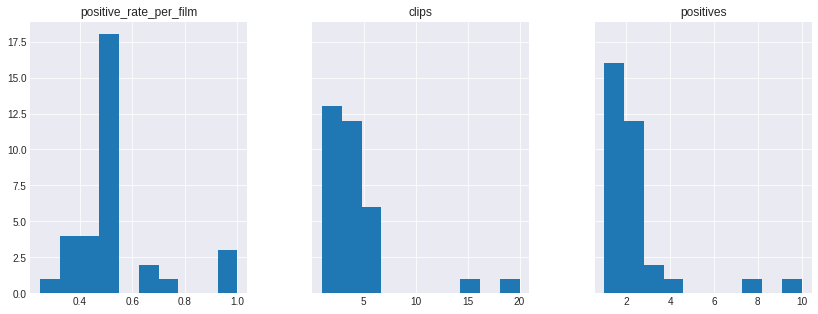

In [ ]:
gr.hist(layout=(1, 3), figsize=(14, 5), sharey=True)
plt.show()

In [ ]:
total_instances = y.count()
match = y.sum()
fake = y.count() - match
print('Total data points: ' + str(total_instances) +
      '\nNumber of matches: ' + str(match) +
      '\nNumber of fakes: ' + str(fake)+
      '\nNumber of columns: ' + str(len(X.columns))+
       '\nNumber of groups:' + str(len(set(groups))))

Total data points: 136
Number of matches: 68
Number of fakes: 68
Number of columns: 455
Number of groups:33


In [ ]:
print('The maximum value in the dataframe is: ' + str(X.max().max()))
print('The minimum value in the dataframe is: ' + str(X.min().min()))
print('The mean value in the dataframe is: ' + str(round(X.mean().mean(),3)))

The maximum value in the dataframe is: 8105.1424
The minimum value in the dataframe is: -28.57613
The mean value in the dataframe is: 9.78


In [ ]:
corr = data.corr(method='spearman')
corr_y = corr['y'].drop(['video_id', 'y'])

In [ ]:
corr_a = corr_y.abs().sort_values(kind="quicksort", ascending=False)

In [ ]:
corr_a

chroma_7_std                                0.268402
delta chroma_7_std                          0.248361
RelativeStrengthOfTopPitchClassesFeature    0.247611
chroma_7_mean                               0.234875
delta energy_entropy_mean                   0.228958
                                              ...   
sports_freq                                      NaN
outdoor_mean_confidence                          NaN
sports_mean_confidence                           NaN
outdoor_mean_area_ratio                          NaN
sports_mean_area_ratio                           NaN
Name: y, Length: 455, dtype: float64

In [ ]:
len(corr_a[corr_a==0])

10

In [ ]:
logo = LeaveOneGroupOut()
print("Number of possible splits: {}".format(logo.get_n_splits(X,y,groups)))

Number of possible splits: 33


In [ ]:
cols_with_nas = [col for col in X.columns if len(X[X[col].isna()])>0.05*len(X)]
if len(cols_with_nas) == 0:
    print("There are no columns with more than 10% empty values")
else:
    print("We have removed the following columns because they were more than 10% empty:")
    for col in cols_with_nas:
        print(col)

We have removed the following columns because they were more than 10% empty:
AverageTimeBetweenAttacksForEachVoiceFeature
AverageVariabilityOfTimeBetweenAttacksForEachVoiceFeature
InitialTimeSignatureFeature


In [ ]:
feat_names = X.columns

In [ ]:
imp = SimpleImputer(missing_values=np.NaN, strategy='mean')
min_max_scaler = preprocessing.MinMaxScaler()
X = X.to_numpy()
y = y.to_numpy()
X = imp.fit_transform(X)
X = min_max_scaler.fit_transform(X)

In [ ]:
m_i = mutual_info_classif(X,y)

In [ ]:
m_i.shape

(455,)

In [ ]:
mutual = [feat_names[i] for i, mi in enumerate(m_i) if mi != 0]

In [ ]:
mutual

['zcr_mean',
 'energy_mean',
 'energy_entropy_mean',
 'spectral_spread_mean',
 'spectral_entropy_mean',
 'spectral_flux_mean',
 'spectral_rolloff_mean',
 'mfcc_1_mean',
 'mfcc_2_mean',
 'mfcc_3_mean',
 'mfcc_4_mean',
 'mfcc_6_mean',
 'mfcc_7_mean',
 'mfcc_8_mean',
 'mfcc_9_mean',
 'mfcc_10_mean',
 'mfcc_11_mean',
 'mfcc_13_mean',
 'chroma_1_mean',
 'chroma_2_mean',
 'chroma_3_mean',
 'chroma_4_mean',
 'chroma_5_mean',
 'chroma_7_mean',
 'chroma_8_mean',
 'chroma_9_mean',
 'chroma_10_mean',
 'chroma_11_mean',
 'chroma_12_mean',
 'chroma_std_mean',
 'delta zcr_mean',
 'delta energy_entropy_mean',
 'delta spectral_centroid_mean',
 'delta spectral_spread_mean',
 'delta spectral_entropy_mean',
 'delta spectral_rolloff_mean',
 'delta mfcc_2_mean',
 'delta mfcc_4_mean',
 'delta mfcc_5_mean',
 'delta mfcc_6_mean',
 'delta mfcc_7_mean',
 'delta mfcc_8_mean',
 'delta mfcc_10_mean',
 'delta mfcc_12_mean',
 'delta chroma_1_mean',
 'delta chroma_6_mean',
 'delta chroma_10_mean',
 'delta chroma_11_m

# Experiment Baseline 
* Vanilla Models
* Vanilla Imputers
* No dimensionality Reduction

In [ ]:
data, X, y, groups = load_data()
imp = SimpleImputer(missing_values=np.NaN, strategy='mean')
min_max_scaler = preprocessing.MinMaxScaler()
X = X.to_numpy()
y = y.to_numpy()

In [ ]:
#we choose a common seed for all algorithms
seed = 2015
#we choose a common number of trees for ensembles
num_trees = 100

models = [('DT', DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=seed)),
          ('LR', LogisticRegression(random_state=seed, solver='liblinear')),
          ('kNN', neighbors.KNeighborsClassifier(n_neighbors=3, weights='uniform', n_jobs=-1)),
          ('SVM', svm.SVC(kernel='rbf', C=1, gamma='auto', cache_size=12288, probability=True)),
          ('RandF',RandomForestClassifier(n_estimators=num_trees,max_depth=1,n_jobs=-1,random_state=seed)),
          ('BTr', BaggingClassifier(
              base_estimator=DecisionTreeClassifier( max_depth=1, random_state=seed),
              n_estimators=num_trees, random_state=seed, n_jobs=-1)),
          ('AdaBoost', AdaBoostClassifier(
              base_estimator=DecisionTreeClassifier( max_depth=1, random_state=seed),
              n_estimators=num_trees, random_state=seed)),
          ('XGBoost', XGBClassifier(nthread=8, use_label_encoder=False)),
          ('GradBoost', GradientBoostingClassifier(random_state=seed)),
          ('ExTrees', ExtraTreesClassifier(random_state=seed)),
          ('Naive Bayes', GaussianNB())
          ]

In [ ]:
logo = LeaveOneGroupOut()
fold_results = init_fold_results()
i = 0
for train_index, test_index in logo.split(X, y, groups):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index] 
  # fit the transformations
  X_train = imp.fit_transform(X_train)
  X_test = imp.transform(X_test)

  X_train = min_max_scaler.fit_transform(X_train)
  X_test = min_max_scaler.transform(X_test)
  for name, model in models:
    # fit the model
    model.fit(X_train, y_train)
    predicted = model.predict(X_test)
    pred_proba = model.predict_proba(X_test)
    # gather metrics
    accuracy = model.score(X_test, y_test)
    precision = precision_score(y_test, predicted)
    recall = recall_score(y_test, predicted)
    f1 = f1_score(y_test, predicted)
    fpr, tpr, _ = roc_curve(y_test, pred_proba[:, 1], 1)
    roc_auc = auc(fpr, tpr)
    cm = confusion_matrix(y_test, predicted)
    fold_results[name]['accuracy'].append(accuracy)
    fold_results[name]['precision'].append(precision)
    fold_results[name]['recall'].append(recall)
    fold_results[name]['f1'].append(f1)
    fold_results[name]['roc'].append(np.nan_to_num(roc_auc))
    fold_results[name]['fpr'].append(fpr)
    fold_results[name]['tpr'].append(tpr)
    fold_results[name]['cm'].append(cm)
    fold_results[name]['total_y'].append(y_test)
    fold_results[name]['total_y_pred'].append(predicted)
    fold_results[name]['total_y_proba'].append(pred_proba)
  i+=1
    


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined a

DT
              precision    recall  f1-score   support

           0       0.50      0.60      0.55        68
           1       0.50      0.40      0.44        68

    accuracy                           0.50       136
   macro avg       0.50      0.50      0.49       136
weighted avg       0.50      0.50      0.49       136

LR
              precision    recall  f1-score   support

           0       0.43      0.43      0.43        68
           1       0.43      0.44      0.44        68

    accuracy                           0.43       136
   macro avg       0.43      0.43      0.43       136
weighted avg       0.43      0.43      0.43       136

kNN
              precision    recall  f1-score   support

           0       0.53      0.54      0.54        68
           1       0.53      0.51      0.52        68

    accuracy                           0.53       136
   macro avg       0.53      0.53      0.53       136
weighted avg       0.53      0.53      0.53       136

SVM
     

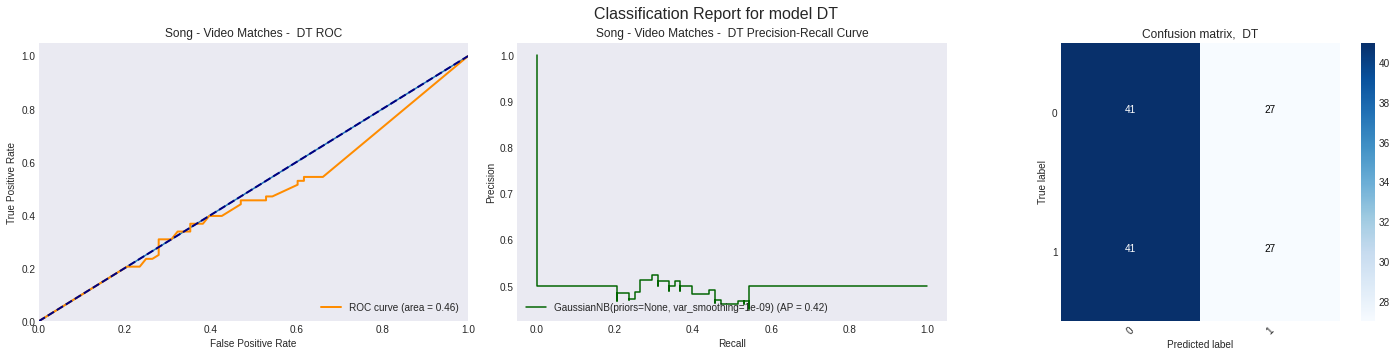

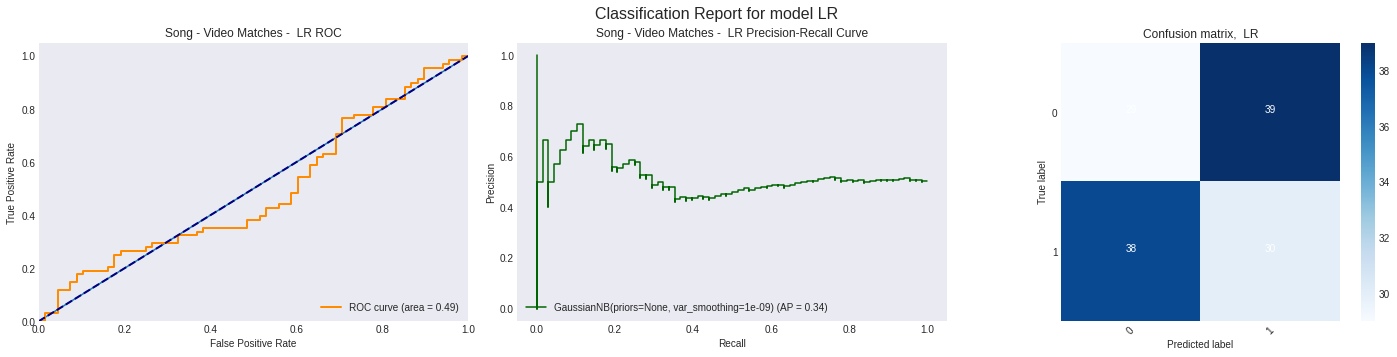

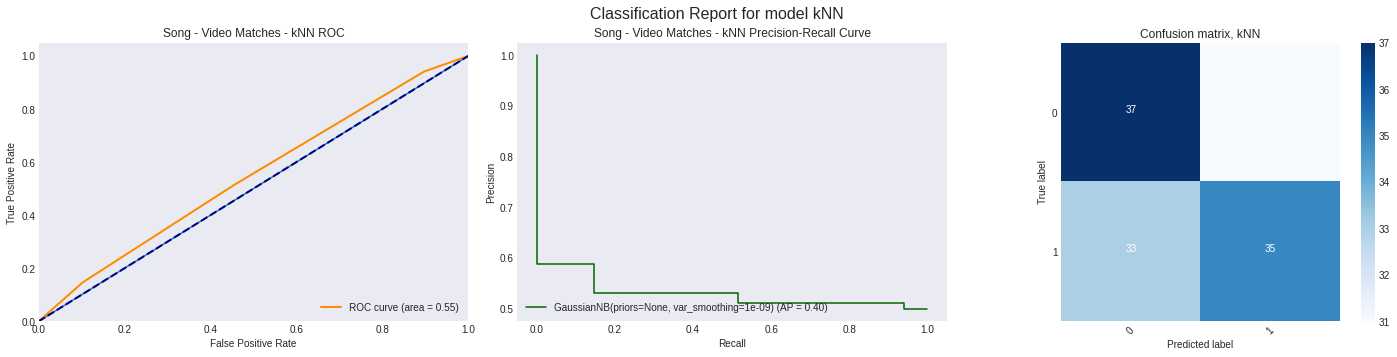

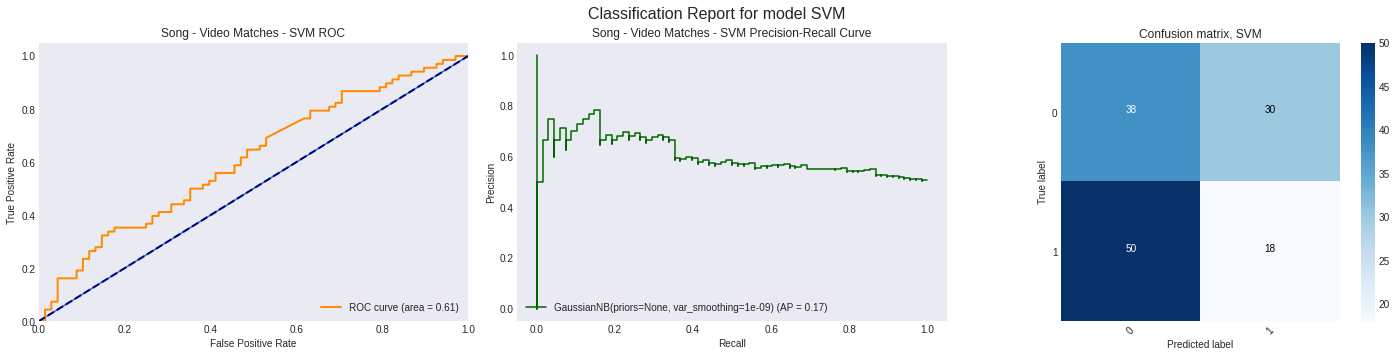

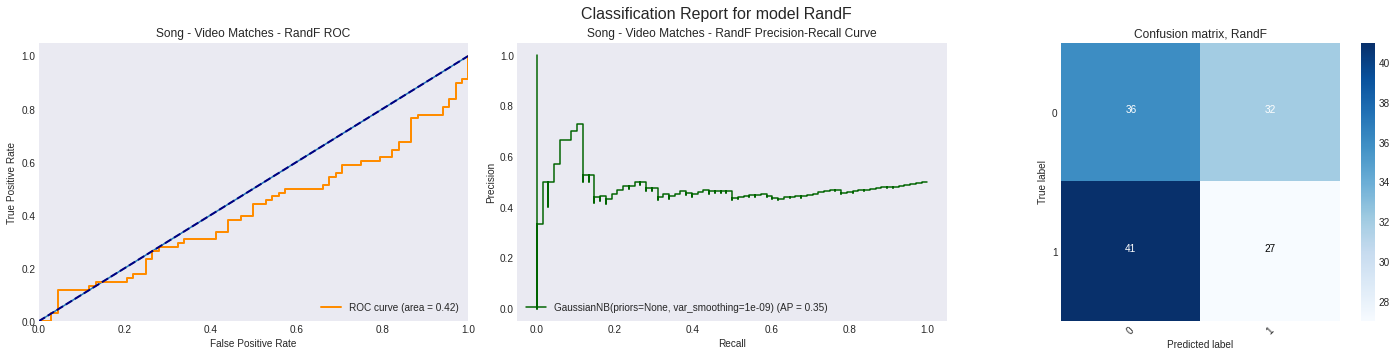

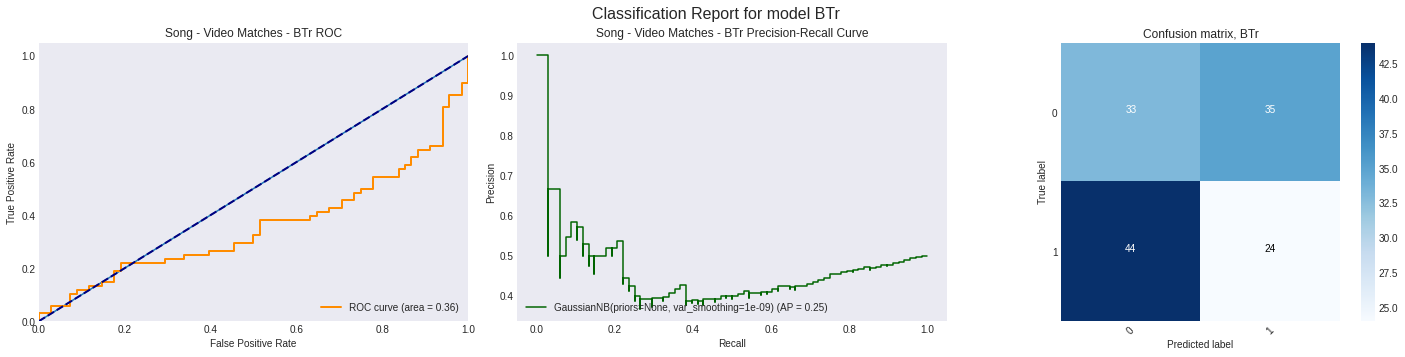

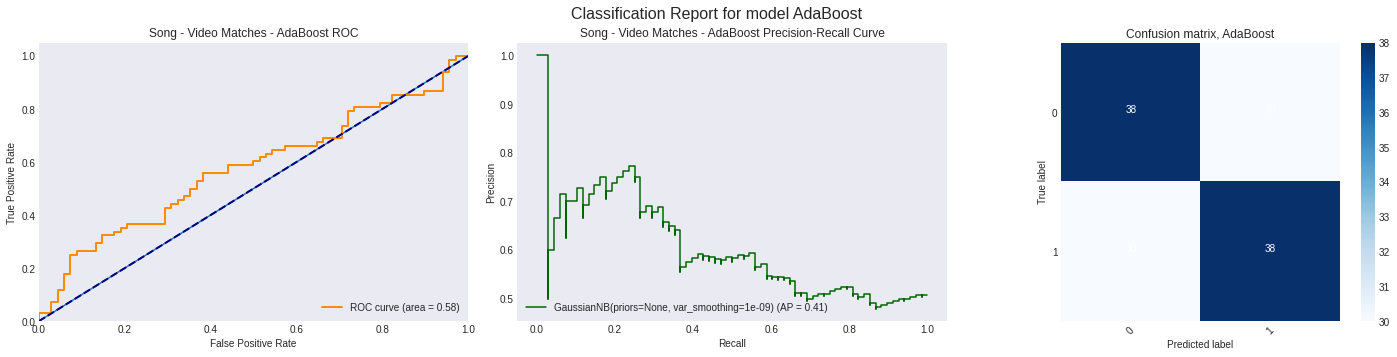

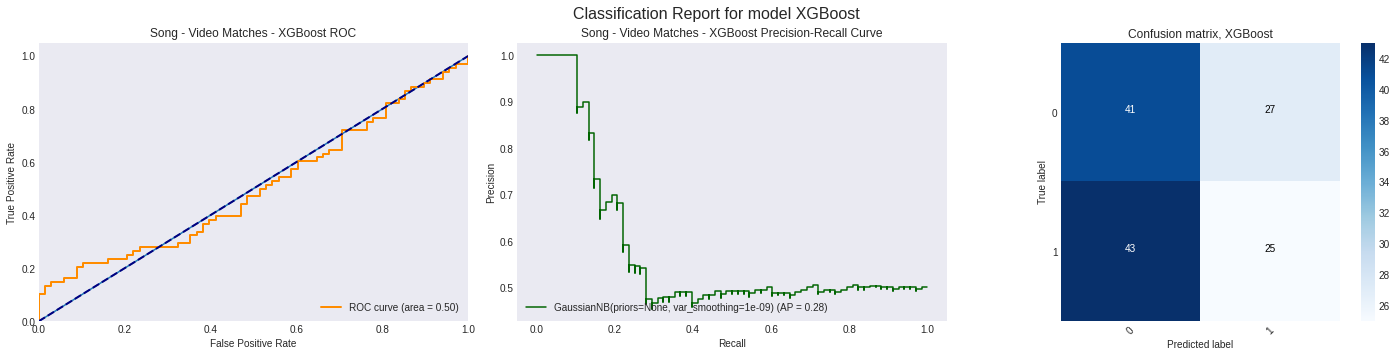

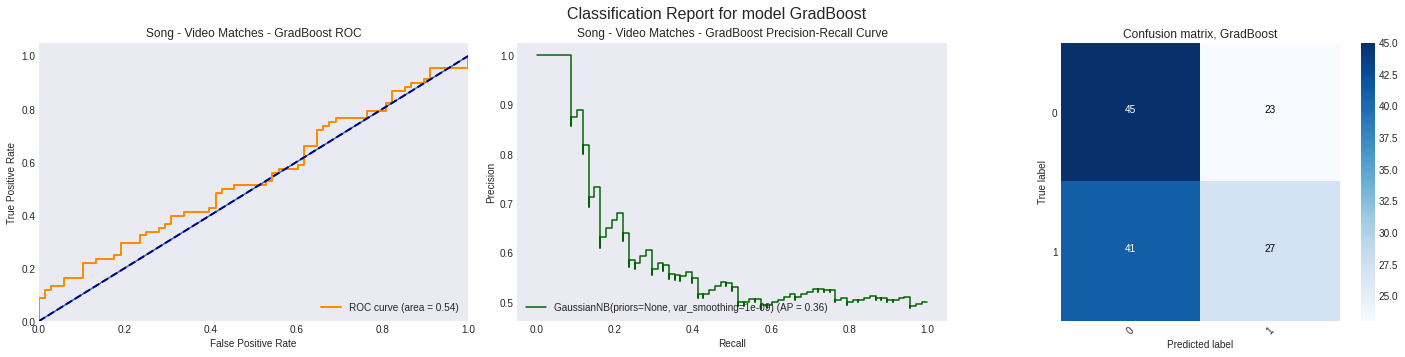

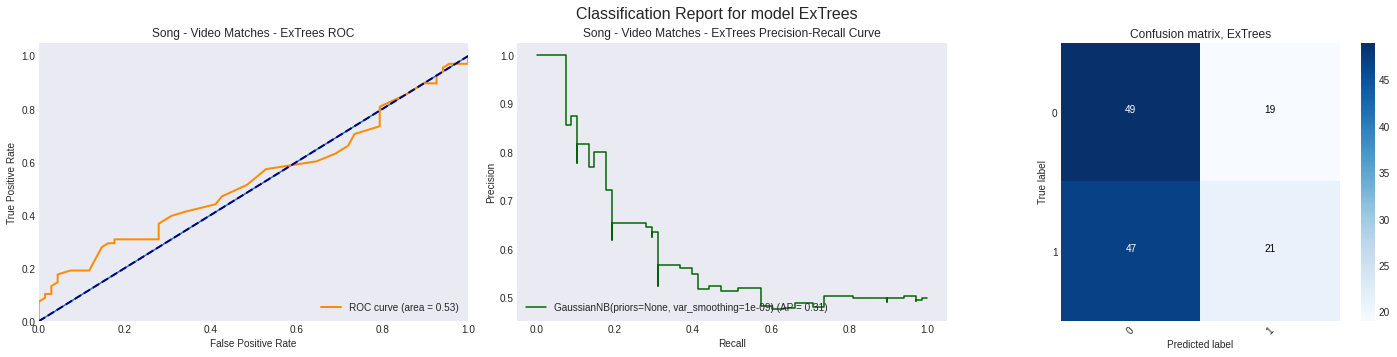

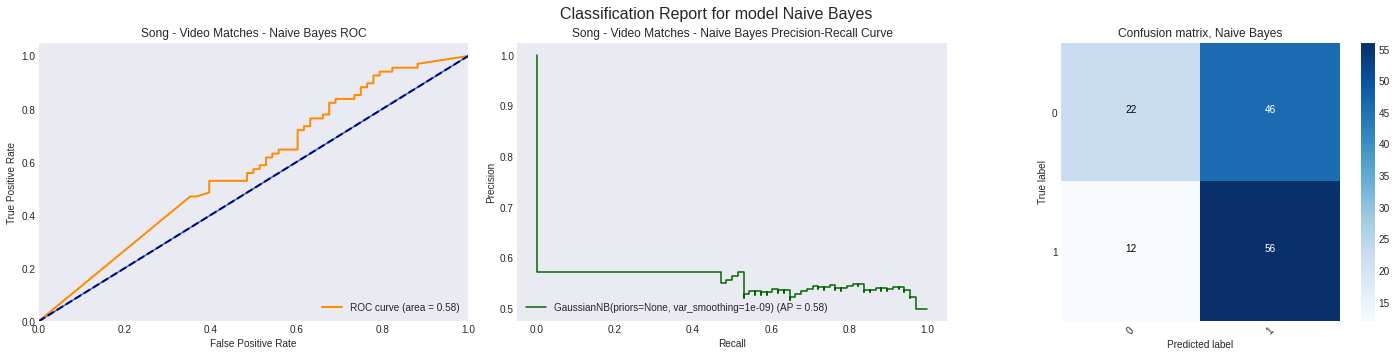

In [ ]:
get_results_and_plots(fold_results)

In [ ]:
get_model_comparison_mean(fold_results)

DT    LR   kNN   SVM  ...  XGBoost  GradBoost  ExTrees  Naive Bayes
accuracy   0.52  0.42  0.50  0.38  ...     0.45       0.53     0.55         0.63
precision  0.42  0.34  0.40  0.17  ...     0.28       0.36     0.31         0.58
recall     0.46  0.41  0.41  0.34  ...     0.29       0.39     0.31         0.84
f1         0.41  0.35  0.38  0.21  ...     0.26       0.36     0.29         0.66
roc        0.39  0.41  0.45  0.55  ...     0.45       0.49     0.48         0.55

[5 rows x 11 columns]

In [ ]:
get_model_comparison_std(fold_results)

DT    LR   kNN   SVM  ...  XGBoost  GradBoost  ExTrees  Naive Bayes
accuracy   0.28  0.32  0.31  0.18  ...     0.25       0.27     0.22         0.28
precision  0.41  0.38  0.43  0.24  ...     0.36       0.41     0.41         0.33
recall     0.45  0.44  0.43  0.46  ...     0.38       0.43     0.41         0.34
f1         0.39  0.37  0.39  0.27  ...     0.32       0.39     0.38         0.31
roc        0.35  0.41  0.37  0.40  ...     0.38       0.43     0.41         0.37

[5 rows x 11 columns]

In [ ]:
get_model_comparison_median(fold_results)

DT    LR   kNN   SVM  ...  XGBoost  GradBoost  ExTrees  Naive Bayes
accuracy   0.50  0.50  0.50  0.40  ...      0.5       0.50      0.5         0.56
precision  0.50  0.33  0.33  0.00  ...      0.0       0.33      0.0         0.50
recall     0.50  0.33  0.50  0.00  ...      0.0       0.25      0.0         1.00
f1         0.50  0.33  0.40  0.00  ...      0.0       0.31      0.0         0.67
roc        0.42  0.33  0.50  0.51  ...      0.5       0.50      0.5         0.50

[5 rows x 11 columns]

# Experiment Standardization 
* Vanilla Models
* Vanilla Imputers
* No dimensionality Reduction

In [ ]:
data, X, y, groups = load_data()
imp = SimpleImputer(missing_values=np.NaN, strategy='mean')
scaler = preprocessing.StandardScaler()

X = X.to_numpy()
y = y.to_numpy()


In [ ]:
#we choose a common seed for all algorithms
seed = 2015
#we choose a common number of trees for ensembles
num_trees = 100

models = [('DT', DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=seed)),
          ('LR', LogisticRegression(random_state=seed, solver='liblinear')),
          ('kNN', neighbors.KNeighborsClassifier(n_neighbors=3, weights='uniform', n_jobs=-1)),
          ('SVM', svm.SVC(kernel='rbf', C=1, gamma='auto', cache_size=12288, probability=True)),
          ('RandF',RandomForestClassifier(n_estimators=num_trees,max_depth=1,n_jobs=-1,random_state=seed)),
          ('BTr', BaggingClassifier(
              base_estimator=DecisionTreeClassifier( max_depth=1, random_state=seed),
              n_estimators=num_trees, random_state=seed, n_jobs=-1)),
          ('AdaBoost', AdaBoostClassifier(
              base_estimator=DecisionTreeClassifier( max_depth=1, random_state=seed),
              n_estimators=num_trees, random_state=seed)),
          ('XGBoost', XGBClassifier(nthread=8, use_label_encoder=False)),
          ('GradBoost', GradientBoostingClassifier(random_state=seed)),
          ('ExTrees', ExtraTreesClassifier(random_state=seed)),
          ('Naive Bayes', GaussianNB())
          ]

In [ ]:

fold_results = init_fold_results()
i = 0
for train_index, test_index in logo.split(X, y, groups):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index] 
    # fit the transformations
    X_train = imp.fit_transform(X_train)
    X_test = imp.transform(X_test)

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    for name, model in models:
        # fit the model
        model.fit(X_train, y_train)
        predicted = model.predict(X_test)
        pred_proba = model.predict_proba(X_test)
        # gather metrics
        accuracy = model.score(X_test, y_test)
        precision = precision_score(y_test, predicted)
        recall = recall_score(y_test, predicted)
        f1 = f1_score(y_test, predicted)
        fpr, tpr, _ = roc_curve(y_test, pred_proba[:, 1], 1)
        roc_auc = auc(fpr, tpr)
        cm = confusion_matrix(y_test, predicted)
        fold_results[name]['accuracy'].append(accuracy)
        fold_results[name]['precision'].append(precision)
        fold_results[name]['recall'].append(recall)
        fold_results[name]['f1'].append(f1)
        fold_results[name]['roc'].append(np.nan_to_num(roc_auc))
        fold_results[name]['fpr'].append(fpr)
        fold_results[name]['tpr'].append(tpr)
        fold_results[name]['cm'].append(cm)
        fold_results[name]['total_y'].append(y_test)
        fold_results[name]['total_y_pred'].append(predicted)
        fold_results[name]['total_y_proba'].append(pred_proba)
    i+=1
    


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined a

DT
              precision    recall  f1-score   support

           0       0.50      0.60      0.55        68
           1       0.50      0.40      0.44        68

    accuracy                           0.50       136
   macro avg       0.50      0.50      0.49       136
weighted avg       0.50      0.50      0.49       136

LR
              precision    recall  f1-score   support

           0       0.46      0.49      0.47        68
           1       0.46      0.44      0.45        68

    accuracy                           0.46       136
   macro avg       0.46      0.46      0.46       136
weighted avg       0.46      0.46      0.46       136

kNN
              precision    recall  f1-score   support

           0       0.49      0.47      0.48        68
           1       0.49      0.51      0.50        68

    accuracy                           0.49       136
   macro avg       0.49      0.49      0.49       136
weighted avg       0.49      0.49      0.49       136

SVM
     

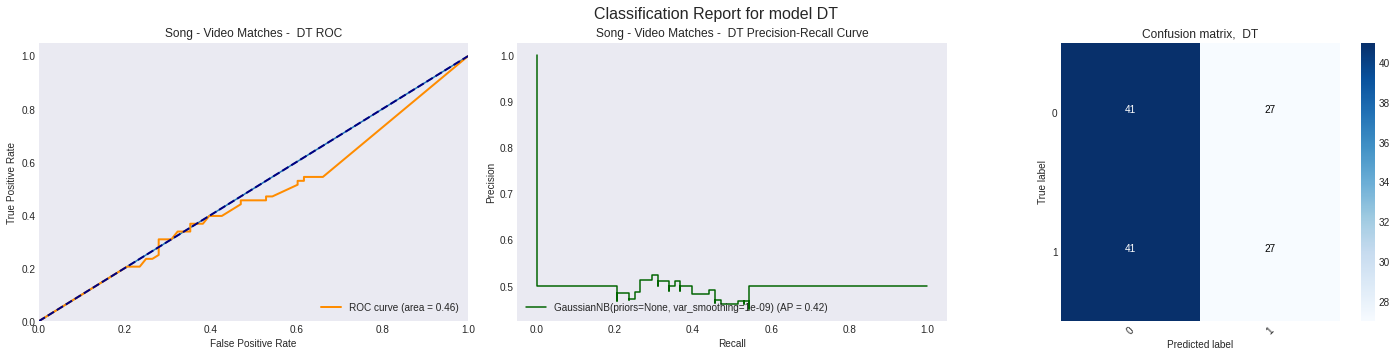

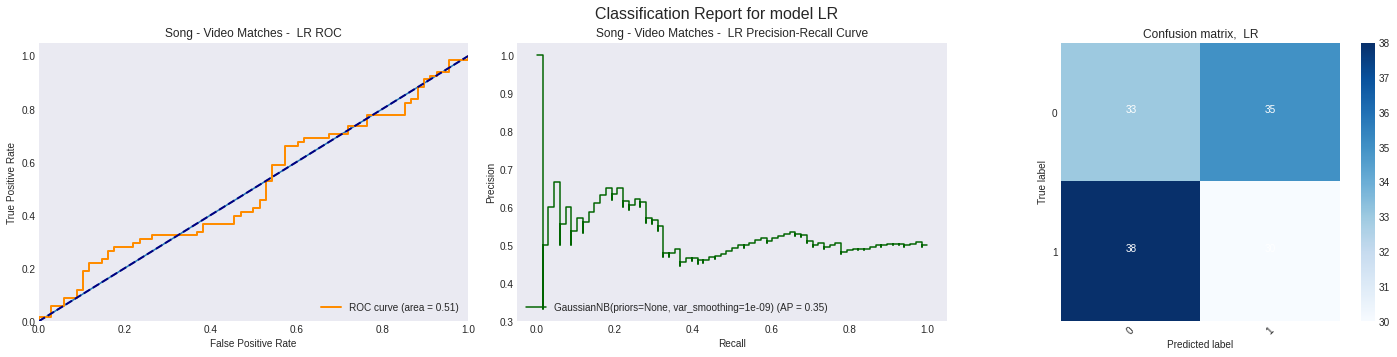

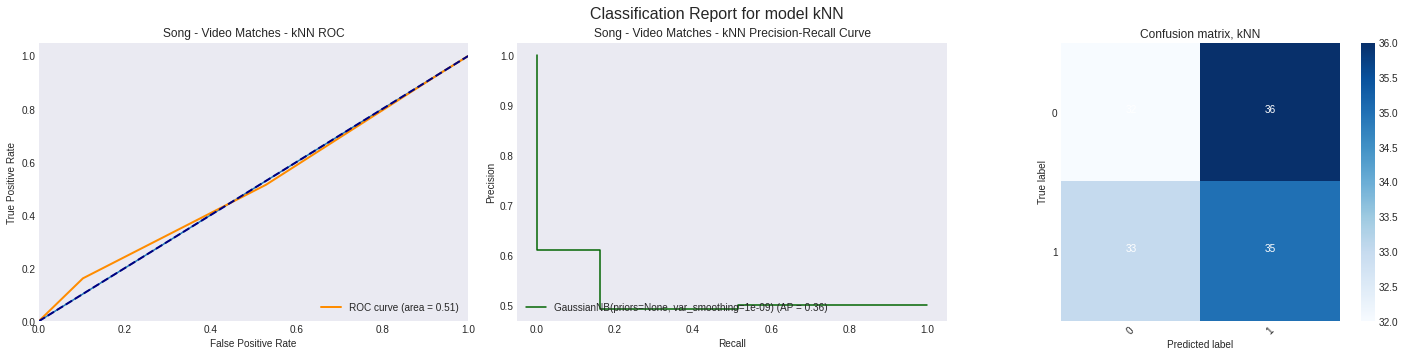

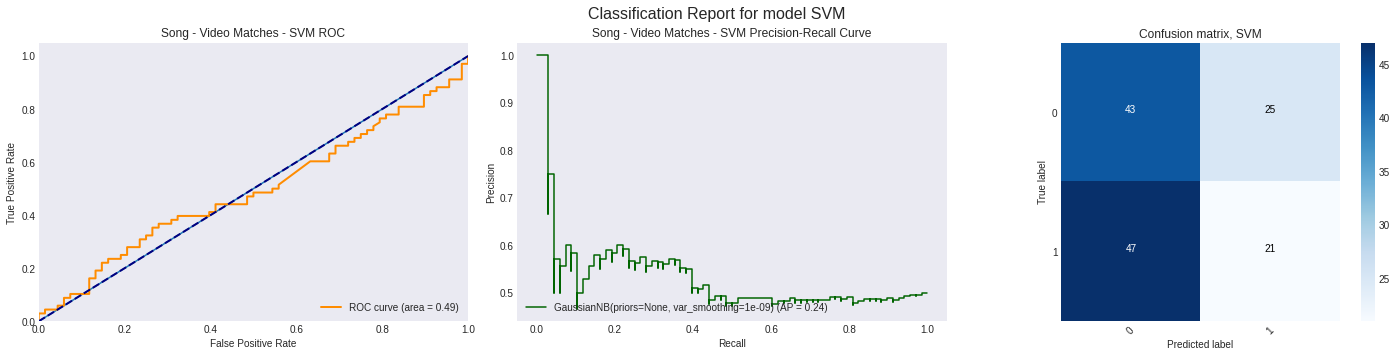

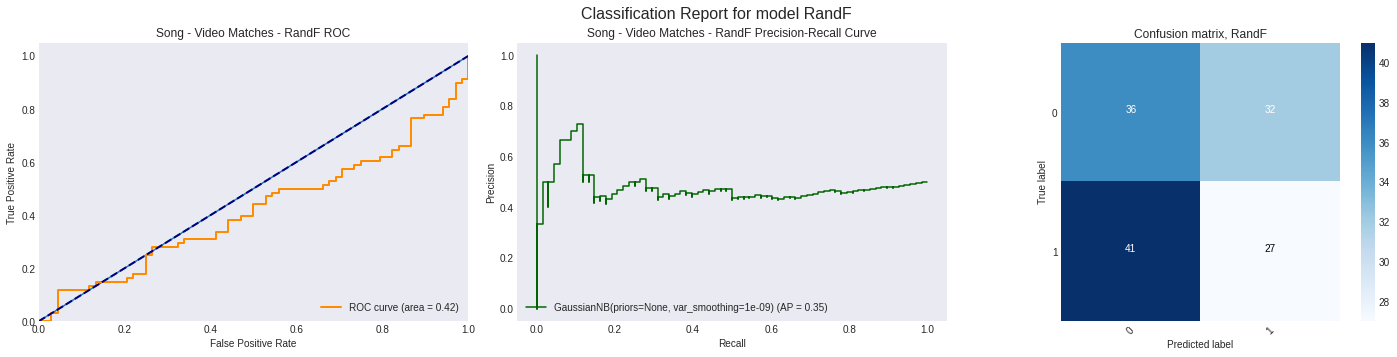

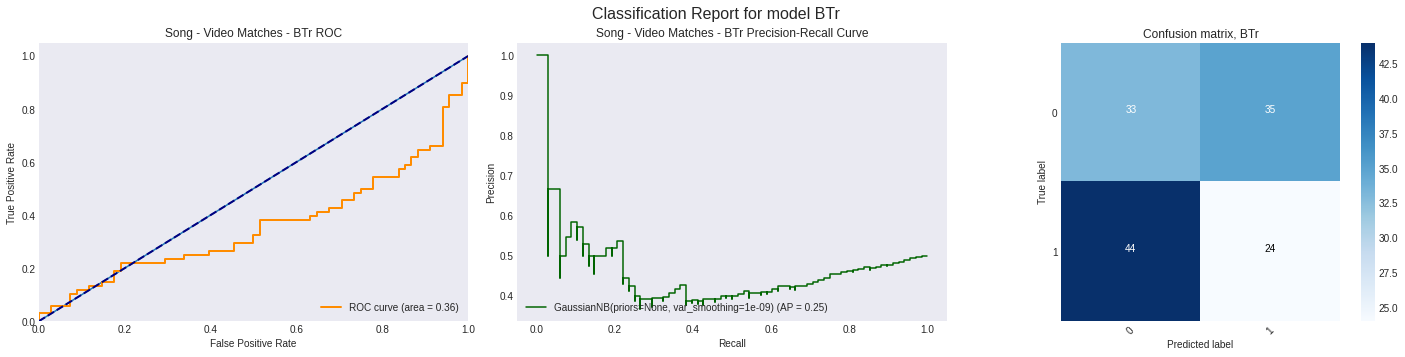

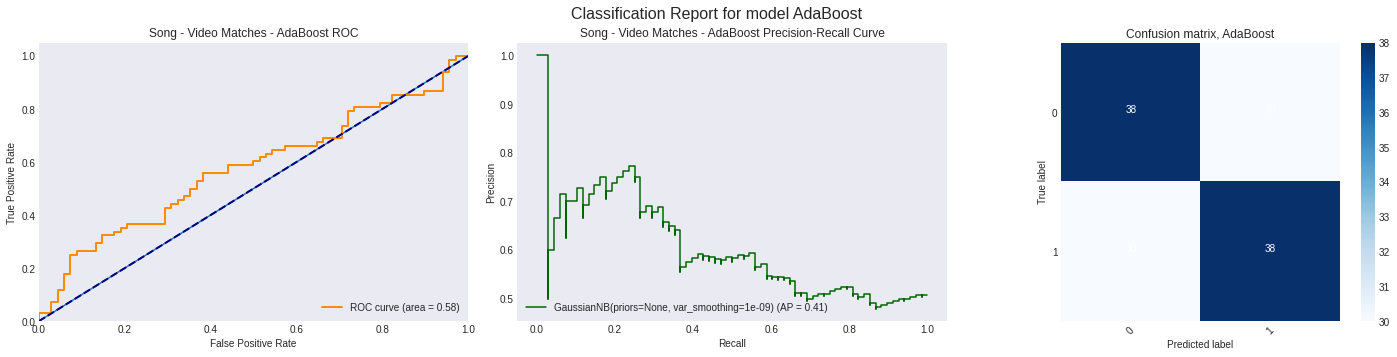

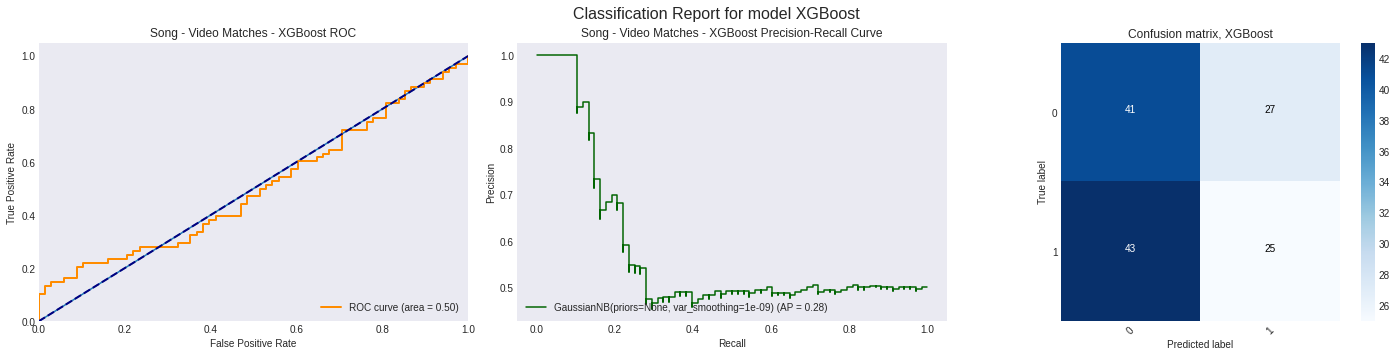

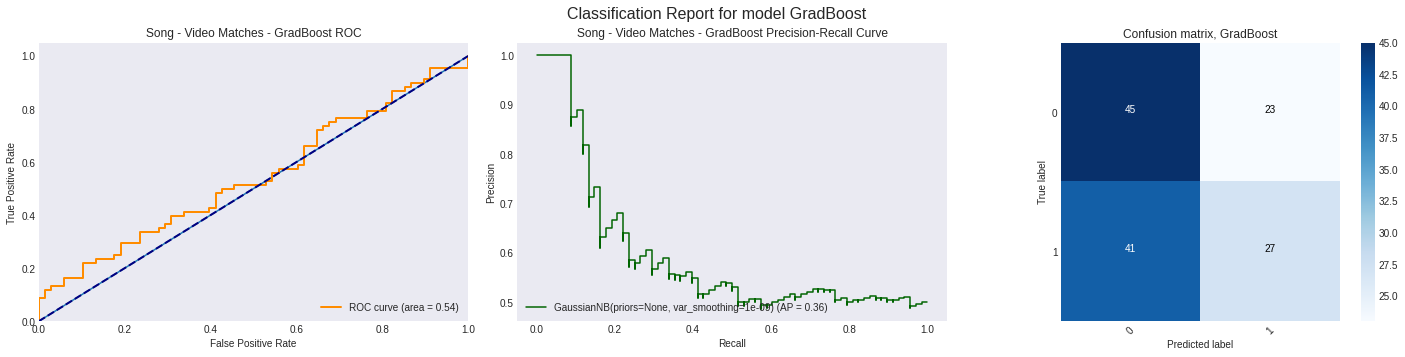

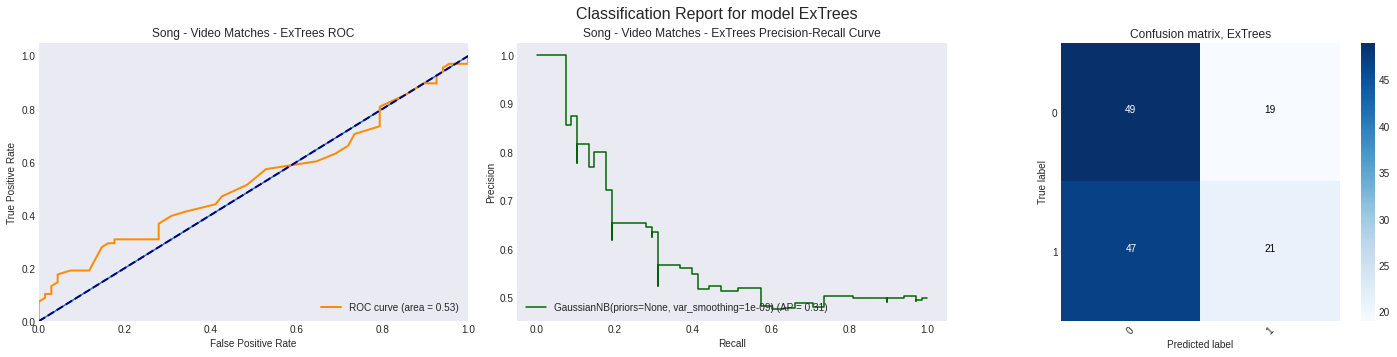

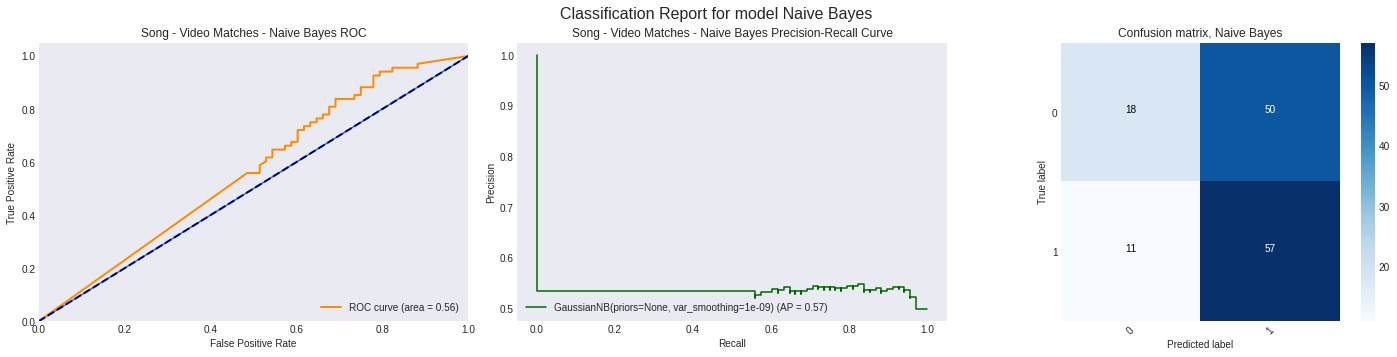

In [ ]:
get_results_and_plots(fold_results)

In [ ]:
get_model_comparison_mean(fold_results)

DT    LR   kNN   SVM  ...  XGBoost  GradBoost  ExTrees  Naive Bayes
accuracy   0.52  0.43  0.47  0.45  ...     0.45       0.53     0.55         0.60
precision  0.42  0.35  0.36  0.24  ...     0.28       0.36     0.31         0.57
recall     0.46  0.42  0.42  0.26  ...     0.29       0.39     0.31         0.88
f1         0.41  0.36  0.36  0.23  ...     0.26       0.36     0.29         0.67
roc        0.39  0.39  0.42  0.48  ...     0.45       0.49     0.48         0.55

[5 rows x 11 columns]

In [ ]:
get_model_comparison_std(fold_results)

DT    LR   kNN   SVM  ...  XGBoost  GradBoost  ExTrees  Naive Bayes
accuracy   0.28  0.25  0.27  0.26  ...     0.25       0.27     0.22         0.29
precision  0.41  0.36  0.39  0.35  ...     0.36       0.41     0.41         0.30
recall     0.45  0.42  0.43  0.36  ...     0.38       0.43     0.41         0.31
f1         0.39  0.34  0.37  0.32  ...     0.32       0.39     0.38         0.28
roc        0.35  0.40  0.33  0.42  ...     0.38       0.43     0.41         0.35

[5 rows x 11 columns]

In [ ]:
get_model_comparison_median(fold_results)

DT    LR   kNN  SVM  ...  XGBoost  GradBoost  ExTrees  Naive Bayes
accuracy   0.50  0.50  0.50  0.5  ...      0.5       0.50      0.5         0.50
precision  0.50  0.40  0.33  0.0  ...      0.0       0.33      0.0         0.50
recall     0.50  0.50  0.50  0.0  ...      0.0       0.25      0.0         1.00
f1         0.50  0.50  0.40  0.0  ...      0.0       0.31      0.0         0.67
roc        0.42  0.33  0.42  0.5  ...      0.5       0.50      0.5         0.50

[5 rows x 11 columns]

# Experiment Normalisation


In [ ]:
data, X, y, groups = load_data()
imp = SimpleImputer(missing_values=np.NaN, strategy='mean')
scaler = preprocessing.Normalizer(norm='l2')


In [ ]:
#we choose a common seed for all algorithms
seed = 2015
#we choose a common number of trees for ensembles
num_trees = 100

models = [('DT', DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=seed)),
          ('LR', LogisticRegression(random_state=seed, solver='liblinear')),
          ('kNN', neighbors.KNeighborsClassifier(n_neighbors=3, weights='uniform', n_jobs=-1)),
          ('SVM', svm.SVC(kernel='rbf', C=1, gamma='auto', cache_size=12288, probability=True)),
          ('RandF',RandomForestClassifier(n_estimators=num_trees,max_depth=1,n_jobs=-1,random_state=seed)),
          ('BTr', BaggingClassifier(
              base_estimator=DecisionTreeClassifier( max_depth=1, random_state=seed),
              n_estimators=num_trees, random_state=seed, n_jobs=-1)),
          ('AdaBoost', AdaBoostClassifier(
              base_estimator=DecisionTreeClassifier( max_depth=1, random_state=seed),
              n_estimators=num_trees, random_state=seed)),
          ('XGBoost', XGBClassifier(nthread=8, use_label_encoder=False)),
          ('GradBoost', GradientBoostingClassifier(random_state=seed)),
          ('ExTrees', ExtraTreesClassifier(random_state=seed)),
          ('Naive Bayes', GaussianNB())
          ]

In [ ]:
X = X.to_numpy()
y = y.to_numpy()

fold_results = init_fold_results()
i = 0
for train_index, test_index in logo.split(X, y, groups):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index] 
    # fit the transformations
    X_train = imp.fit_transform(X_train)
    X_test = imp.transform(X_test)

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    for name, model in models:
        # fit the model
        model.fit(X_train, y_train)
        predicted = model.predict(X_test)
        pred_proba = model.predict_proba(X_test)
        # gather metrics
        accuracy = model.score(X_test, y_test)
        precision = precision_score(y_test, predicted)
        recall = recall_score(y_test, predicted)
        f1 = f1_score(y_test, predicted)
        fpr, tpr, _ = roc_curve(y_test, pred_proba[:, 1], 1)
        roc_auc = auc(fpr, tpr)
        cm = confusion_matrix(y_test, predicted)
        fold_results[name]['accuracy'].append(accuracy)
        fold_results[name]['precision'].append(precision)
        fold_results[name]['recall'].append(recall)
        fold_results[name]['f1'].append(f1)
        fold_results[name]['roc'].append(np.nan_to_num(roc_auc))
        fold_results[name]['fpr'].append(fpr)
        fold_results[name]['tpr'].append(tpr)
        fold_results[name]['cm'].append(cm)
        fold_results[name]['total_y'].append(y_test)
        fold_results[name]['total_y_pred'].append(predicted)
        fold_results[name]['total_y_proba'].append(pred_proba)
    i+=1
    


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined a

DT
              precision    recall  f1-score   support

           0       0.48      0.56      0.52        68
           1       0.47      0.40      0.43        68

    accuracy                           0.48       136
   macro avg       0.48      0.48      0.47       136
weighted avg       0.48      0.48      0.47       136

LR
              precision    recall  f1-score   support

           0       0.51      0.75      0.61        68
           1       0.53      0.28      0.37        68

    accuracy                           0.51       136
   macro avg       0.52      0.51      0.49       136
weighted avg       0.52      0.51      0.49       136

kNN
              precision    recall  f1-score   support

           0       0.48      0.43      0.45        68
           1       0.48      0.53      0.50        68

    accuracy                           0.48       136
   macro avg       0.48      0.48      0.48       136
weighted avg       0.48      0.48      0.48       136

SVM
     

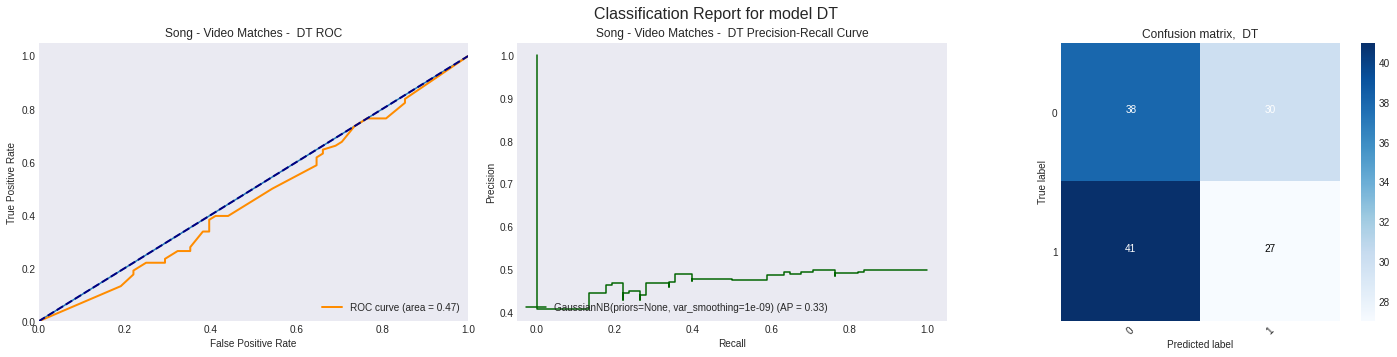

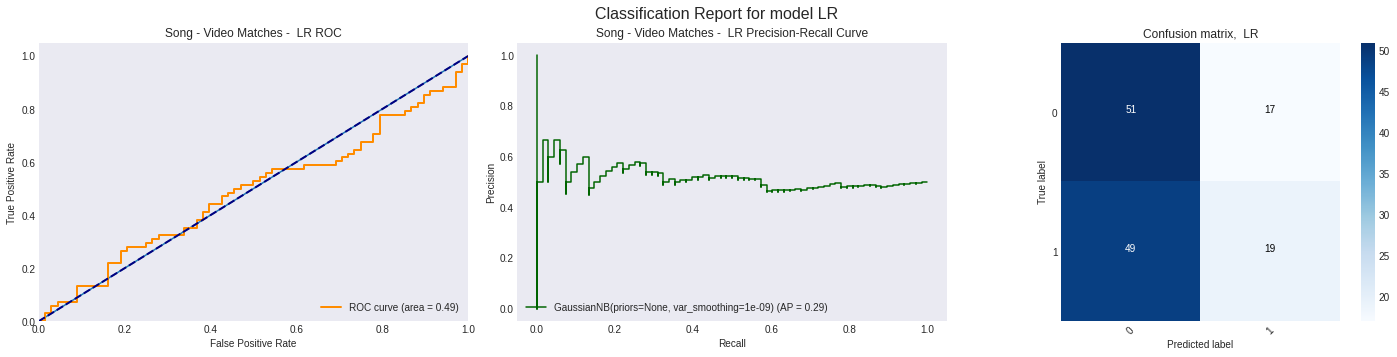

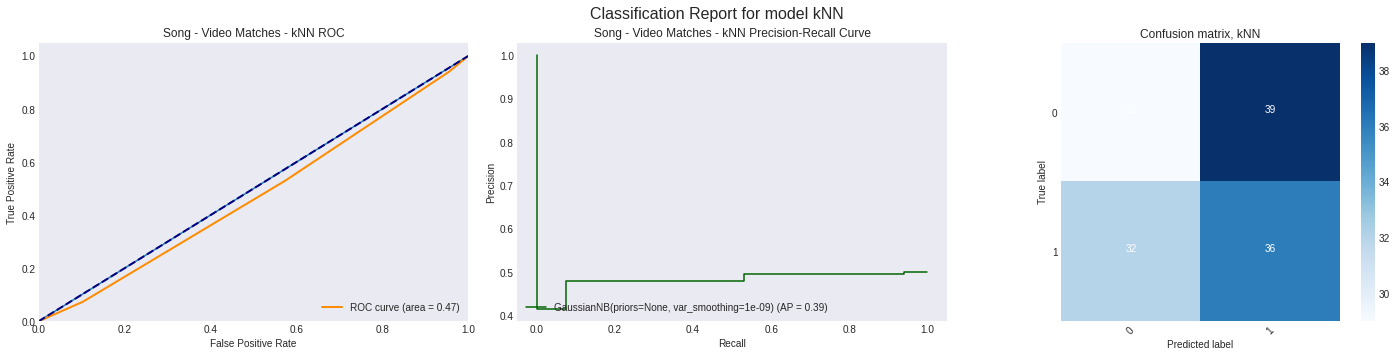

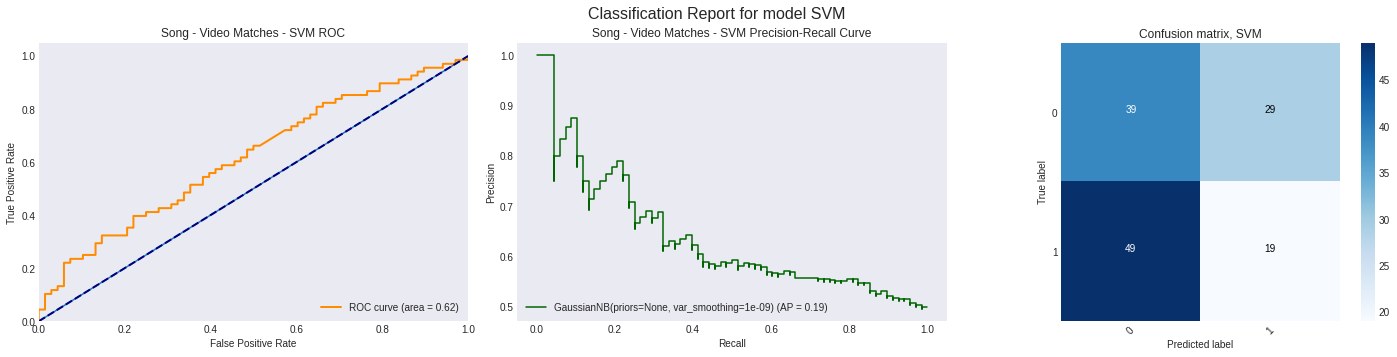

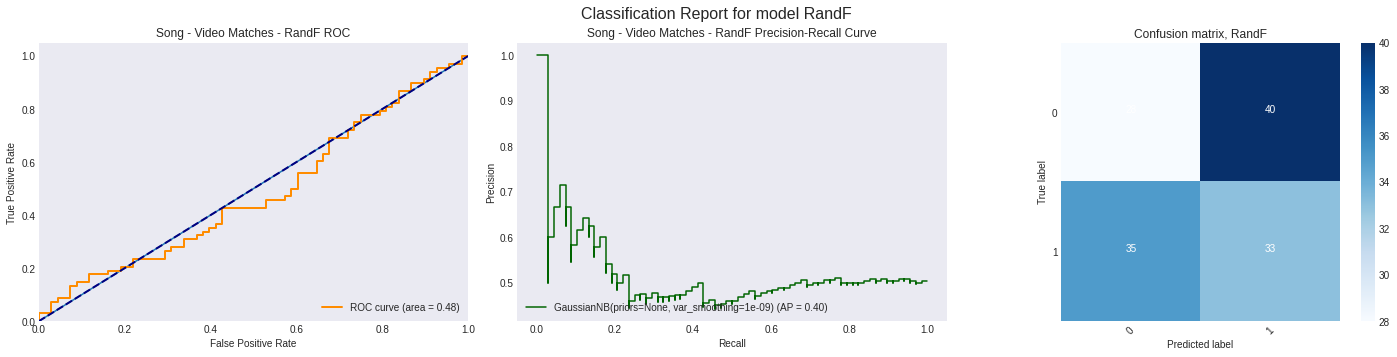

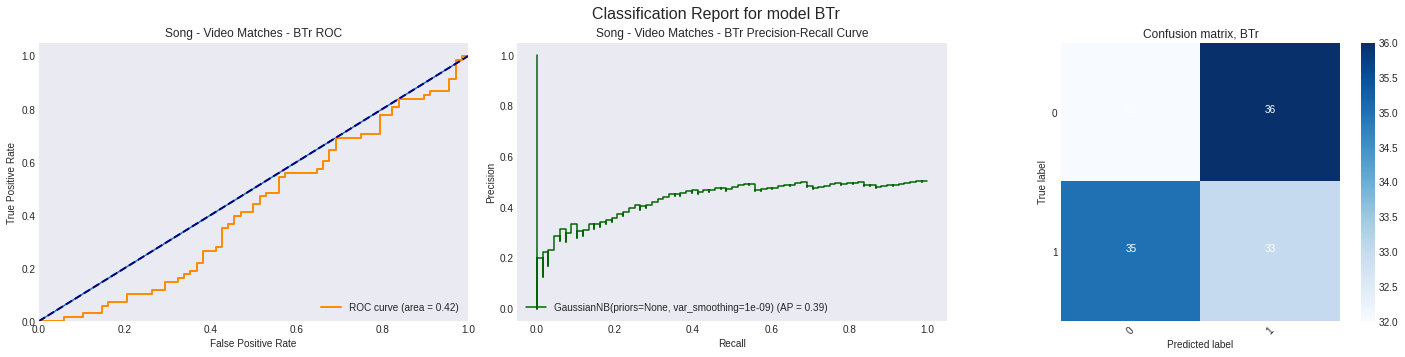

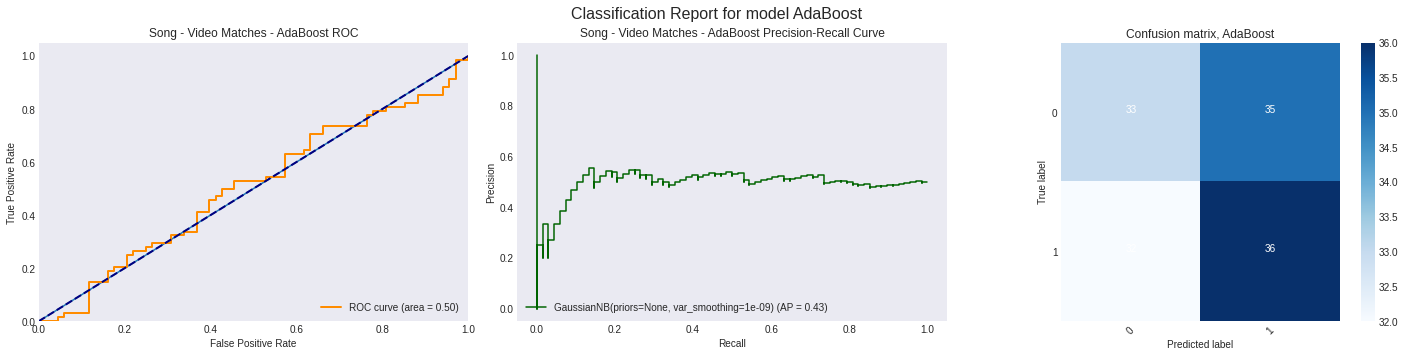

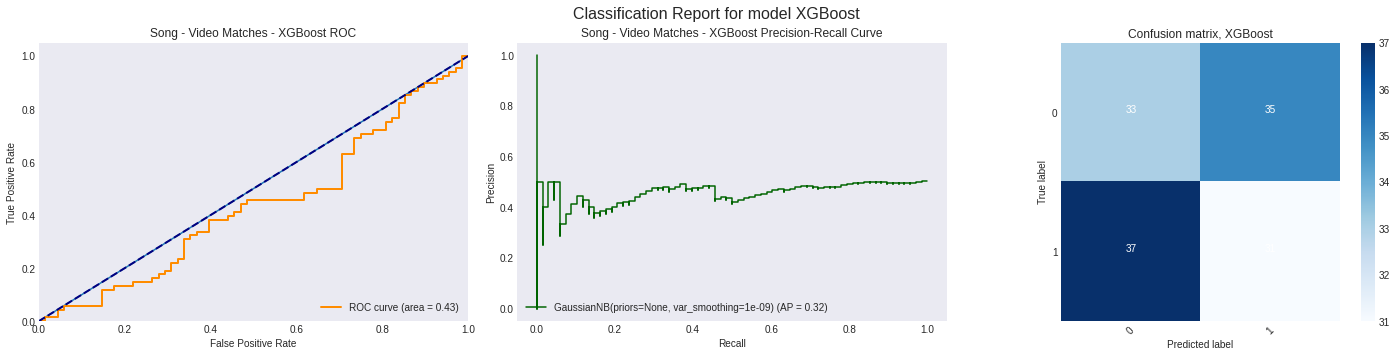

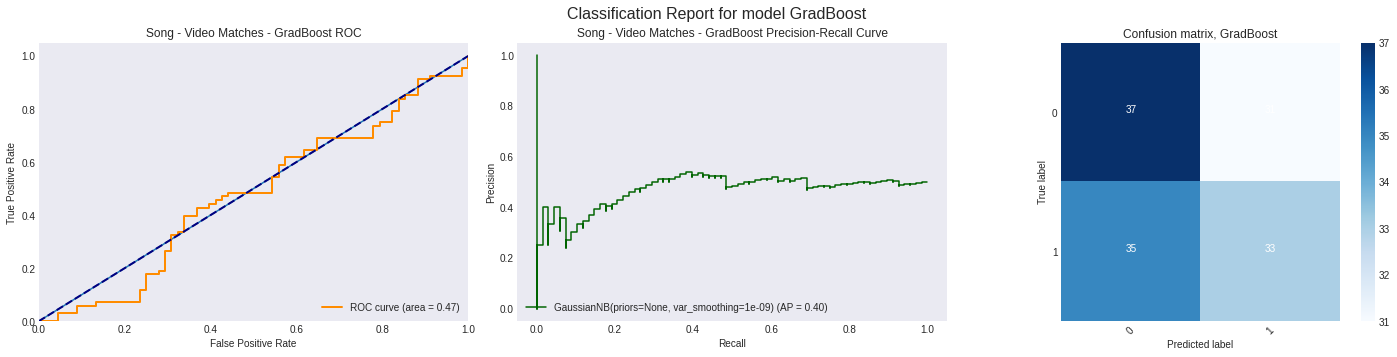

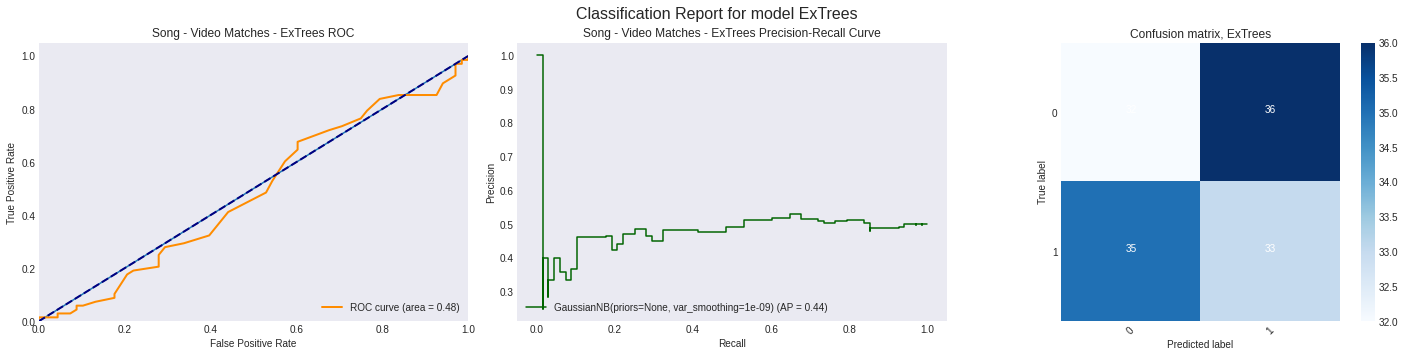

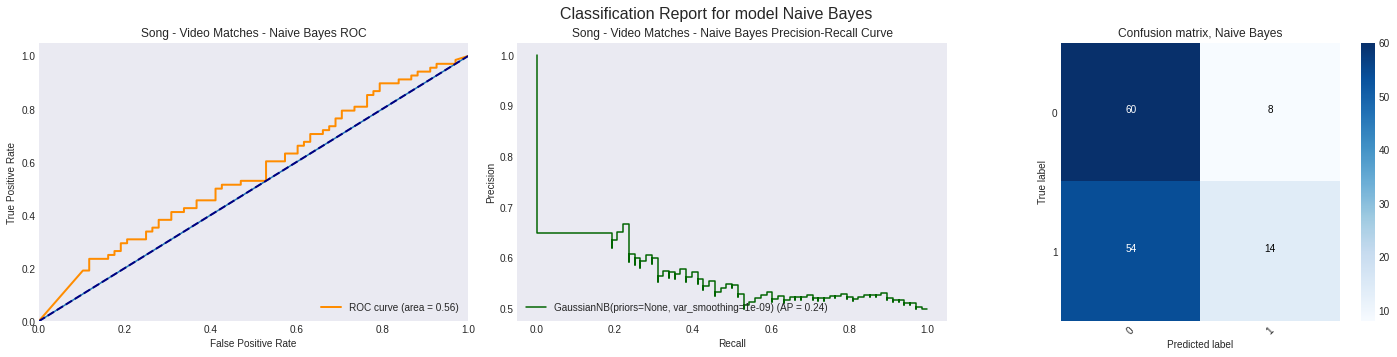

In [ ]:
get_results_and_plots(fold_results)

In [ ]:
get_model_comparison_mean(fold_results)

DT    LR   kNN   SVM  ...  XGBoost  GradBoost  ExTrees  Naive Bayes
accuracy   0.44  0.54  0.49  0.40  ...     0.44       0.50     0.46         0.56
precision  0.33  0.29  0.39  0.19  ...     0.32       0.40     0.44         0.24
recall     0.42  0.31  0.53  0.38  ...     0.37       0.42     0.46         0.23
f1         0.34  0.28  0.43  0.23  ...     0.33       0.38     0.42         0.21
roc        0.40  0.37  0.35  0.42  ...     0.42       0.38     0.37         0.50

[5 rows x 11 columns]

In [ ]:
get_model_comparison_std(fold_results)

DT    LR   kNN   SVM  ...  XGBoost  GradBoost  ExTrees  Naive Bayes
accuracy   0.25  0.18  0.26  0.15  ...     0.31       0.29     0.29         0.12
precision  0.36  0.37  0.32  0.22  ...     0.40       0.43     0.38         0.38
recall     0.45  0.39  0.45  0.47  ...     0.44       0.43     0.39         0.36
f1         0.36  0.34  0.35  0.27  ...     0.39       0.39     0.34         0.33
roc        0.33  0.37  0.28  0.35  ...     0.42       0.43     0.38         0.33

[5 rows x 11 columns]

In [ ]:
get_model_comparison_median(fold_results)

DT    LR   kNN  SVM  ...  XGBoost  GradBoost  ExTrees  Naive Bayes
accuracy   0.50  0.50  0.50  0.5  ...      0.5       0.50     0.50          0.5
precision  0.25  0.00  0.50  0.0  ...      0.0       0.33     0.50          0.0
recall     0.30  0.00  0.50  0.0  ...      0.0       0.50     0.50          0.0
f1         0.40  0.00  0.50  0.0  ...      0.0       0.40     0.50          0.0
roc        0.50  0.33  0.42  0.5  ...      0.5       0.17     0.33          0.5

[5 rows x 11 columns]

# Experiment with Dimensions 1
* Dimensionality Reduction - remove empty columns and highly correlated pairs
* Vanilla Classifiers
* Vanilla Imputers

In [ ]:
data, X, y, groups = load_data()

empty_cols = [col for col in X.columns if (X[col] == 0).all()]
print('The number of columns with only zero values is: {}'.format(str(len(empty_cols))))
print('These are:')
for col in empty_cols:
    print(col)

The number of columns with only zero values is: 10
These are:
delta chroma_8_mean
QuintupleMeterFeature
ComposerPopularity
LanguageFeature
outdoor_freq
sports_freq
outdoor_mean_confidence
sports_mean_confidence
outdoor_mean_area_ratio
sports_mean_area_ratio


In [ ]:
print("We remove those from the dataset")
X = X.drop(empty_cols, axis=1)

We remove those from the dataset


In [ ]:
cols_with_nas = [col for col in X.columns if len(X[X[col].isna()])>0.1*len(X)]
if len(cols_with_nas) == 0:
    print("There are no columns with more than 10% empty values")
else:
    print("We have removed the following columns because they were more than 10% empty:")
    for col in cols_with_nas:
        print(col)
    X = X.drop(cols_with_nas, axis=1)


There are no columns with more than 10% empty values


In [ ]:
corr = X.corr(method='pearson')
corr_a = corr.abs()
s = corr_a.unstack().sort_values(kind="quicksort")
pairs = set(s[s > 0.7].index)
clean_pairs = set([tuple(sorted(i)) for i in pairs if i[0] != i[1]])
print('There are ' + str(len(clean_pairs)) + ' pairs with at least 80% correlation.')
print('The top 15 are:')
for pair in sorted(clean_pairs)[0:15]:
    print(pair)

There are 1057 pairs with at least 80% correlation.
The top 15 are:
('AmountOfArpeggiationFeature', 'AverageMelodicIntervalFeature')
('AmountOfArpeggiationFeature', 'MostCommonMelodicIntervalPrevalenceFeature')
('AmountOfArpeggiationFeature', 'RepeatedNotesFeature')
('AverageMelodicIntervalFeature', 'MaximumNumberOfIndependentVoicesFeature')
('AverageMelodicIntervalFeature', 'MostCommonMelodicIntervalPrevalenceFeature')
('AverageMelodicIntervalFeature', 'SizeOfMelodicArcsFeature')
('AverageMelodicIntervalFeature', 'VariabilityOfNumberOfIndependentVoicesFeature')
('AverageNoteDurationFeature', 'AverageTimeBetweenAttacksFeature')
('AverageNoteDurationFeature', 'VariabilityOfNoteDurationFeature')
('AverageNumberOfIndependentVoicesFeature', 'MaximumNumberOfIndependentVoicesFeature')
('AverageNumberOfIndependentVoicesFeature', 'VariabilityOfNumberOfIndependentVoicesFeature')
('AverageVariabilityOfTimeBetweenAttacksForEachVoiceFeature', 'MaximumNumberOfIndependentVoicesFeature')
('AverageVar

In [ ]:
singles = []
drops = []

# only keep one for each pair of highly correlated features.
for pair in sorted(clean_pairs):
    if pair[1] not in drops:
        drops.append(pair[1])
    if pair[0] not in drops and pair[0] not in singles:
        singles.append(pair[0])
keep = [col for col in X.columns if col in singles or col not in drops]

X = X[keep]


In [ ]:
imp = SimpleImputer(missing_values=np.NaN, strategy='mean')
min_max_scaler = preprocessing.MinMaxScaler()


In [ ]:
#we choose a common seed for all algorithms
seed = 2015
#we choose a common number of trees for ensembles
num_trees = 100

models = [('DT', DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=seed)),
          ('LR', LogisticRegression(random_state=seed, solver='liblinear')),
          ('kNN', neighbors.KNeighborsClassifier(n_neighbors=3, weights='uniform', n_jobs=-1)),
          ('SVM', svm.SVC(kernel='rbf', C=1, gamma='auto', cache_size=12288, probability=True)),
          ('RandF',RandomForestClassifier(n_estimators=num_trees,max_depth=1,n_jobs=-1,random_state=seed)),
          ('BTr', BaggingClassifier(
              base_estimator=DecisionTreeClassifier( max_depth=1, random_state=seed),
              n_estimators=num_trees, random_state=seed, n_jobs=-1)),
          ('AdaBoost', AdaBoostClassifier(
              base_estimator=DecisionTreeClassifier( max_depth=1, random_state=seed),
              n_estimators=num_trees, random_state=seed)),
          ('XGBoost', XGBClassifier(nthread=8, use_label_encoder=False)),
          ('GradBoost', GradientBoostingClassifier(random_state=seed)),
          ('ExTrees', ExtraTreesClassifier(random_state=seed)),
          ('Naive Bayes', GaussianNB())
          ]

In [ ]:
fold_results = init_fold_results()
X = X.to_numpy()
y = y.to_numpy()
i = 0
for train_index, test_index in logo.split(X, y, groups):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]  
    # fit the transformations
    X_train = imp.fit_transform(X_train)
    X_test = imp.transform(X_test)

    X_train = min_max_scaler.fit_transform(X_train)
    X_test = min_max_scaler.transform(X_test)
    for name, model in models:
        # fit the model
        model.fit(X_train, y_train)
        predicted = model.predict(X_test)
        pred_proba = model.predict_proba(X_test)
        # gather metrics
        accuracy = model.score(X_test, y_test)
        precision = precision_score(y_test, predicted)
        recall = recall_score(y_test, predicted)
        f1 = f1_score(y_test, predicted)
        fpr, tpr, _ = roc_curve(y_test, pred_proba[:, 1], 1)
        roc_auc = auc(fpr, tpr)
        cm = confusion_matrix(y_test, predicted)
        fold_results[name]['accuracy'].append(accuracy)
        fold_results[name]['precision'].append(precision)
        fold_results[name]['recall'].append(recall)
        fold_results[name]['f1'].append(f1)
        fold_results[name]['roc'].append(np.nan_to_num(roc_auc))
        fold_results[name]['fpr'].append(fpr)
        fold_results[name]['tpr'].append(tpr)
        fold_results[name]['cm'].append(cm)
        fold_results[name]['total_y'].append(y_test)
        fold_results[name]['total_y_pred'].append(predicted)
        fold_results[name]['total_y_proba'].append(pred_proba)
    i+=1
    


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined a

DT
              precision    recall  f1-score   support

           0       0.58      0.43      0.49        68
           1       0.55      0.69      0.61        68

    accuracy                           0.56       136
   macro avg       0.56      0.56      0.55       136
weighted avg       0.56      0.56      0.55       136

LR
              precision    recall  f1-score   support

           0       0.43      0.43      0.43        68
           1       0.43      0.44      0.44        68

    accuracy                           0.43       136
   macro avg       0.43      0.43      0.43       136
weighted avg       0.43      0.43      0.43       136

kNN
              precision    recall  f1-score   support

           0       0.56      0.46      0.50        68
           1       0.54      0.65      0.59        68

    accuracy                           0.55       136
   macro avg       0.55      0.55      0.55       136
weighted avg       0.55      0.55      0.55       136

SVM
     

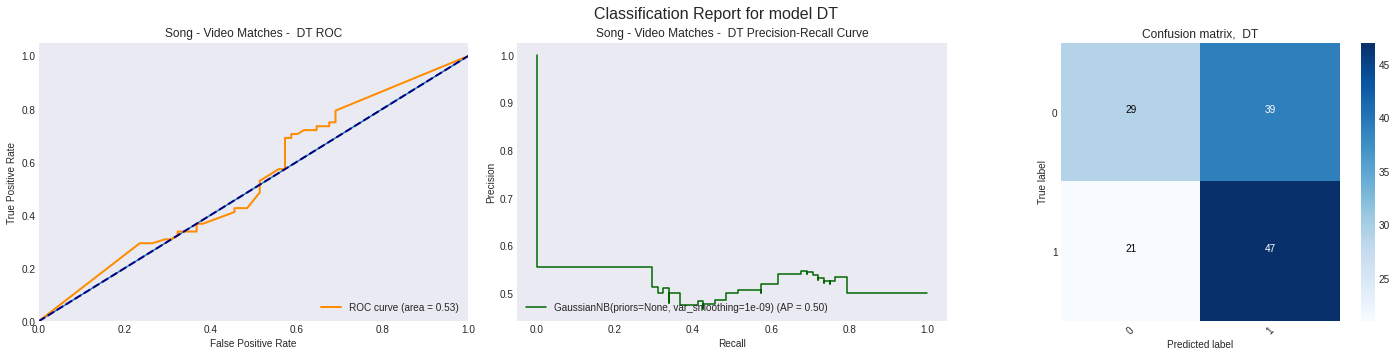

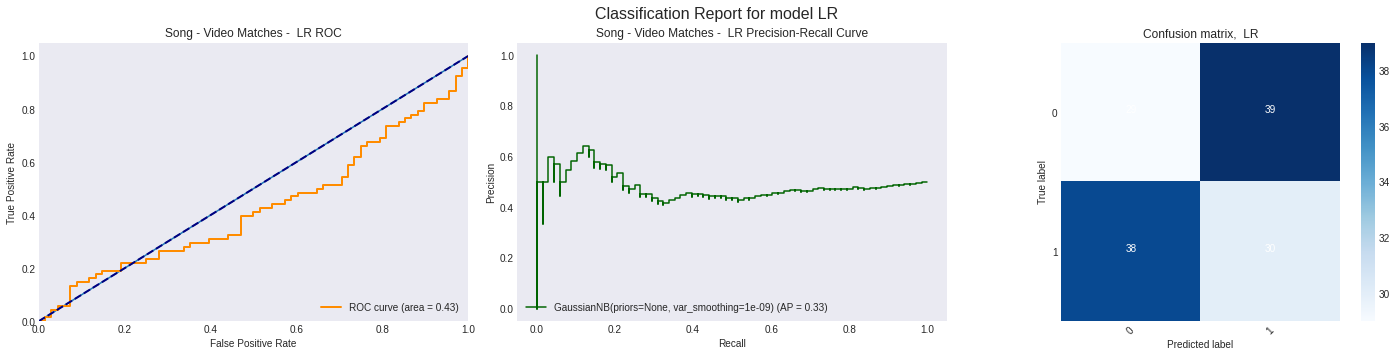

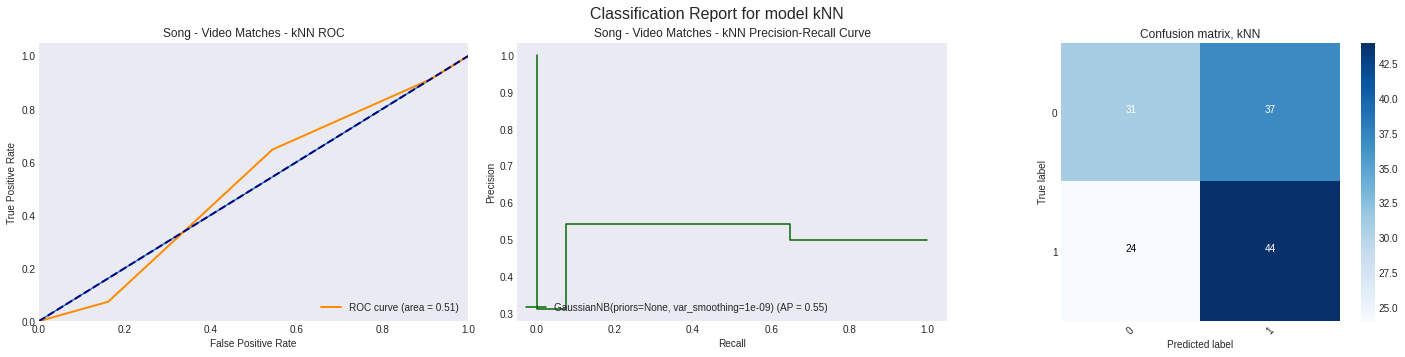

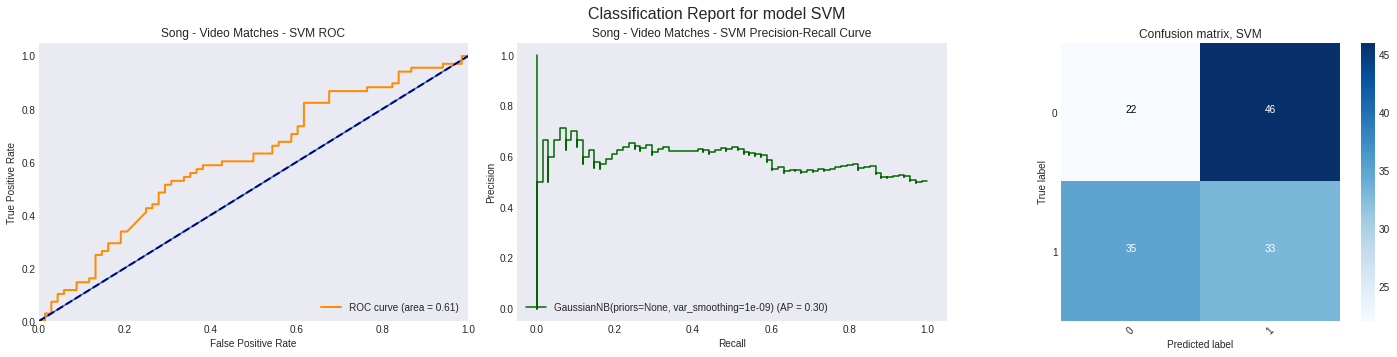

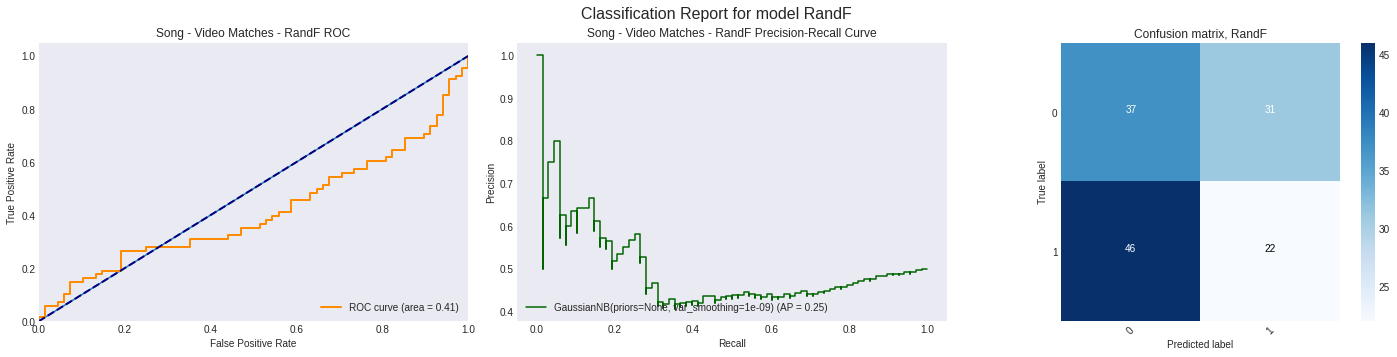

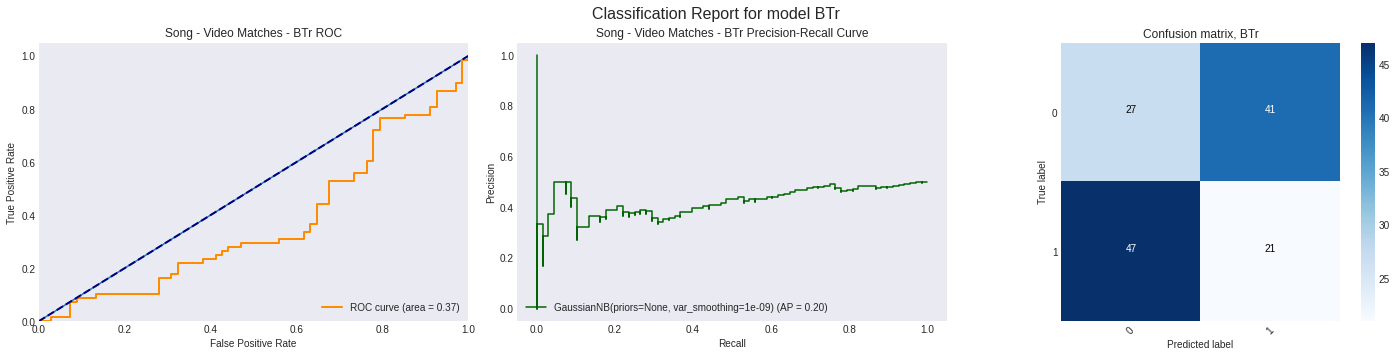

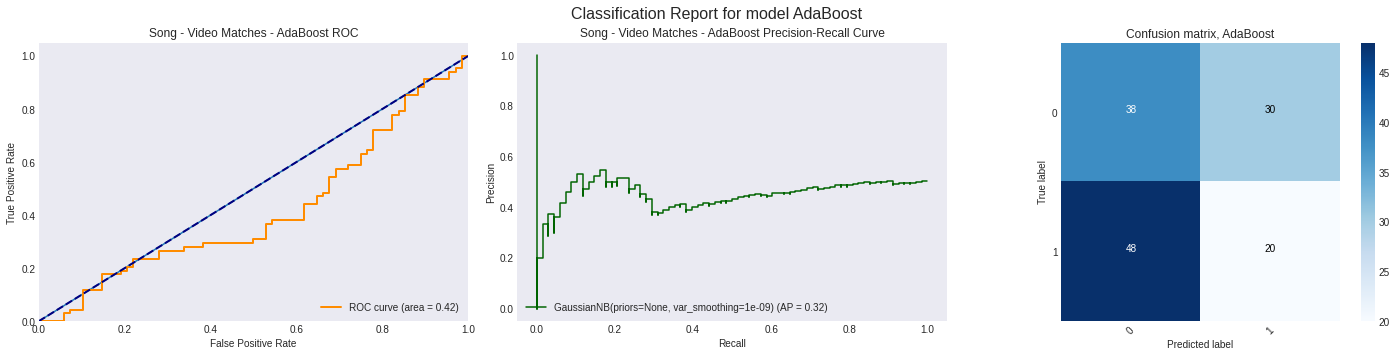

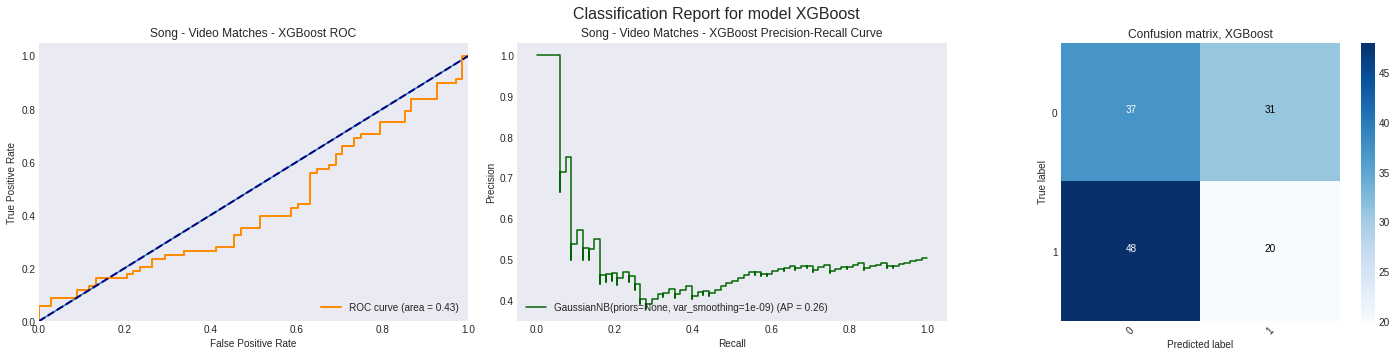

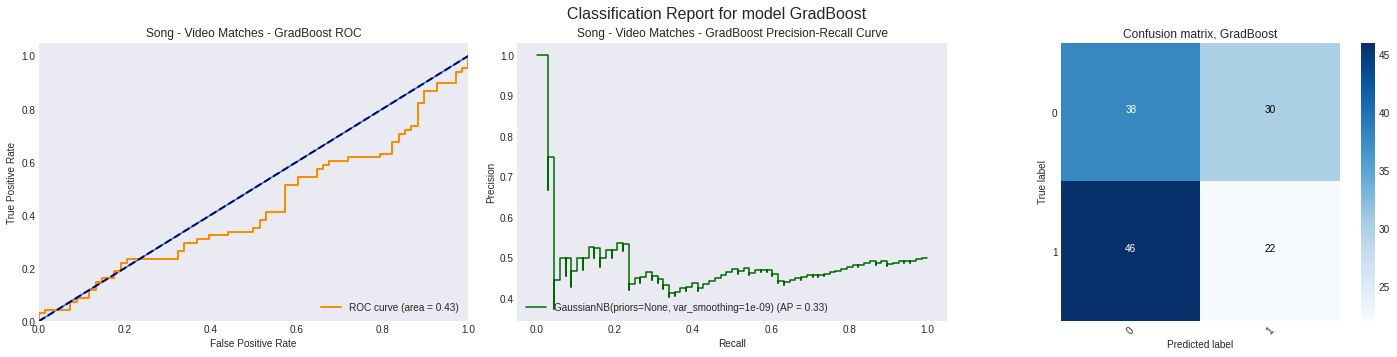

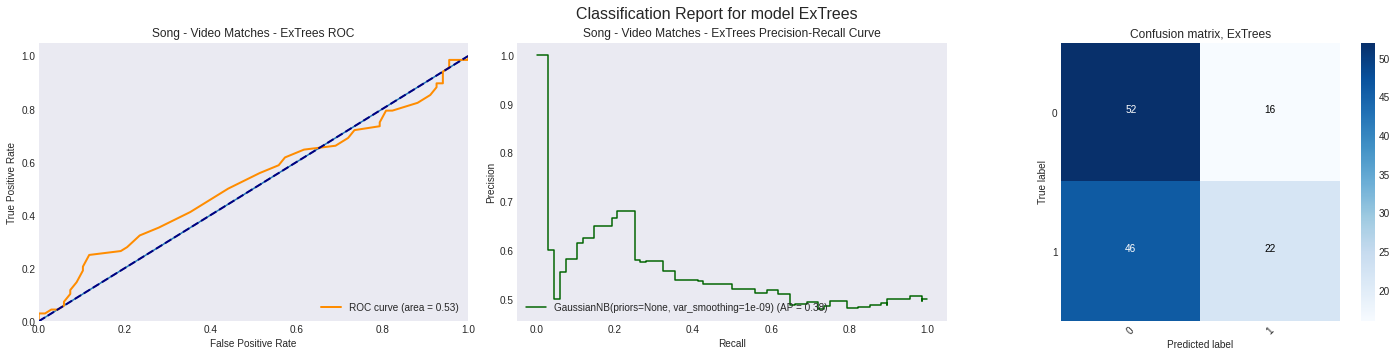

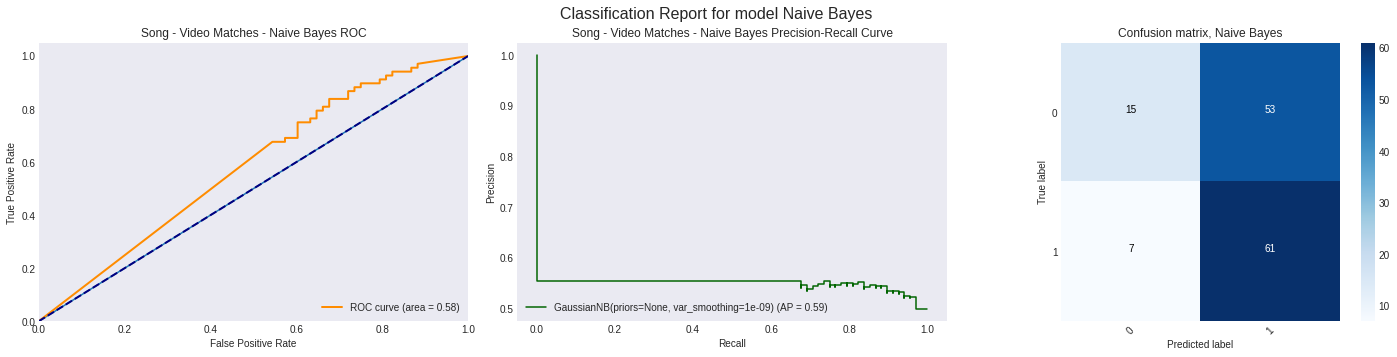

In [ ]:
get_results_and_plots(fold_results)

In [ ]:
get_model_comparison_mean(fold_results)

DT    LR   kNN   SVM  ...  XGBoost  GradBoost  ExTrees  Naive Bayes
accuracy   0.56  0.42  0.59  0.37  ...     0.44       0.43     0.56         0.62
precision  0.50  0.33  0.55  0.30  ...     0.26       0.33     0.38         0.59
recall     0.65  0.37  0.66  0.54  ...     0.28       0.33     0.35         0.93
f1         0.56  0.33  0.58  0.36  ...     0.26       0.32     0.34         0.70
roc        0.50  0.39  0.51  0.56  ...     0.41       0.41     0.48         0.58

[5 rows x 11 columns]

In [ ]:
get_model_comparison_std(fold_results)

DT    LR   kNN   SVM  ...  XGBoost  GradBoost  ExTrees  Naive Bayes
accuracy   0.35  0.33  0.31  0.25  ...     0.25       0.33     0.22         0.26
precision  0.38  0.39  0.37  0.29  ...     0.38       0.41     0.42         0.28
recall     0.45  0.43  0.41  0.48  ...     0.40       0.41     0.40         0.25
f1         0.39  0.38  0.36  0.32  ...     0.36       0.39     0.37         0.25
roc        0.39  0.40  0.38  0.39  ...     0.39       0.41     0.38         0.33

[5 rows x 11 columns]

In [ ]:
get_model_comparison_median(fold_results)

DT    LR   kNN   SVM  ...  XGBoost  GradBoost  ExTrees  Naive Bayes
accuracy   0.60  0.50  0.50  0.40  ...     0.40       0.50     0.50         0.50
precision  0.50  0.00  0.50  0.33  ...     0.00       0.00     0.33         0.50
recall     1.00  0.00  1.00  0.62  ...     0.00       0.00     0.20         1.00
f1         0.67  0.00  0.67  0.50  ...     0.00       0.00     0.29         0.67
roc        0.50  0.33  0.50  0.50  ...     0.42       0.33     0.50         0.58

[5 rows x 11 columns]

# Experiment 3
* Extreme Dimensionality Reduction - keep only first part of high correl pairs
* Vanilla Imputers
* Vanilla Classifiers

In [ ]:
data, X, y, groups = load_data()

empty_cols = [col for col in X.columns if (X[col] == 0).all()]
print('The number of columns with only zero values is: {}'.format(str(len(empty_cols))))
print('These are:')
for col in empty_cols:
    print(col)

The number of columns with only zero values is: 10
These are:
delta chroma_8_mean
QuintupleMeterFeature
ComposerPopularity
LanguageFeature
outdoor_freq
sports_freq
outdoor_mean_confidence
sports_mean_confidence
outdoor_mean_area_ratio
sports_mean_area_ratio


In [ ]:
print("We remove those from the dataset")
X = X.drop(empty_cols, axis=1)

We remove those from the dataset


In [ ]:
cols_with_nas = [col for col in X.columns if len(X[X[col].isna()])>0.4*len(X)]
if len(cols_with_nas) == 0:
    print("There are no columns with more than 40% empty values")
else:
    print("We have removed the following columns because they were more than 40% empty:")
    for col in cols_with_nas:
        print(col)
    X = X.drop(cols_with_nas, axis=1)


There are no columns with more than 40% empty values


In [ ]:
corr = X.corr(method='pearson')
corr_a = corr.abs()
s = corr_a.unstack().sort_values(kind="quicksort")
pairs = set(s[s > 0.7].index)
clean_pairs = set([tuple(sorted(i)) for i in pairs if i[0] != i[1]])
print('There are ' + str(len(clean_pairs)) + ' pairs with at least 80% correlation.')
print('The top 15 are:')
for pair in sorted(clean_pairs)[0:15]:
    print(pair)

There are 1057 pairs with at least 80% correlation.
The top 15 are:
('AmountOfArpeggiationFeature', 'AverageMelodicIntervalFeature')
('AmountOfArpeggiationFeature', 'MostCommonMelodicIntervalPrevalenceFeature')
('AmountOfArpeggiationFeature', 'RepeatedNotesFeature')
('AverageMelodicIntervalFeature', 'MaximumNumberOfIndependentVoicesFeature')
('AverageMelodicIntervalFeature', 'MostCommonMelodicIntervalPrevalenceFeature')
('AverageMelodicIntervalFeature', 'SizeOfMelodicArcsFeature')
('AverageMelodicIntervalFeature', 'VariabilityOfNumberOfIndependentVoicesFeature')
('AverageNoteDurationFeature', 'AverageTimeBetweenAttacksFeature')
('AverageNoteDurationFeature', 'VariabilityOfNoteDurationFeature')
('AverageNumberOfIndependentVoicesFeature', 'MaximumNumberOfIndependentVoicesFeature')
('AverageNumberOfIndependentVoicesFeature', 'VariabilityOfNumberOfIndependentVoicesFeature')
('AverageVariabilityOfTimeBetweenAttacksForEachVoiceFeature', 'MaximumNumberOfIndependentVoicesFeature')
('AverageVar

In [ ]:
singles = []
drops = []

# only keep one for each pair of highly correlated features.
for pair in sorted(clean_pairs):
    if pair[1] not in drops:
        drops.append(pair[1])
    if pair[0] not in drops and pair[0] not in singles:
        singles.append(pair[0])

X = X[singles]

In [ ]:
imp = SimpleImputer(missing_values=np.NaN, strategy='mean')
min_max_scaler = preprocessing.MinMaxScaler()


In [ ]:
#we choose a common seed for all algorithms
seed = 2015
#we choose a common number of trees for ensembles
num_trees = 100

models = [('DT', DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=seed)),
          ('LR', LogisticRegression(random_state=seed, solver='liblinear')),
          ('kNN', neighbors.KNeighborsClassifier(n_neighbors=3, weights='uniform', n_jobs=-1)),
          ('SVM', svm.SVC(kernel='rbf', C=1, gamma='auto', cache_size=12288, probability=True)),
          ('RandF',RandomForestClassifier(n_estimators=num_trees,max_depth=1,n_jobs=-1,random_state=seed)),
          ('BTr', BaggingClassifier(
              base_estimator=DecisionTreeClassifier( max_depth=1, random_state=seed),
              n_estimators=num_trees, random_state=seed, n_jobs=-1)),
          ('AdaBoost', AdaBoostClassifier(
              base_estimator=DecisionTreeClassifier( max_depth=1, random_state=seed),
              n_estimators=num_trees, random_state=seed)),
          ('XGBoost', XGBClassifier(nthread=8, use_label_encoder=False)),
          ('GradBoost', GradientBoostingClassifier(random_state=seed)),
          ('ExTrees', ExtraTreesClassifier(random_state=seed)),
          ('Naive Bayes', GaussianNB())
          ]

In [ ]:
fold_results = init_fold_results()
X = X.to_numpy()
y = y.to_numpy()
i = 0
for train_index, test_index in logo.split(X, y, groups):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]  
    # fit the transformations
    X_train = imp.fit_transform(X_train)
    X_test = imp.transform(X_test)

    X_train = min_max_scaler.fit_transform(X_train)
    X_test = min_max_scaler.transform(X_test)
    for name, model in models:
        # fit the model
        model.fit(X_train, y_train)
        predicted = model.predict(X_test)
        pred_proba = model.predict_proba(X_test)
        # gather metrics
        accuracy = model.score(X_test, y_test)
        precision = precision_score(y_test, predicted)
        recall = recall_score(y_test, predicted)
        f1 = f1_score(y_test, predicted)
        fpr, tpr, _ = roc_curve(y_test, pred_proba[:, 1], 1)
        roc_auc = auc(fpr, tpr)
        cm = confusion_matrix(y_test, predicted)
        fold_results[name]['accuracy'].append(accuracy)
        fold_results[name]['precision'].append(precision)
        fold_results[name]['recall'].append(recall)
        fold_results[name]['f1'].append(f1)
        fold_results[name]['roc'].append(np.nan_to_num(roc_auc))
        fold_results[name]['fpr'].append(fpr)
        fold_results[name]['tpr'].append(tpr)
        fold_results[name]['cm'].append(cm)
        fold_results[name]['total_y'].append(y_test)
        fold_results[name]['total_y_pred'].append(predicted)
        fold_results[name]['total_y_proba'].append(pred_proba)
    i+=1
    


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined a

DT
              precision    recall  f1-score   support

           0       0.50      0.65      0.56        68
           1       0.50      0.35      0.41        68

    accuracy                           0.50       136
   macro avg       0.50      0.50      0.49       136
weighted avg       0.50      0.50      0.49       136

LR
              precision    recall  f1-score   support

           0       0.42      0.41      0.42        68
           1       0.43      0.44      0.43        68

    accuracy                           0.43       136
   macro avg       0.43      0.43      0.43       136
weighted avg       0.43      0.43      0.43       136

kNN
              precision    recall  f1-score   support

           0       0.57      0.44      0.50        68
           1       0.54      0.66      0.60        68

    accuracy                           0.55       136
   macro avg       0.55      0.55      0.55       136
weighted avg       0.55      0.55      0.55       136

SVM
     

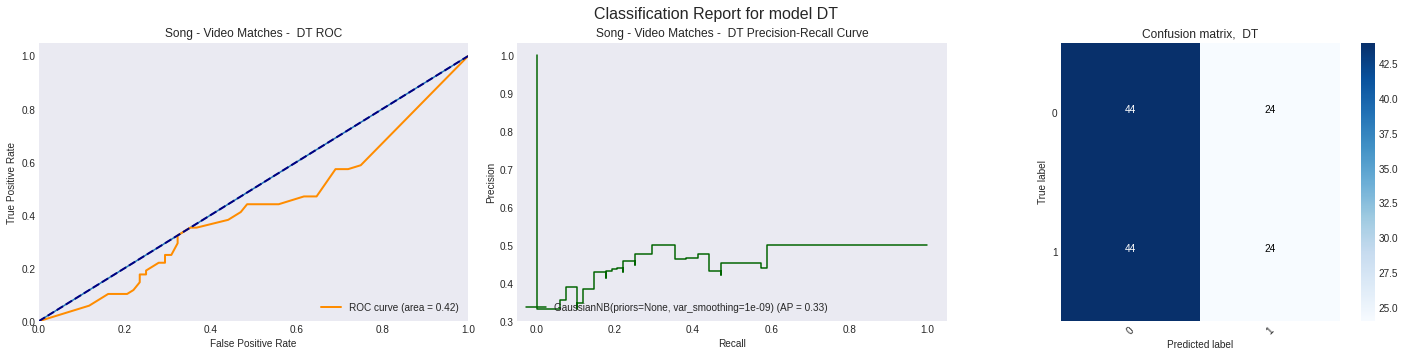

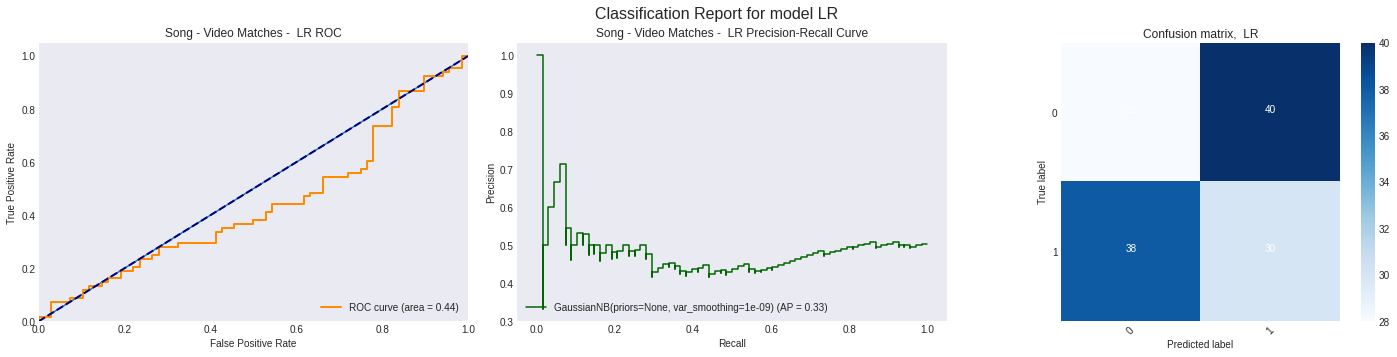

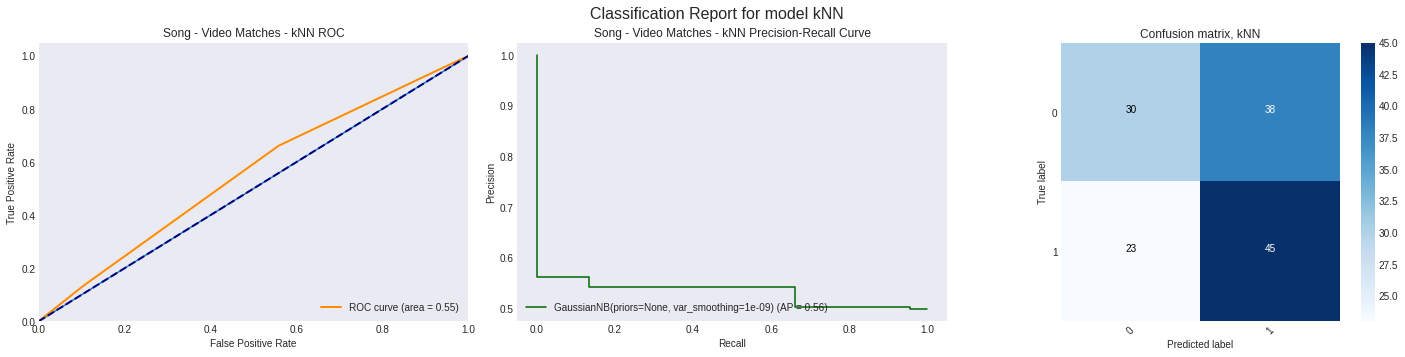

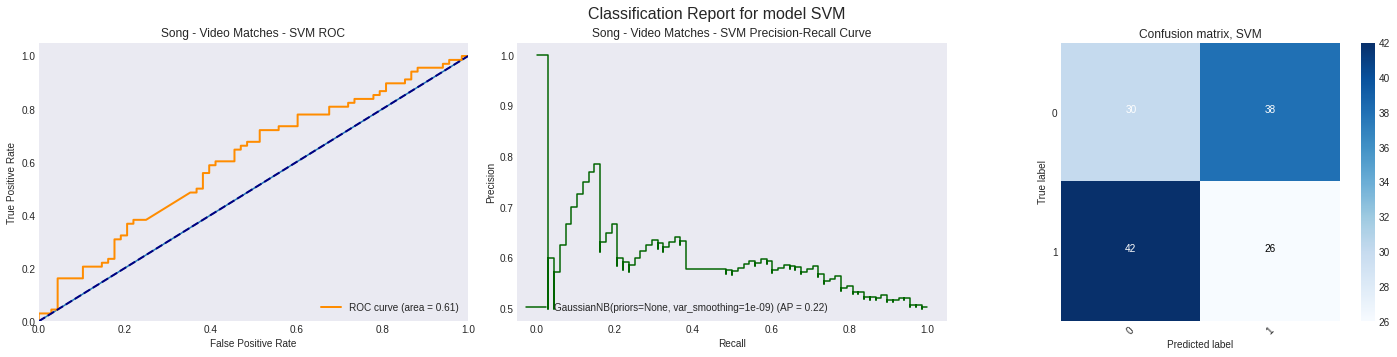

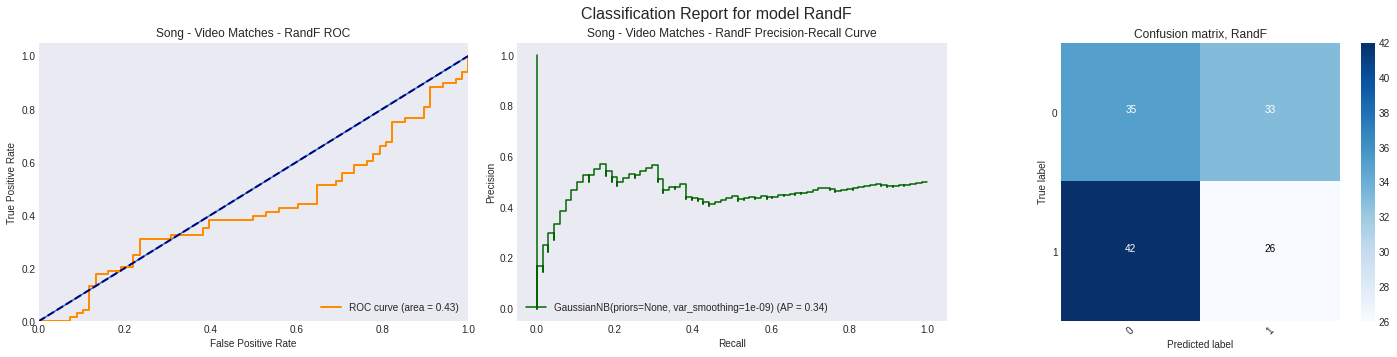

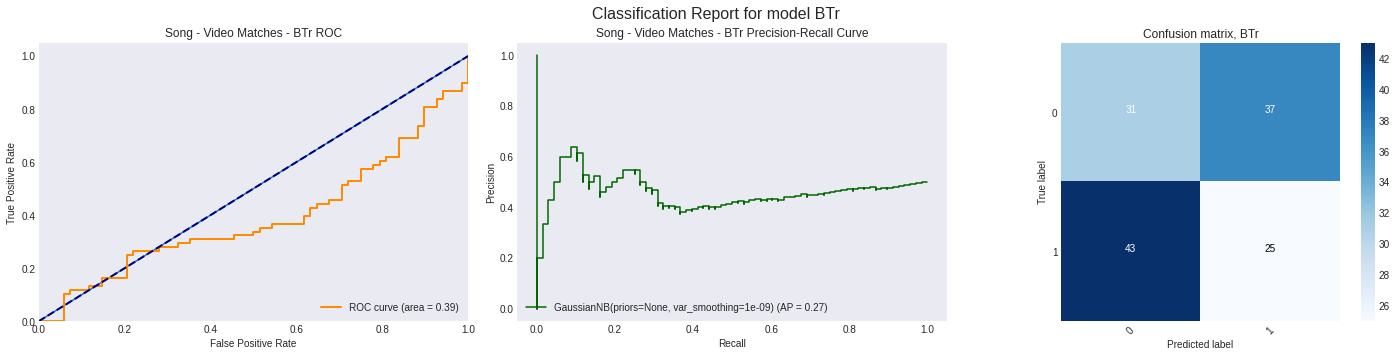

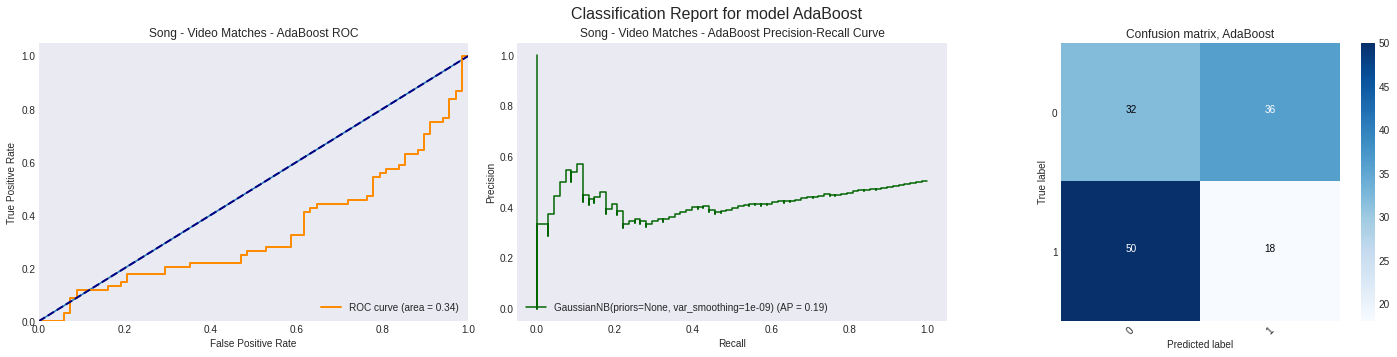

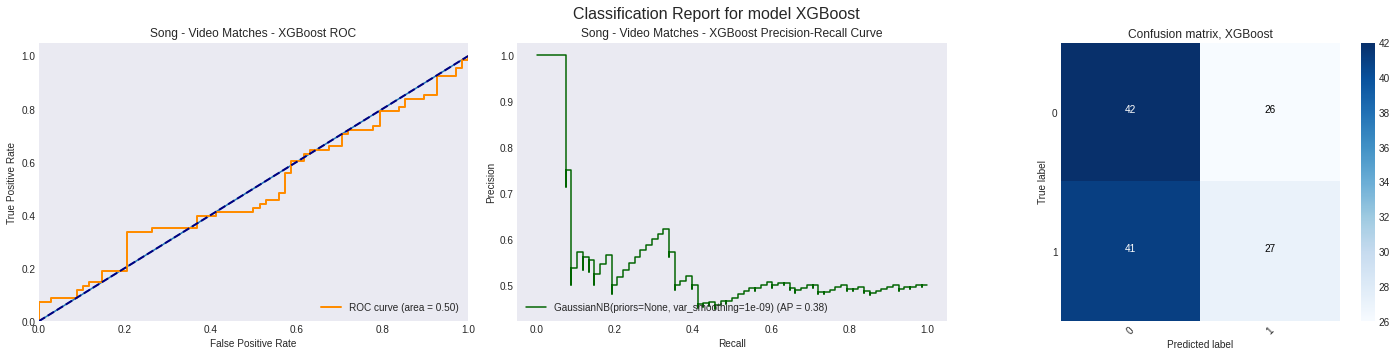

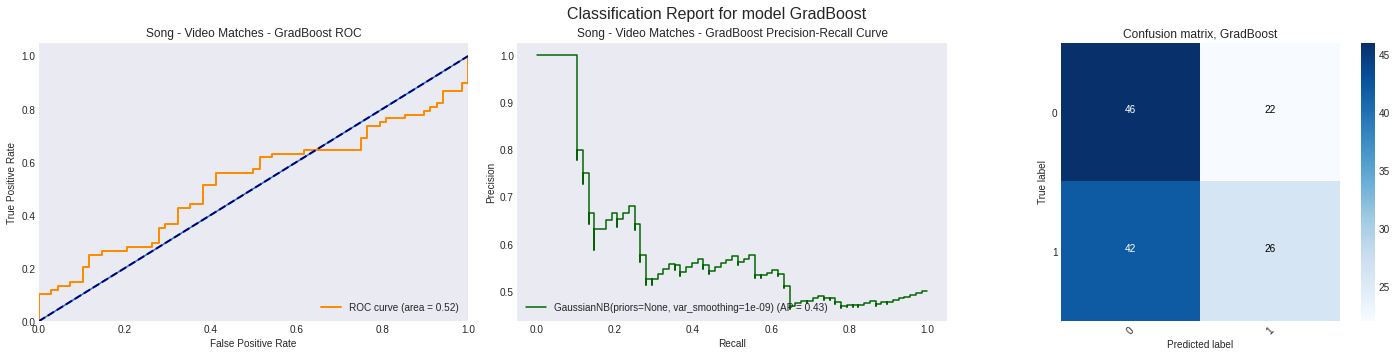

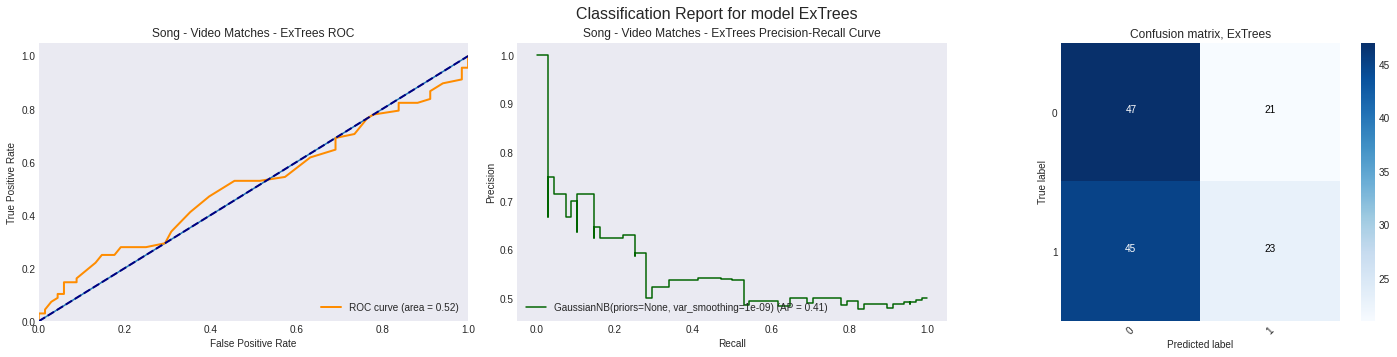

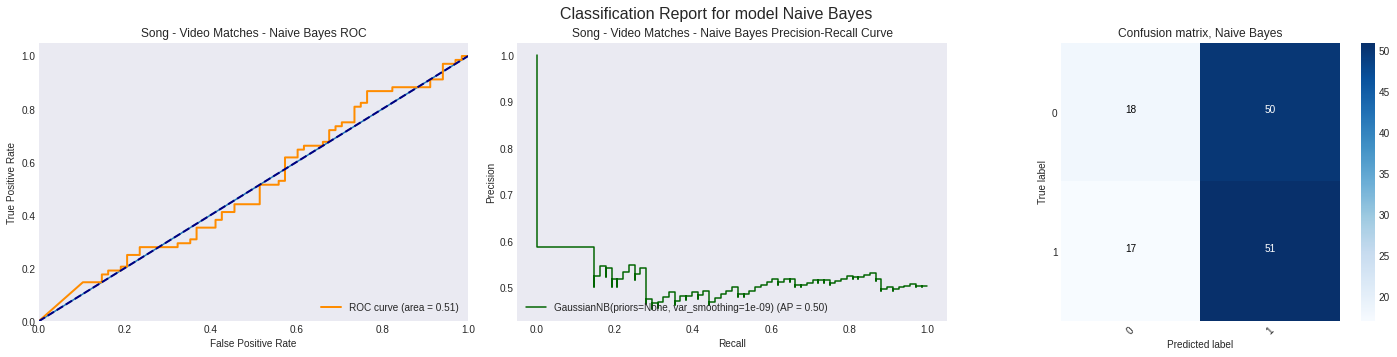

In [ ]:
get_results_and_plots(fold_results)

In [ ]:
get_model_comparison_mean(fold_results)

DT    LR   kNN   SVM  ...  XGBoost  GradBoost  ExTrees  Naive Bayes
accuracy   0.50  0.41  0.60  0.39  ...     0.53       0.56     0.56         0.54
precision  0.33  0.33  0.56  0.22  ...     0.38       0.43     0.41         0.50
recall     0.42  0.37  0.69  0.42  ...     0.41       0.39     0.35         0.83
f1         0.34  0.33  0.59  0.26  ...     0.38       0.39     0.36         0.61
roc        0.40  0.36  0.56  0.55  ...     0.47       0.56     0.42         0.38

[5 rows x 11 columns]

In [ ]:
get_model_comparison_std(fold_results)

DT    LR   kNN   SVM  ...  XGBoost  GradBoost  ExTrees  Naive Bayes
accuracy   0.25  0.28  0.31  0.19  ...     0.29       0.29     0.28         0.26
precision  0.37  0.38  0.36  0.26  ...     0.41       0.45     0.46         0.27
recall     0.46  0.41  0.39  0.48  ...     0.43       0.41     0.40         0.35
f1         0.36  0.35  0.35  0.29  ...     0.40       0.40     0.40         0.28
roc        0.26  0.39  0.38  0.41  ...     0.39       0.42     0.39         0.33

[5 rows x 11 columns]

In [ ]:
get_model_comparison_median(fold_results)

DT    LR   kNN   SVM  ...  XGBoost  GradBoost  ExTrees  Naive Bayes
accuracy   0.50  0.50  0.56  0.40  ...     0.50       0.50     0.50         0.50
precision  0.33  0.25  0.50  0.00  ...     0.33       0.50     0.12         0.50
recall     0.25  0.30  1.00  0.00  ...     0.50       0.30     0.10         1.00
f1         0.31  0.27  0.67  0.00  ...     0.33       0.33     0.11         0.67
roc        0.50  0.33  0.50  0.52  ...     0.50       0.50     0.50         0.41

[5 rows x 11 columns]

# Experiment Mutual Info

* Keep top 25% of features based on Mutual Info

In [ ]:
data, X, y, groups = load_data()
imp = SimpleImputer(missing_values=np.NaN, strategy='mean')
min_max_scaler = preprocessing.MinMaxScaler()


In [ ]:
#we choose a common seed for all algorithms
seed = 2015
#we choose a common number of trees for ensembles
num_trees = 100

models = [('DT', DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=seed)),
          ('LR', LogisticRegression(random_state=seed, solver='liblinear')),
          ('kNN', neighbors.KNeighborsClassifier(n_neighbors=3, weights='uniform', n_jobs=-1)),
          ('SVM', svm.SVC(kernel='rbf', C=1, gamma='auto', cache_size=12288, probability=True)),
          ('RandF',RandomForestClassifier(n_estimators=num_trees,max_depth=1,n_jobs=-1,random_state=seed)),
          ('BTr', BaggingClassifier(
              base_estimator=DecisionTreeClassifier( max_depth=1, random_state=seed),
              n_estimators=num_trees, random_state=seed, n_jobs=-1)),
          ('AdaBoost', AdaBoostClassifier(
              base_estimator=DecisionTreeClassifier( max_depth=1, random_state=seed),
              n_estimators=num_trees, random_state=seed)),
          ('XGBoost', XGBClassifier(nthread=8, use_label_encoder=False)),
          ('GradBoost', GradientBoostingClassifier(random_state=seed)),
          ('ExTrees', ExtraTreesClassifier(random_state=seed)),
          ('Naive Bayes', GaussianNB())
          ]

In [ ]:
fold_results = init_fold_results()
i = 0
X = X.to_numpy()
y = y.to_numpy()
for train_index, test_index in logo.split(X, y, groups):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index] 
    # fit the transformations   
    X_train = imp.fit_transform(X_train)
    X_test = imp.transform(X_test)
    
    selector = SelectKBest(mutual_info_classif, k=150) 
    X_train = selector.fit_transform(X_train, y_train)
    X_test = selector.transform(X_test)
    
    X_train = min_max_scaler.fit_transform(X_train)
    X_test = min_max_scaler.transform(X_test)
    for name, model in models:
        # fit the model
        model.fit(X_train, y_train)
        predicted = model.predict(X_test)
        pred_proba = model.predict_proba(X_test)
        # gather metrics
        accuracy = model.score(X_test, y_test)
        precision = precision_score(y_test, predicted)
        recall = recall_score(y_test, predicted)
        f1 = f1_score(y_test, predicted)
        fpr, tpr, _ = roc_curve(y_test, pred_proba[:, 1], 1)
        roc_auc = auc(fpr, tpr)
        cm = confusion_matrix(y_test, predicted)
        fold_results[name]['accuracy'].append(accuracy)
        fold_results[name]['precision'].append(precision)
        fold_results[name]['recall'].append(recall)
        fold_results[name]['f1'].append(f1)
        fold_results[name]['roc'].append(np.nan_to_num(roc_auc))
        fold_results[name]['fpr'].append(fpr)
        fold_results[name]['tpr'].append(tpr)
        fold_results[name]['cm'].append(cm)
        fold_results[name]['total_y'].append(y_test)
        fold_results[name]['total_y_pred'].append(predicted)
        fold_results[name]['total_y_proba'].append(pred_proba)
    i+=1
    


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined a

DT
              precision    recall  f1-score   support

           0       0.43      0.49      0.46        68
           1       0.41      0.35      0.38        68

    accuracy                           0.42       136
   macro avg       0.42      0.42      0.42       136
weighted avg       0.42      0.42      0.42       136

LR
              precision    recall  f1-score   support

           0       0.49      0.54      0.51        68
           1       0.48      0.43      0.45        68

    accuracy                           0.49       136
   macro avg       0.49      0.49      0.48       136
weighted avg       0.49      0.49      0.48       136

kNN
              precision    recall  f1-score   support

           0       0.53      0.49      0.51        68
           1       0.53      0.57      0.55        68

    accuracy                           0.53       136
   macro avg       0.53      0.53      0.53       136
weighted avg       0.53      0.53      0.53       136

SVM
     

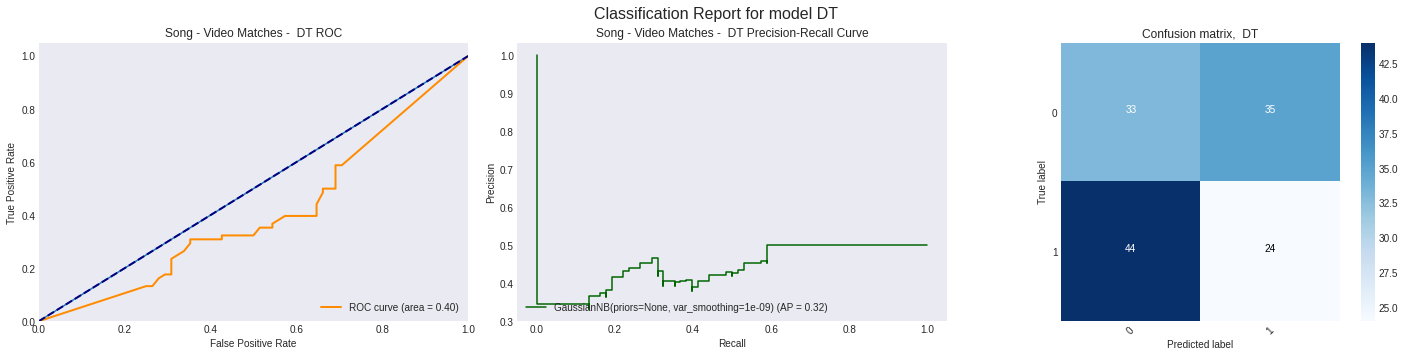

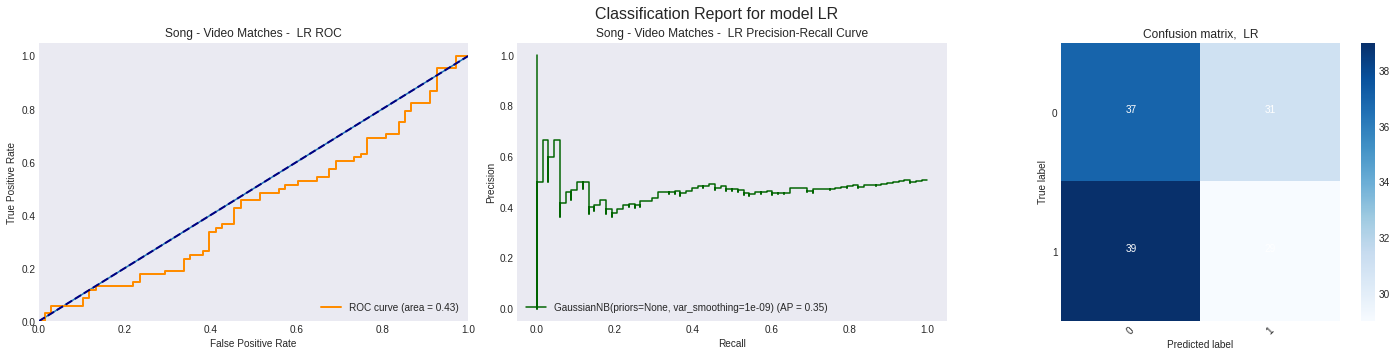

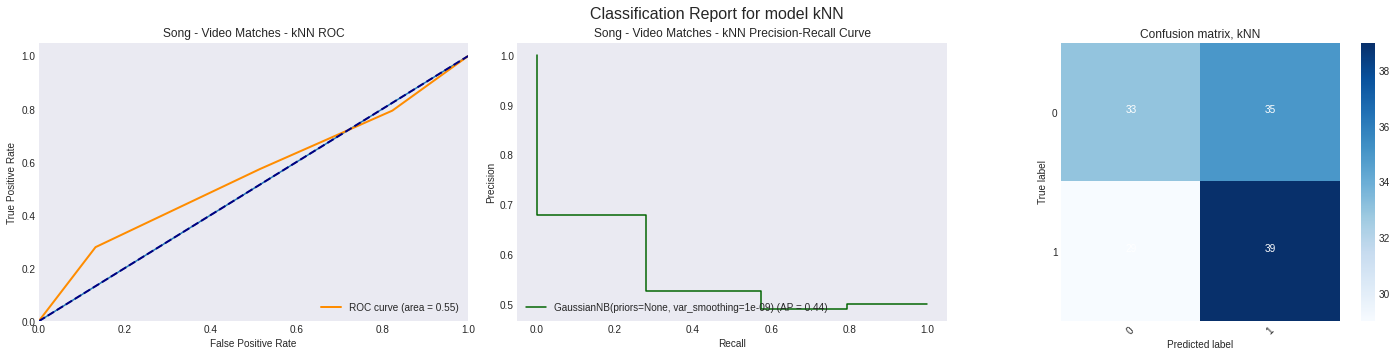

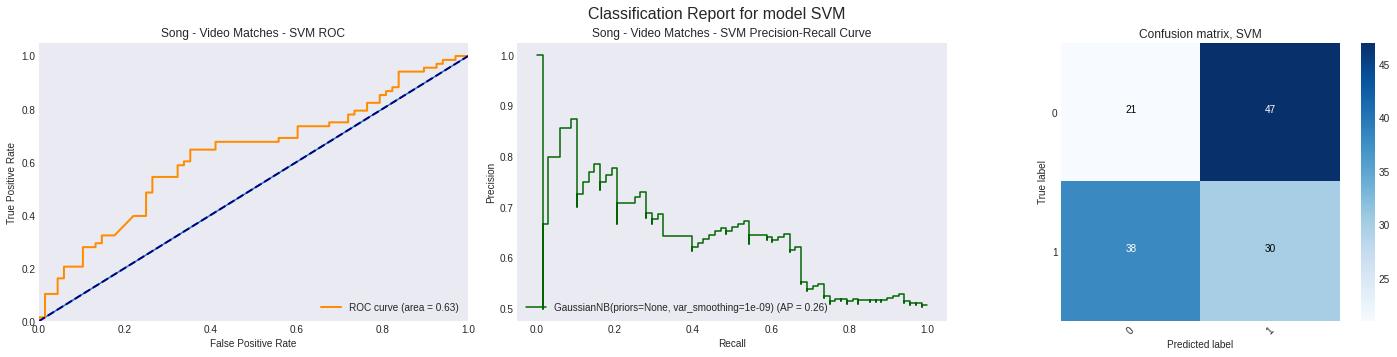

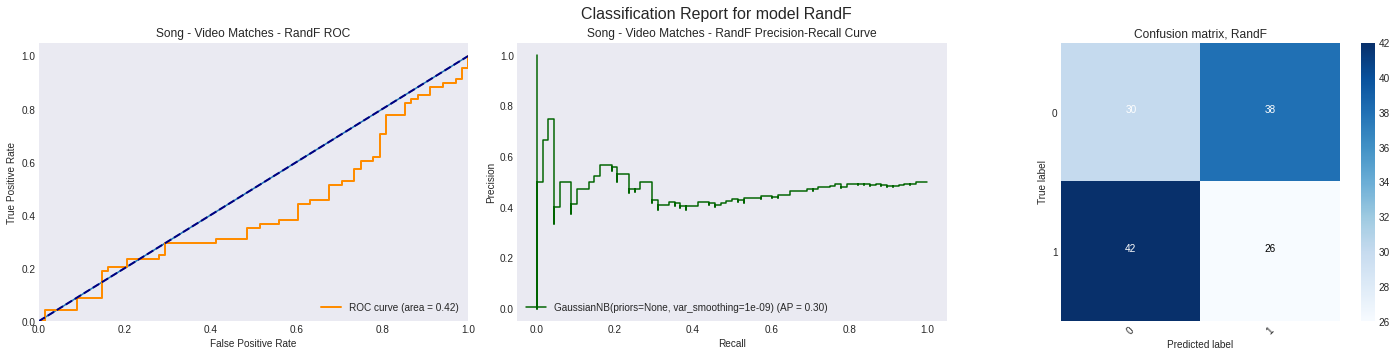

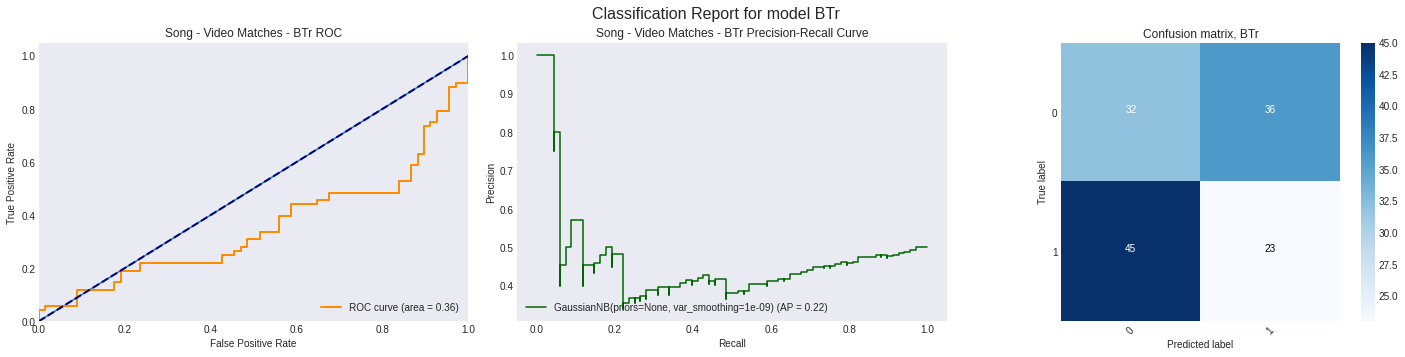

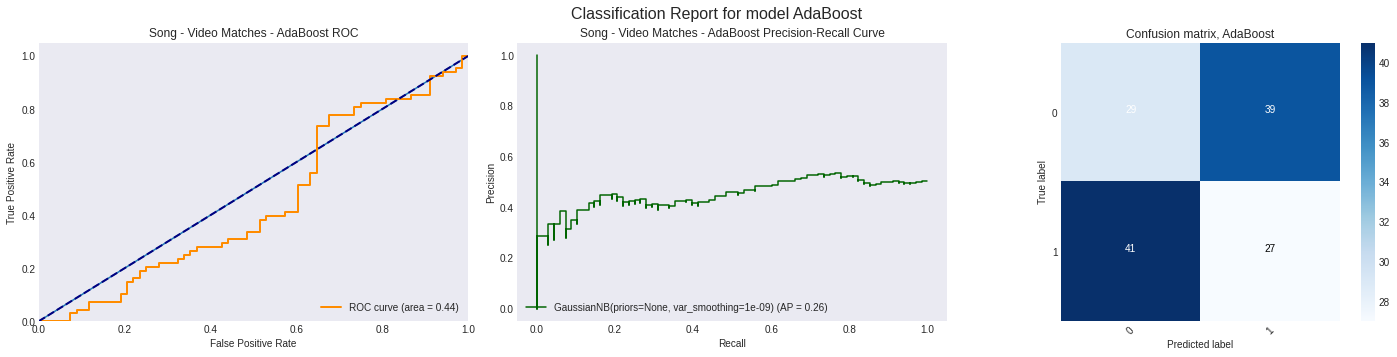

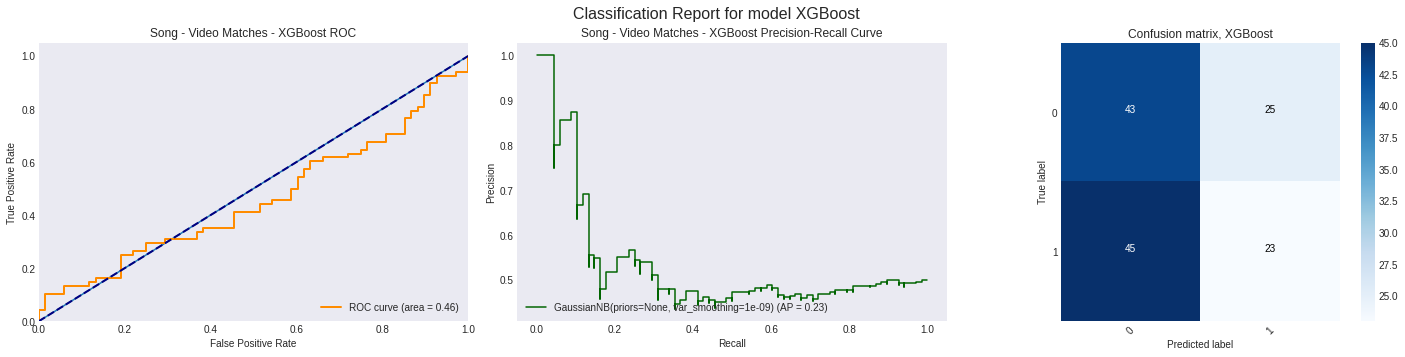

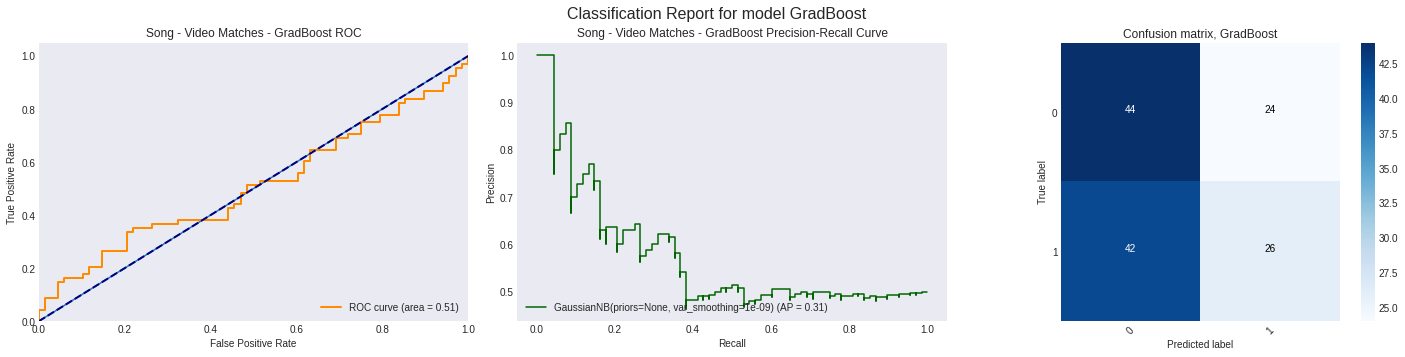

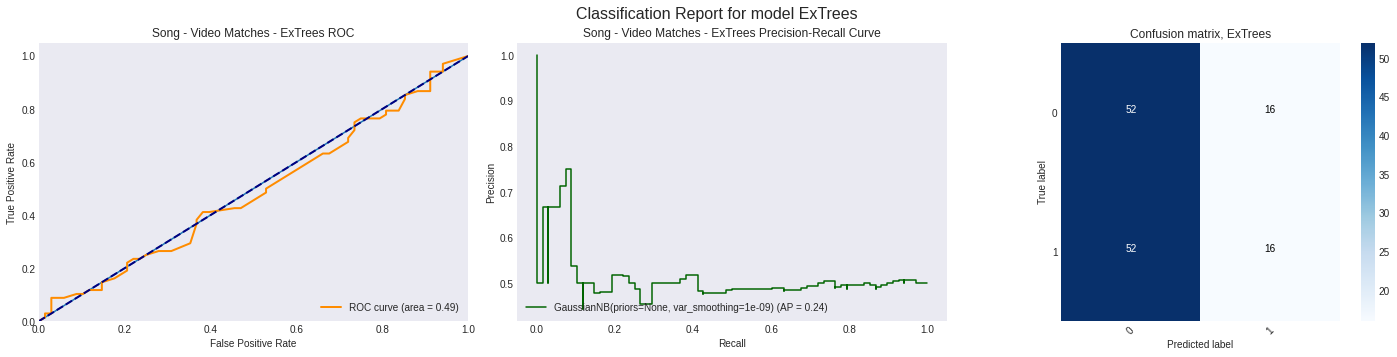

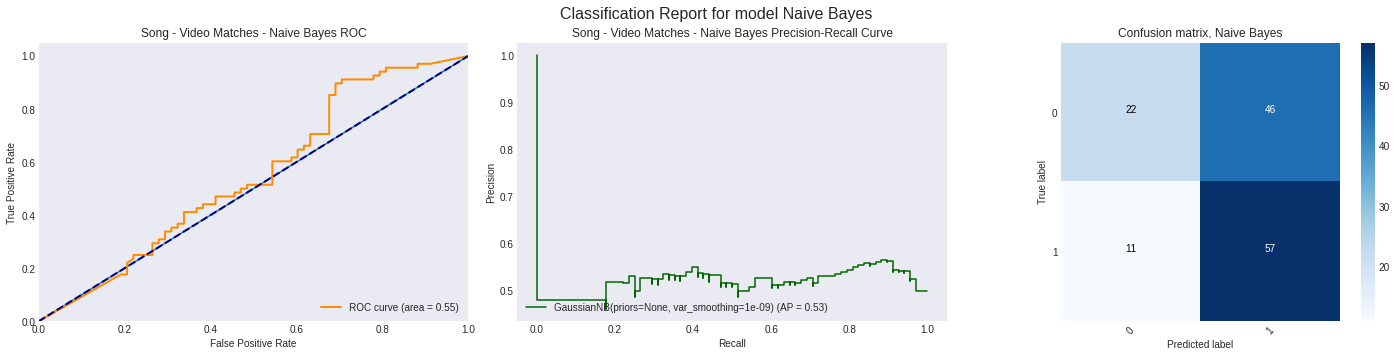

In [ ]:
get_results_and_plots(fold_results)

In [ ]:
get_model_comparison_mean(fold_results)

DT    LR   kNN   SVM  ...  XGBoost  GradBoost  ExTrees  Naive Bayes
accuracy   0.38  0.44  0.51  0.35  ...     0.44       0.48     0.49         0.57
precision  0.32  0.35  0.44  0.26  ...     0.23       0.31     0.24         0.53
recall     0.37  0.39  0.59  0.48  ...     0.26       0.33     0.23         0.81
f1         0.32  0.35  0.47  0.32  ...     0.23       0.31     0.22         0.62
roc        0.35  0.39  0.52  0.55  ...     0.41       0.52     0.40         0.53

[5 rows x 11 columns]

In [ ]:
get_model_comparison_std(fold_results)

DT    LR   kNN   SVM  ...  XGBoost  GradBoost  ExTrees  Naive Bayes
accuracy   0.31  0.31  0.30  0.26  ...     0.23       0.29     0.23         0.28
precision  0.39  0.39  0.37  0.28  ...     0.32       0.39     0.38         0.32
recall     0.44  0.43  0.46  0.48  ...     0.36       0.41     0.38         0.37
f1         0.37  0.37  0.37  0.32  ...     0.31       0.38     0.35         0.31
roc        0.36  0.40  0.38  0.42  ...     0.41       0.41     0.37         0.37

[5 rows x 11 columns]

In [ ]:
get_model_comparison_median(fold_results)

DT    LR   kNN   SVM  ...  XGBoost  GradBoost  ExTrees  Naive Bayes
accuracy   0.40  0.50  0.50  0.33  ...     0.50        0.5      0.5         0.50
precision  0.00  0.25  0.50  0.25  ...     0.00        0.0      0.0         0.50
recall     0.00  0.20  1.00  0.50  ...     0.00        0.0      0.0         1.00
f1         0.00  0.22  0.67  0.40  ...     0.00        0.0      0.0         0.67
roc        0.25  0.33  0.50  0.67  ...     0.33        0.5      0.5         0.50

[5 rows x 11 columns]

# Experiment PCA
* Standardized Data
* Dimensionality Reduction - PCA
* Vanilla Imputer
* Vanilla Classifier

In [ ]:
data, X, y, groups = load_data()

In [ ]:
imp = SimpleImputer(missing_values=np.NaN, strategy='mean')
standardise = preprocessing.StandardScaler()


In [ ]:
#we choose a common seed for all algorithms
seed = 2015
#we choose a common number of trees for ensembles
num_trees = 100

models = [('DT', DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=seed)),
          ('LR', LogisticRegression(random_state=seed, solver='liblinear')),
          ('kNN', neighbors.KNeighborsClassifier(n_neighbors=3, weights='uniform', n_jobs=-1)),
          ('SVM', svm.SVC(kernel='rbf', C=1, gamma='auto', cache_size=12288, probability=True)),
          ('RandF',RandomForestClassifier(n_estimators=num_trees,max_depth=1,n_jobs=-1,random_state=seed)),
          ('BTr', BaggingClassifier(
              base_estimator=DecisionTreeClassifier( max_depth=1, random_state=seed),
              n_estimators=num_trees, random_state=seed, n_jobs=-1)),
          ('AdaBoost', AdaBoostClassifier(
              base_estimator=DecisionTreeClassifier( max_depth=1, random_state=seed),
              n_estimators=num_trees, random_state=seed)),
          ('XGBoost', XGBClassifier(nthread=8, use_label_encoder=False)),
          ('GradBoost', GradientBoostingClassifier(random_state=seed)),
          ('ExTrees', ExtraTreesClassifier(random_state=seed)),
          ('Naive Bayes', GaussianNB())
          ]

In [ ]:
def plot_PCA_explained_variance(explained_variance_ratio):
    plt.figure(figsize=(15,10))
    plt.plot(np.cumsum(explained_variance_ratio), marker = 'D', markerfacecolor='red', markevery=100)
    plt.xlabel('Number of Components')
    plt.ylabel('Variance (%)') #for each component
    plt.title('Explained Variance')
    plt.yticks(np.arange(0.00,1.02,0.02))
    plt.grid()
    plt.show()


In [ ]:
fold_results = init_fold_results()
i = 0
for train_index, test_index in logo.split(X, y, groups):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # fit the transformations
    X_train = imp.fit_transform(X_train)
    X_test = imp.transform(X_test)

    X_train = standardise.fit_transform(X_train)
    X_test = standardise.transform(X_test)

    pca = PCA(copy = True, svd_solver='arpack')
    
    #transform train data
    X_train = pca.fit_transform(X_train)
    #transform test data
    X_test = pca.transform(X_test)
    
    for name, model in models:
        # fit the model
        model.fit(X_train, y_train)
        predicted = model.predict(X_test)
        pred_proba = model.predict_proba(X_test)
        # gather metrics
        accuracy = model.score(X_test, y_test)
        precision = precision_score(y_test, predicted)
        recall = recall_score(y_test, predicted)
        f1 = f1_score(y_test, predicted)
        fpr, tpr, _ = roc_curve(y_test, pred_proba[:, 1], 1)
        roc_auc = auc(fpr, tpr)
        cm = confusion_matrix(y_test, predicted)
        fold_results[name]['accuracy'].append(accuracy)
        fold_results[name]['precision'].append(precision)
        fold_results[name]['recall'].append(recall)
        fold_results[name]['f1'].append(f1)
        fold_results[name]['roc'].append(np.nan_to_num(roc_auc))
        fold_results[name]['fpr'].append(fpr)
        fold_results[name]['tpr'].append(tpr)
        fold_results[name]['cm'].append(cm)
        fold_results[name]['total_y'].append(y_test)
        fold_results[name]['total_y_pred'].append(predicted)
        fold_results[name]['total_y_proba'].append(pred_proba)
    i+=1
    


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined a

DT
              precision    recall  f1-score   support

           0       0.46      0.46      0.46        68
           1       0.46      0.46      0.46        68

    accuracy                           0.46       136
   macro avg       0.46      0.46      0.46       136
weighted avg       0.46      0.46      0.46       136

LR
              precision    recall  f1-score   support

           0       0.46      0.49      0.47        68
           1       0.46      0.44      0.45        68

    accuracy                           0.46       136
   macro avg       0.46      0.46      0.46       136
weighted avg       0.46      0.46      0.46       136

kNN
              precision    recall  f1-score   support

           0       0.49      0.47      0.48        68
           1       0.49      0.51      0.50        68

    accuracy                           0.49       136
   macro avg       0.49      0.49      0.49       136
weighted avg       0.49      0.49      0.49       136

SVM
     

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


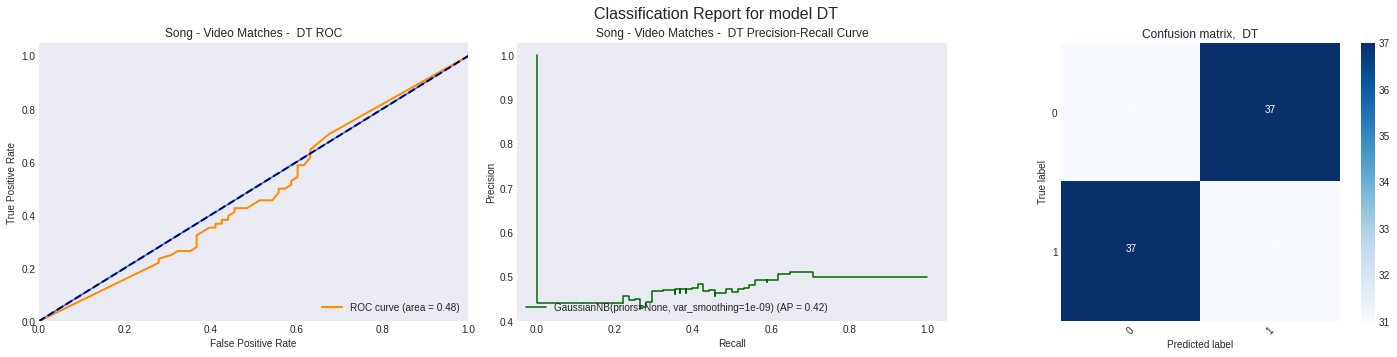

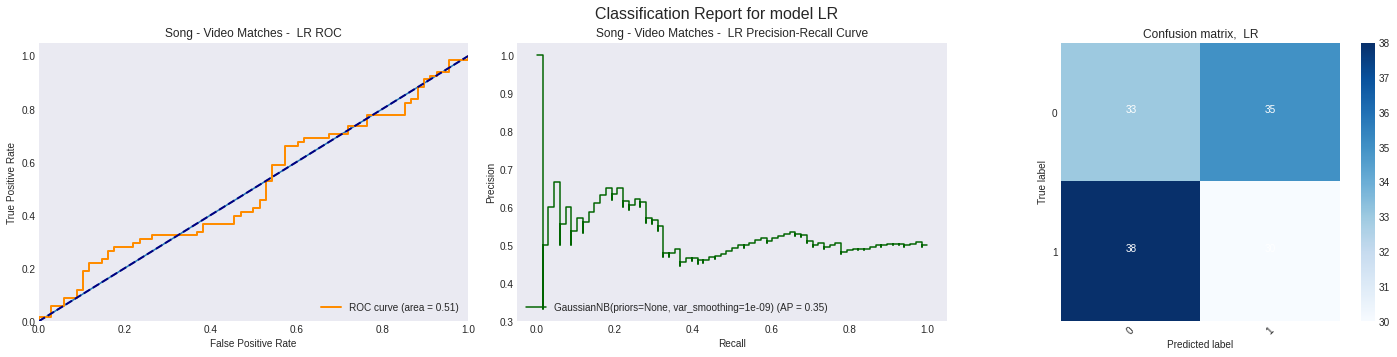

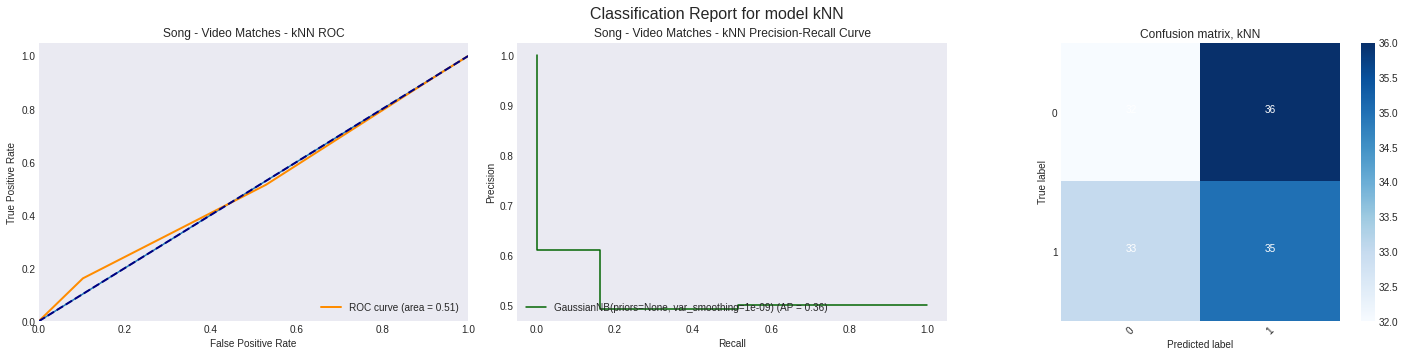

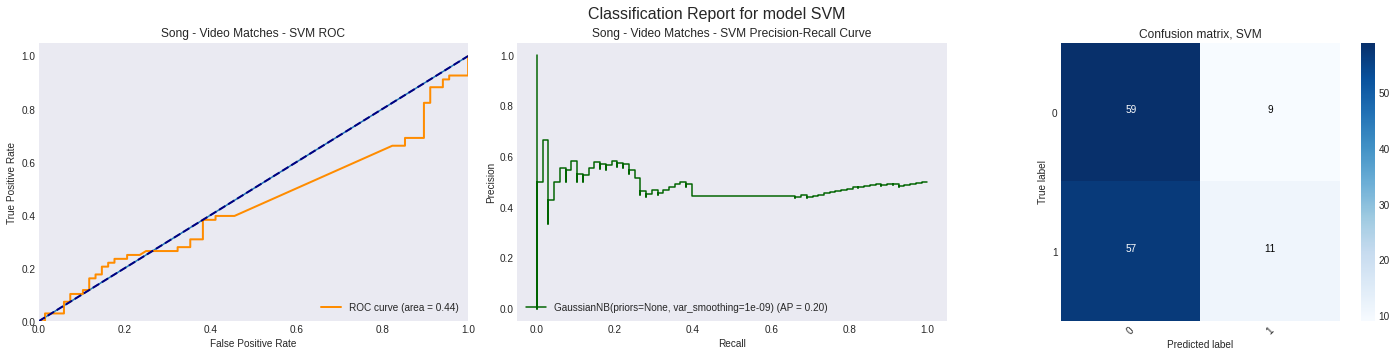

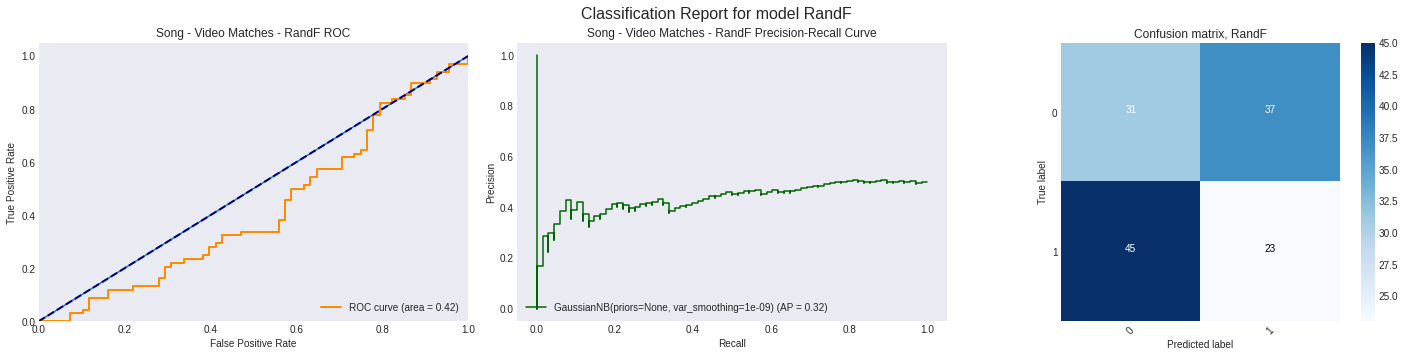

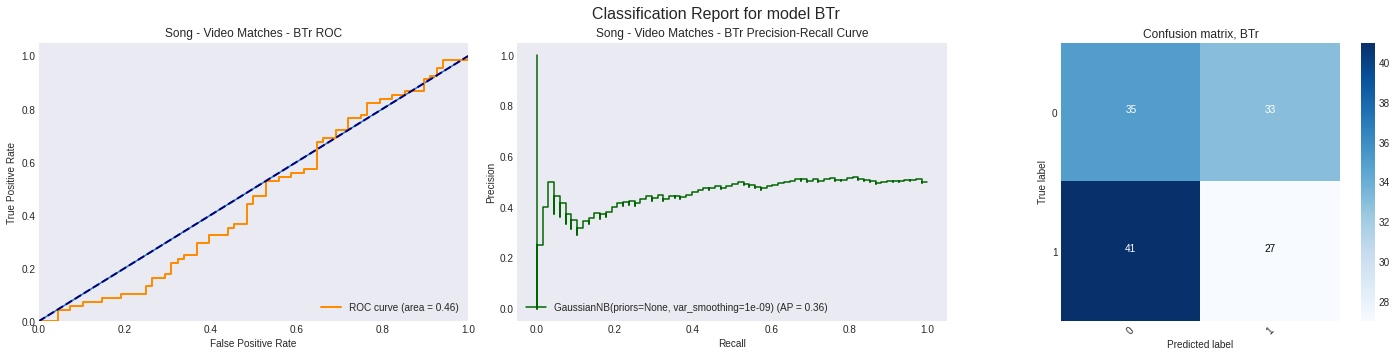

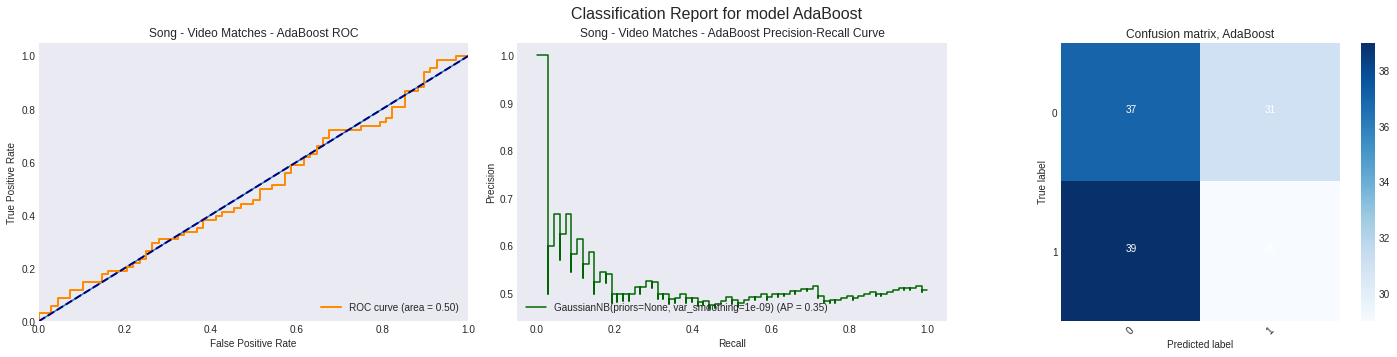

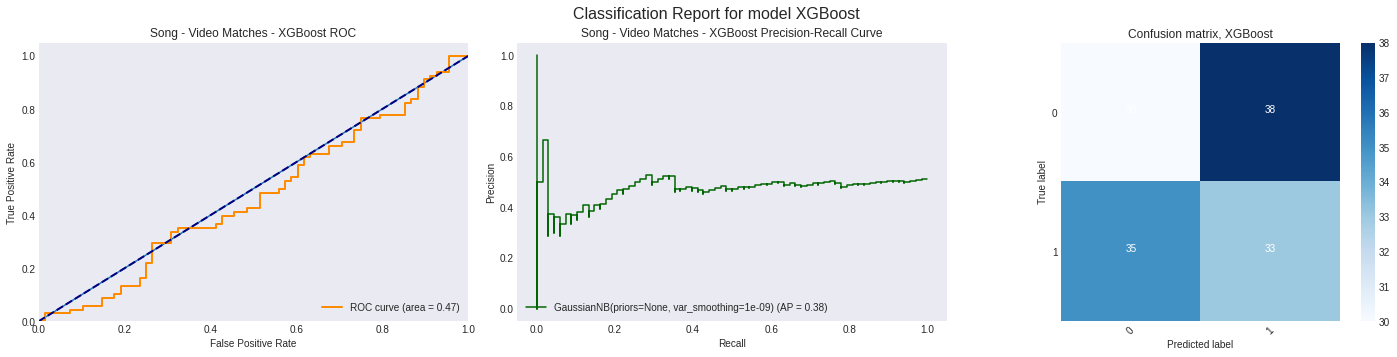

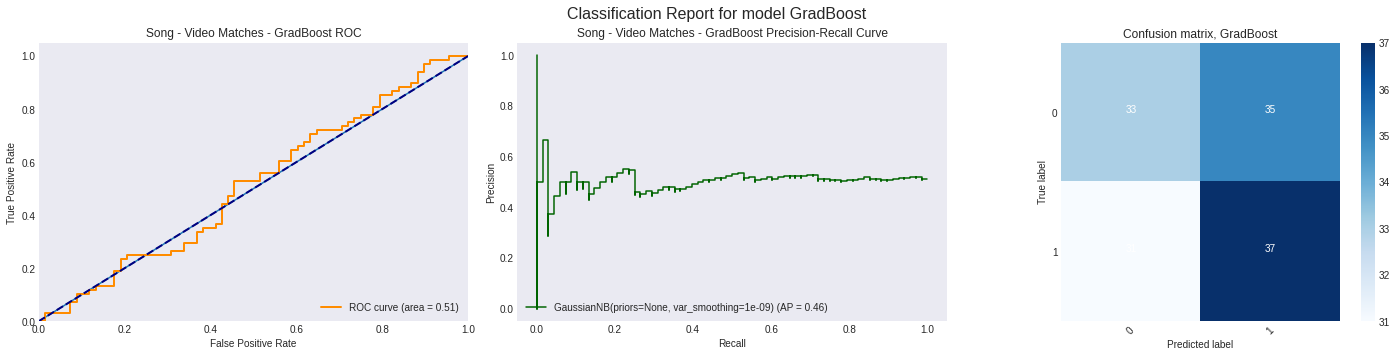

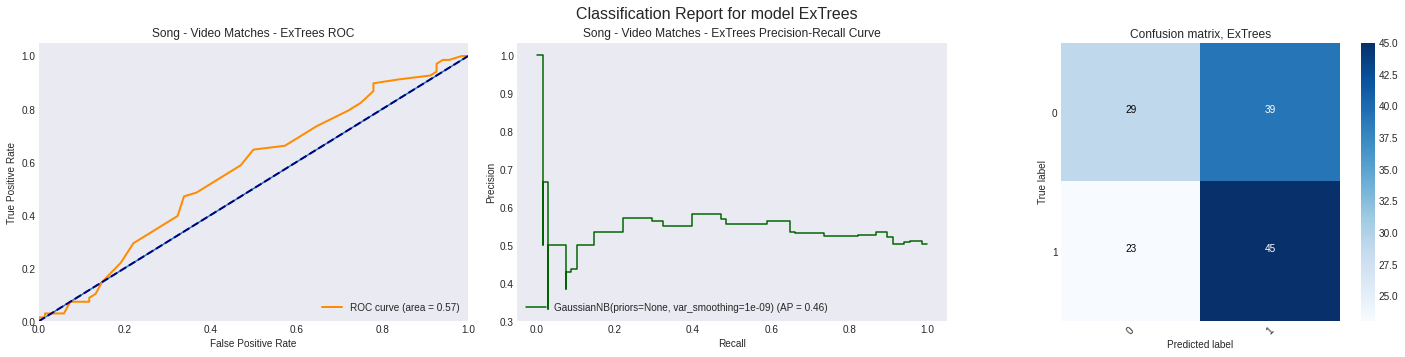

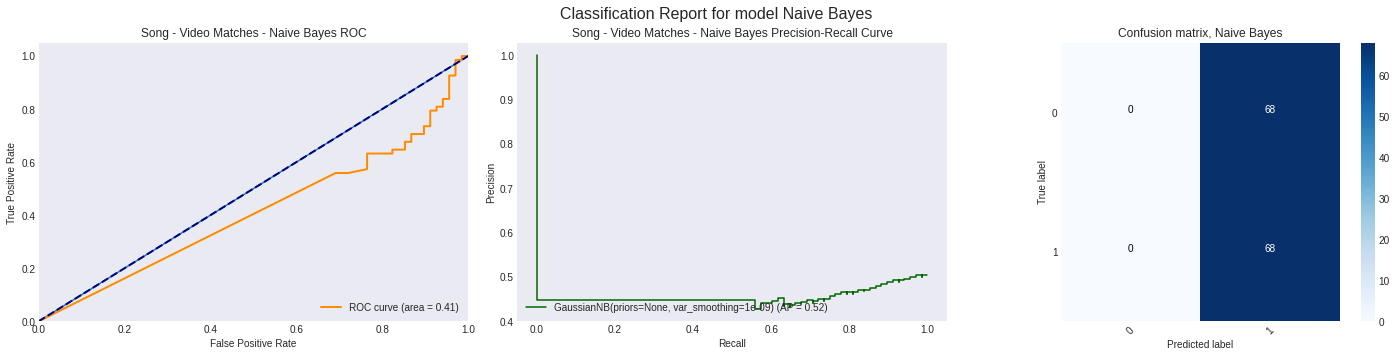

In [ ]:
get_results_and_plots(fold_results)

In [ ]:
get_model_comparison_mean(fold_results)

TypeError: ignored

In [ ]:
get_model_comparison_std(fold_results)

In [ ]:
get_model_comparison_median(fold_results)

# Experiment with selected examples and GridSearch

In [ ]:
data, X, y, groups = load_data()
names = X.columns

In [ ]:
pipe_PCA_ET = Pipeline([
              # PCA with Extra Trees, using min samples leaf = 1 etc.
              ('impute', SimpleImputer(missing_values=np.NaN, strategy='mean')),
              ('scaling', preprocessing.StandardScaler(copy=True, with_mean=True, with_std=True)),
              ('reduce_dim', PCA(copy=True, iterated_power='auto',
                              random_state=seed, svd_solver='arpack', tol=0.0,
                              whiten=False)),
              ('classify', ExtraTreesClassifier(criterion='entropy', random_state=seed, n_jobs=-1))
          ])

my_cv = LeaveOneGroupOut()

solvers = ['arpack', 'auto']
n_components = [None,100]
max_depths = [1,4,6]
min_samples_leaf = [1,2,3]
min_samples_split = [2,5,10]

param_grid_1 = [
    {
        'reduce_dim__svd_solver': solvers,
        'reduce_dim__n_components': n_components,
        'classify__max_depth': max_depths,
        'classify__min_samples_leaf': min_samples_leaf,
        'classify__min_samples_split': min_samples_split
    }]

grid_1 = GridSearchCV(estimator=pipe_PCA_ET, 
                      n_jobs=-1, 
                      param_grid=param_grid_1, 
                      scoring=["accuracy", "recall", "average_precision"], 
                      refit='accuracy', 
                      cv=my_cv)
grid_1.fit(X, y, groups)

GridSearchCV(cv=LeaveOneGroupOut(), error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('impute',
                                        SimpleImputer(add_indicator=False,
                                                      copy=True,
                                                      fill_value=None,
                                                      missing_values=nan,
                                                      strategy='mean',
                                                      verbose=0)),
                                       ('scaling',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('reduce_dim',
                                        PCA(copy=True, iterated_power='auto',
                                     

In [ ]:
pd.DataFrame(grid_1.cv_results_)

mean_fit_time  ...  rank_test_average_precision
0         0.220321  ...                           74
1         0.207539  ...                          101
2         0.222226  ...                           53
3         0.213429  ...                           53
4         0.214073  ...                           74
..             ...  ...                          ...
103       0.267824  ...                           13
104       0.276541  ...                           52
105       0.268503  ...                          100
106       0.280363  ...                            7
107       0.268086  ...                            7

[108 rows x 118 columns]

In [ ]:
pipe_NB= Pipeline(memory=None,
                  steps=[('impute',
                          SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                                        missing_values=np.NaN, strategy='mean',
                                        verbose=0)),
                          ('scaling', preprocessing.MinMaxScaler(copy=True, feature_range=(0, 1))),
                          ('reduce_dim', SelectKBest(mutual_info_classif, k=150)),
                          ('classify',
                          GaussianNB())],
                  verbose=False)

my_cv = LeaveOneGroupOut()

ks = [10, 50, 100, 150, 200, 250, 300, 350]

param_grid_2 = [
    {
        'reduce_dim__k': ks
    }]

grid_2 = GridSearchCV(estimator=pipe_NB, 
                      n_jobs=-1, 
                      param_grid=param_grid_2, 
                      scoring=["accuracy", "recall", "average_precision"], 
                      refit='accuracy', 
                      cv=my_cv)
grid_2.fit(X, y, groups)

GridSearchCV(cv=LeaveOneGroupOut(), error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('impute',
                                        SimpleImputer(add_indicator=False,
                                                      copy=True,
                                                      fill_value=None,
                                                      missing_values=nan,
                                                      strategy='mean',
                                                      verbose=0)),
                                       ('scaling',
                                        MinMaxScaler(copy=True,
                                                     feature_range=(0, 1))),
                                       ('reduce_dim',
                                        SelectKBest(k=150,
                                                    score_func=<function mutual_info_classif at 0x7fba411a8d90>)),
         

In [ ]:
pd.DataFrame(grid_2.cv_results_)[['params','mean_test_accuracy']]

params  mean_test_accuracy
0   {'reduce_dim__k': 10}            0.397727
1   {'reduce_dim__k': 50}            0.431818
2  {'reduce_dim__k': 100}            0.522601
3  {'reduce_dim__k': 150}            0.520202
4  {'reduce_dim__k': 200}            0.597727
5  {'reduce_dim__k': 250}            0.554545
6  {'reduce_dim__k': 300}            0.561364
7  {'reduce_dim__k': 350}            0.579672

In [ ]:
pipe_kNN = Pipeline(memory=None,
         steps=[('impute',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=np.NaN, strategy='mean',
                               verbose=0)),
                ('scaling', preprocessing.MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('reduce_dim',
                 MyDimRed(mode='extreme',
                          names=names)),
                ('classify',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                                metric='minkowski', metric_params=None,
                                                n_jobs=-1, n_neighbors=1, p=1,
                                                weights='uniform'))],
         verbose=False)

my_cv = LeaveOneGroupOut()

neighborss = [1,2,3,4]
ps = [1,2]
weights = ['uniform', 'distance']

param_grid_3 = [
    {
        'classify__p':  ps,
        'classify__weights': weights,
        'classify__n_neighbors': neighborss,
    }]

grid_3 = GridSearchCV(estimator=pipe_kNN, 
                      n_jobs=-1, 
                      param_grid=param_grid_3, 
                      scoring=["accuracy", "recall", "average_precision"], 
                      refit='accuracy', 
                      cv=my_cv)
grid_3.fit(X, y, groups)

GridSearchCV(cv=LeaveOneGroupOut(), error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('impute',
                                        SimpleImputer(add_indicator=False,
                                                      copy=True,
                                                      fill_value=None,
                                                      missing_values=nan,
                                                      strategy='mean',
                                                      verbose=0)),
                                       ('scaling',
                                        MinMaxScaler(copy=True,
                                                     feature_range=(0, 1))),
                                       ('reduce_dim',
                                        MyDimRed(mode='extreme',
                                                 names=Index(['zcr_mean', 'energy_mean', 'energy_entr...
             

In [ ]:
pd.DataFrame(grid_3.cv_results_)

mean_fit_time  ...  rank_test_average_precision
0        0.397380  ...                           10
1        0.314627  ...                           10
2        0.293860  ...                           15
3        0.246052  ...                           15
4        0.245439  ...                            7
5        0.242894  ...                            3
6        0.244731  ...                           12
7        0.246998  ...                            5
8        0.246143  ...                            8
9        0.248165  ...                            1
10       0.243102  ...                           13
11       0.247239  ...                            6
12       0.244758  ...                            9
13       0.243778  ...                            2
14       0.240553  ...                           14
15       0.244012  ...                            4

[16 rows x 116 columns]

In [ ]:
grid_1.best_estimator_

Pipeline(memory=None,
         steps=[('impute',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('scaling',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('reduce_dim',
                 PCA(copy=True, iterated_power='auto', n_components=None,
                     random_state=2015, svd_solver='arpack', tol=0.0,
                     whiten=False)),
                ('classify',
                 ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                                      class_weight=None, criterion='entropy',
                                      max_depth=4, max_features='auto',
                                      max_leaf_nodes=None, max_samples=None,
                                      min_impurity_decrease=0.0,
                                      min_impurity_s

In [ ]:
grid_2.best_estimator_

Pipeline(memory=None,
         steps=[('impute',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('scaling', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('reduce_dim',
                 SelectKBest(k=200,
                             score_func=<function mutual_info_classif at 0x7fba411a8d90>)),
                ('classify', GaussianNB(priors=None, var_smoothing=1e-09))],
         verbose=False)

In [ ]:
grid_3.best_estimator_

Pipeline(memory=None,
         steps=[('impute',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('scaling', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('reduce_dim',
                 MyDimRed(mode='extreme',
                          names=Index(['zcr_mean', 'energy_mean', 'energy_entropy_mean',
       'spectral_centroid_mean', 'spectral_spread_mean',
       'sp...
       'kitchen_mean_area_ratio', 'food_mean_area_ratio',
       'furniture_mean_area_ratio', 'electronic_mean_area_ratio',
       'appliance_mean_area_ratio', 'indoor_mean_area_ratio'],
      dtype='object', length=455))),
                ('classify',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=-1, 

In [ ]:
models = [('PCA_ET', grid_1.best_estimator_), ('mtu_inf_NB', grid_2.best_estimator_),
          ('kNN', grid_3.best_estimator_)]


In [ ]:
X = X.to_numpy()
y = y.to_numpy()
fold_results = make_tests(X, y, groups)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/usr/local/lib/python3.6/dis

PCA_ET
              precision    recall  f1-score   support

           0       0.54      0.29      0.38        68
           1       0.52      0.75      0.61        68

    accuracy                           0.52       136
   macro avg       0.53      0.52      0.50       136
weighted avg       0.53      0.52      0.50       136

mtu_inf_NB
              precision    recall  f1-score   support

           0       0.48      0.22      0.30        68
           1       0.50      0.76      0.60        68

    accuracy                           0.49       136
   macro avg       0.49      0.49      0.45       136
weighted avg       0.49      0.49      0.45       136

kNN
              precision    recall  f1-score   support

           0       0.58      0.49      0.53        68
           1       0.56      0.65      0.60        68

    accuracy                           0.57       136
   macro avg       0.57      0.57      0.56       136
weighted avg       0.57      0.57      0.56       13

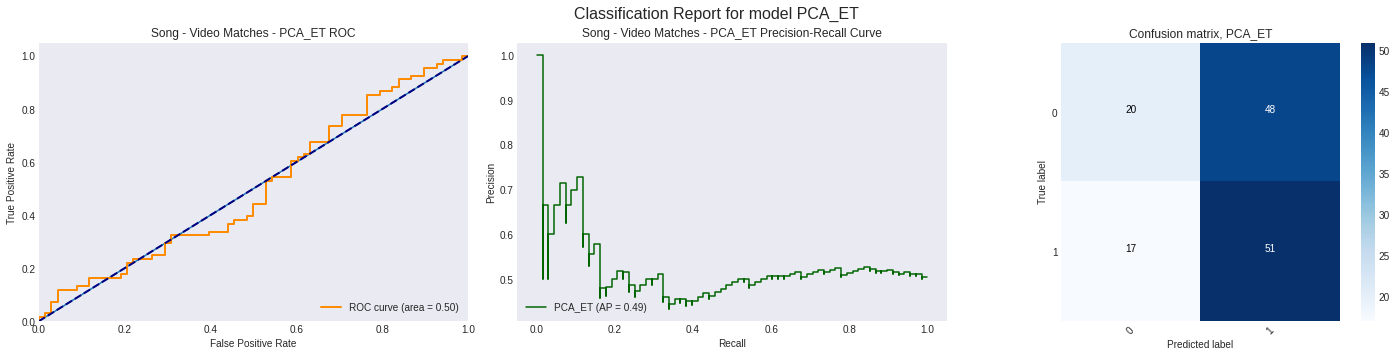

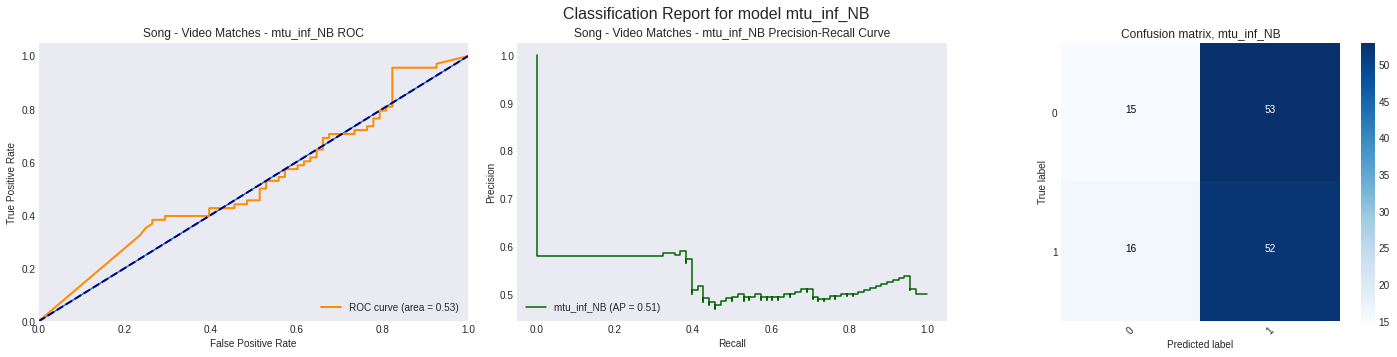

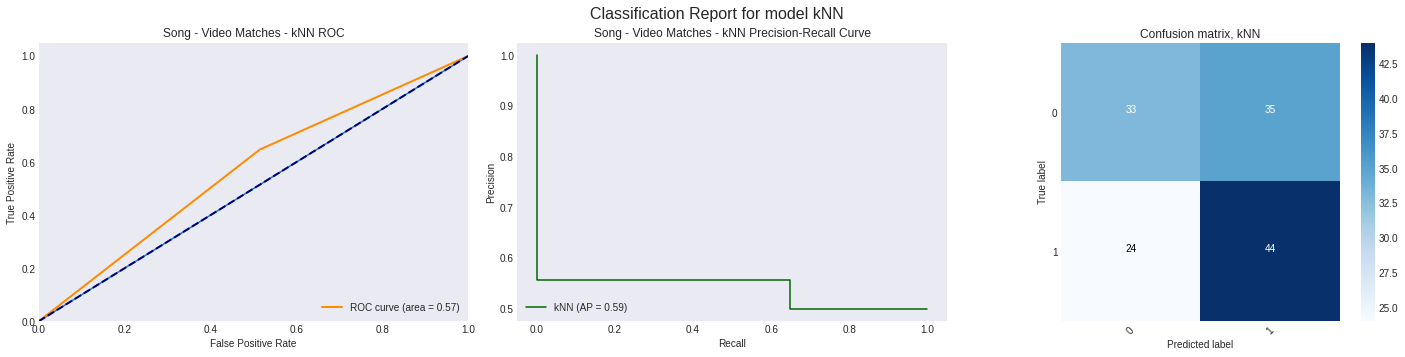

In [ ]:
get_results_and_plots(fold_results)

In [ ]:
get_model_comparison_mean(fold_results)

PCA_DT  PCA_DT_gini  PCA_SVM  ex_DR_kNN_1  ex_DR_kNN_3    NB
accuracy     0.67         0.56     0.48         0.62         0.57  0.63
precision    0.62         0.46     0.20         0.59         0.53  0.58
recall       0.69         0.50     0.15         0.72         0.74  0.84
f1           0.62         0.45     0.15         0.62         0.59  0.66
roc          0.60         0.53     0.54         0.55         0.54  0.55

In [ ]:
get_model_comparison_std(fold_results)

PCA_DT  PCA_DT_gini  PCA_SVM  ex_DR_kNN_1  ex_DR_kNN_3    NB
accuracy     0.27         0.28     0.24         0.30         0.26  0.28
precision    0.38         0.42     0.38         0.34         0.31  0.33
recall       0.38         0.43     0.32         0.37         0.38  0.34
f1           0.35         0.39     0.31         0.33         0.31  0.31
roc          0.36         0.36     0.42         0.33         0.35  0.37

In [ ]:
get_model_comparison_median(fold_results)

PCA_DT  PCA_DT_gini  PCA_SVM  ex_DR_kNN_1  ex_DR_kNN_3    NB
accuracy     0.67          0.5      0.5         0.60         0.50  0.56
precision    0.50          0.5      0.0         0.50         0.50  0.50
recall       1.00          0.5      0.0         1.00         1.00  1.00
f1           0.67          0.5      0.0         0.67         0.67  0.67
roc          0.62          0.5      0.5         0.50         0.50  0.50

# Experiment with selected examples and custom scoring

In [ ]:
data, X, y, groups = load_data()
names = X.columns

In [ ]:
pipe_PCA_ET_150 = Pipeline([
              # PCA with Extra Trees, using min samples leaf = 1 etc.
              ('impute', SimpleImputer(missing_values=np.NaN, strategy='mean')),
              ('scaling', preprocessing.StandardScaler(copy=True, with_mean=True, with_std=True)),
              ('reduce_dim', PCA(copy=True, random_state=seed, svd_solver='arpack')),
              ('classify', ExtraTreesClassifier(random_state=seed, n_jobs=-1, n_estimators=150))
          ])

pipe_PCA_ET_100 = Pipeline([
              # PCA with Extra Trees, using min samples leaf = 1 etc.
              ('impute', SimpleImputer(missing_values=np.NaN, strategy='mean')),
              ('scaling', preprocessing.StandardScaler(copy=True, with_mean=True, with_std=True)),
              ('reduce_dim', PCA(copy=True, random_state=seed, svd_solver='arpack')),
              ('classify', ExtraTreesClassifier(random_state=seed, n_jobs=-1, n_estimators=100))
          ])

pipe_PCA_ET_50 = Pipeline([
              # PCA with Extra Trees, using min samples leaf = 1 etc.
              ('impute', SimpleImputer(missing_values=np.NaN, strategy='mean')),
              ('scaling', preprocessing.StandardScaler(copy=True, with_mean=True, with_std=True)),
              ('reduce_dim', PCA(copy=True, random_state=seed, svd_solver='arpack')),
              ('classify', ExtraTreesClassifier(random_state=seed, n_jobs=-1, n_estimators=50))
          ])

pipe_PCA_ET_200 = Pipeline([
              # PCA with Extra Trees, using min samples leaf = 1 etc.
              ('impute', SimpleImputer(missing_values=np.NaN, strategy='mean')),
              ('scaling', preprocessing.StandardScaler(copy=True, with_mean=True, with_std=True)),
              ('reduce_dim', PCA(copy=True, random_state=seed, svd_solver='arpack')),
              ('classify', ExtraTreesClassifier(random_state=seed, n_jobs=-1, n_estimators=200))
          ])

pipe_NB_150= Pipeline(memory=None,
                  steps=[('impute', SimpleImputer(missing_values=np.NaN, strategy='mean')),
                          ('scaling', preprocessing.MinMaxScaler()),
                          ('reduce_dim', SelectKBest(mutual_info_classif, k=150)),
                          ('classify', GaussianNB())],
                  verbose=False)

pipe_NB_100= Pipeline(memory=None,
                  steps=[('impute', SimpleImputer(missing_values=np.NaN, strategy='mean')),
                          ('scaling', preprocessing.MinMaxScaler()),
                          ('reduce_dim', SelectKBest(mutual_info_classif, k=100)),
                          ('classify', GaussianNB())],
                  verbose=False)

pipe_NB_200 = Pipeline(memory=None,
                  steps=[('impute', SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                                        missing_values=np.NaN, strategy='mean',
                                        verbose=0)),
                          ('scaling', preprocessing.MinMaxScaler()),
                          ('reduce_dim', SelectKBest(mutual_info_classif, k=200)),
                          ('classify', GaussianNB())],
                  verbose=False)

pipe_NB_50= Pipeline(memory=None,
                  steps=[('impute', SimpleImputer(missing_values=np.NaN, strategy='mean')),
                          ('scaling', preprocessing.MinMaxScaler()),
                          ('reduce_dim', SelectKBest(mutual_info_classif, k=50)),
                          ('classify', GaussianNB())],
                  verbose=False)

pipe_kNN_1 = Pipeline(memory=None,
         steps=[('impute',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=np.NaN, strategy='mean',
                               verbose=0)),
                ('scaling', preprocessing.MinMaxScaler()),
                ('reduce_dim',
                 MyDimRed(mode='extreme',
                          names=names)),
                ('classify', KNeighborsClassifier(n_jobs=-1, n_neighbors=1, weights='uniform'))],
         verbose=False)

pipe_kNN_2 = Pipeline(memory=None,
         steps=[('impute',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=np.NaN, strategy='mean',
                               verbose=0)),
                ('scaling', preprocessing.MinMaxScaler()),
                ('reduce_dim',
                 MyDimRed(mode='extreme',
                          names=names)),
                ('classify', KNeighborsClassifier(n_jobs=-1, n_neighbors=2, weights='uniform'))],
         verbose=False)

pipe_kNN_3 = Pipeline(memory=None,
         steps=[('impute',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=np.NaN, strategy='mean',
                               verbose=0)),
                ('scaling', preprocessing.MinMaxScaler()),
                ('reduce_dim',
                 MyDimRed(mode='extreme',
                          names=names)),
                ('classify', KNeighborsClassifier(n_jobs=-1, n_neighbors=3, weights='uniform'))],
         verbose=False)

pipe_kNN_4 = Pipeline(memory=None,
         steps=[('impute',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=np.NaN, strategy='mean',
                               verbose=0)),
                ('scaling', preprocessing.MinMaxScaler()),
                ('reduce_dim',
                 MyDimRed(mode='extreme',
                          names=names)),
                ('classify', KNeighborsClassifier(n_jobs=-1, n_neighbors=4, weights='uniform'))],
         verbose=False)

In [ ]:
models = [('PCA_ET_50', pipe_PCA_ET_50),
          ('PCA_ET_100', pipe_PCA_ET_100),
          ('PCA_ET_150', pipe_PCA_ET_150),
          ('PCA_ET_200', pipe_PCA_ET_200),
          ('NB_50', pipe_NB_50),
          ('NB_100', pipe_NB_100),
          ('NB_150', pipe_NB_150),
          ('NB_200', pipe_NB_200),
          ('kNN_1', pipe_kNN_1),
          ("kNN_2", pipe_kNN_2),
          ('kNN_3', pipe_kNN_3),
          ('kNN_4', pipe_kNN_4)]



In [ ]:
X = X.to_numpy()
y = y.to_numpy()
fold_results = make_tests(X, y, groups)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined a

PCA_ET_50
              precision    recall  f1-score   support

           0       0.48      0.44      0.46        68
           1       0.49      0.53      0.51        68

    accuracy                           0.49       136
   macro avg       0.49      0.49      0.48       136
weighted avg       0.49      0.49      0.48       136

PCA_ET_100
              precision    recall  f1-score   support

           0       0.56      0.43      0.48        68
           1       0.54      0.66      0.59        68

    accuracy                           0.54       136
   macro avg       0.55      0.54      0.54       136
weighted avg       0.55      0.54      0.54       136

PCA_ET_150
              precision    recall  f1-score   support

           0       0.64      0.43      0.51        68
           1       0.57      0.76      0.65        68

    accuracy                           0.60       136
   macro avg       0.61      0.60      0.58       136
weighted avg       0.61      0.60      0.5

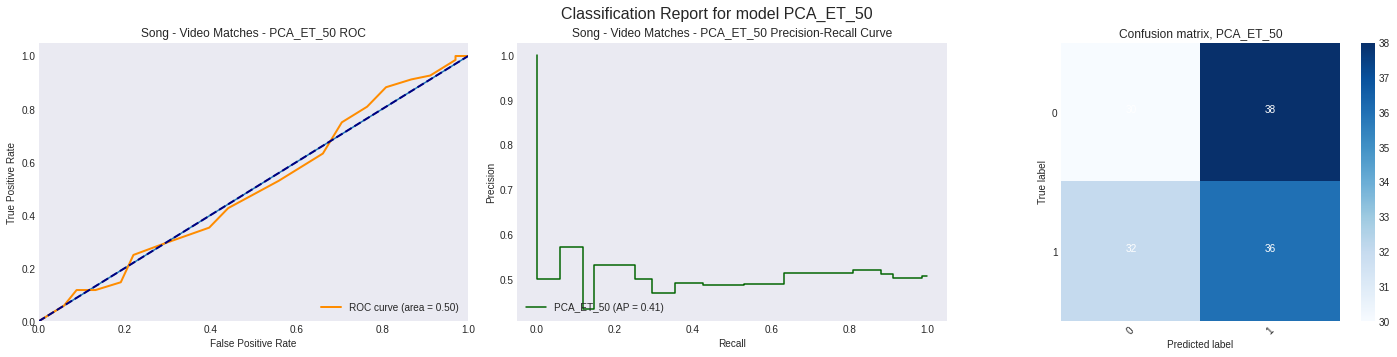

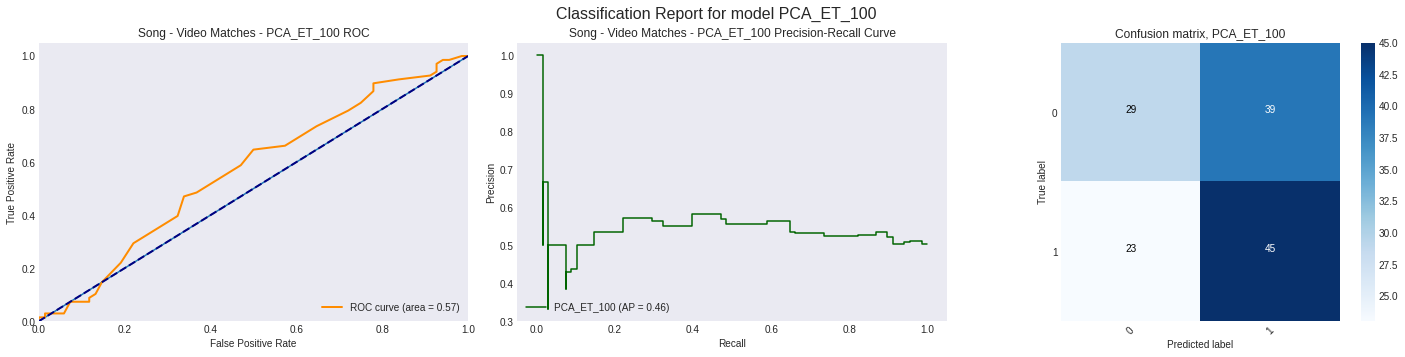

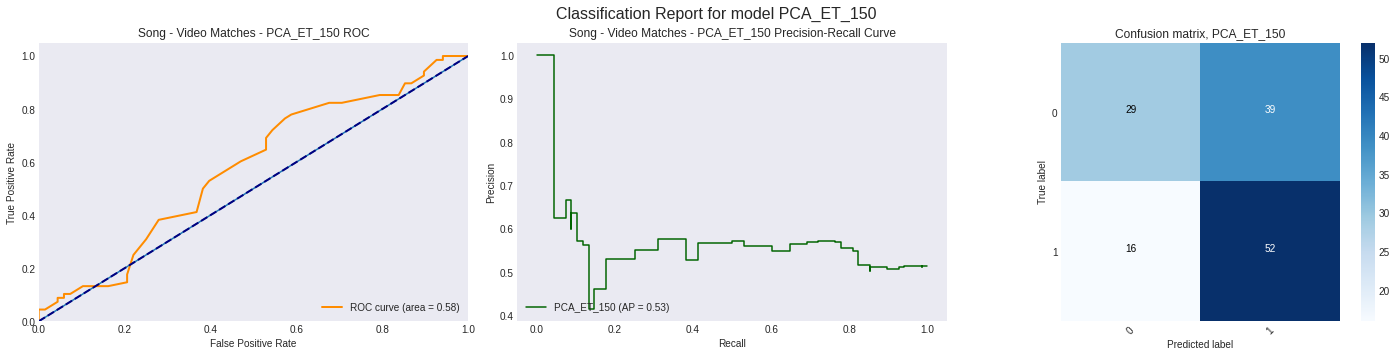

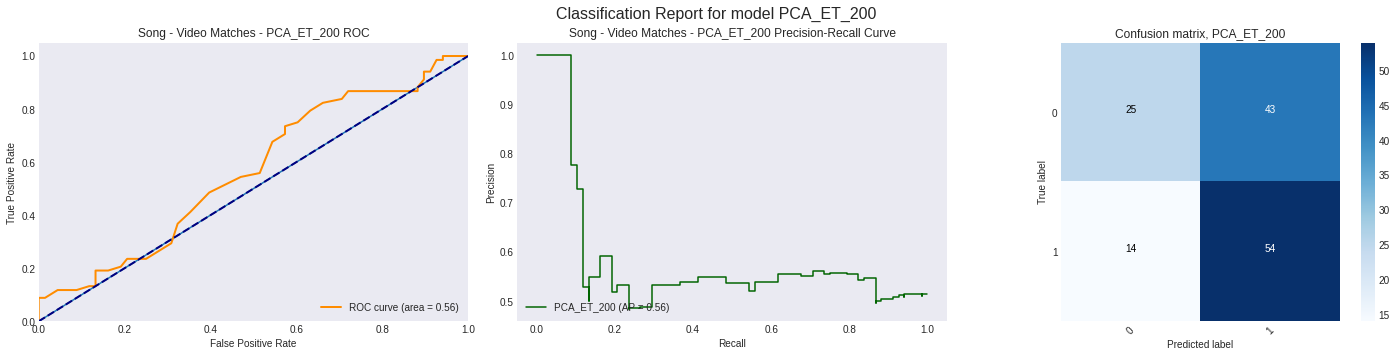

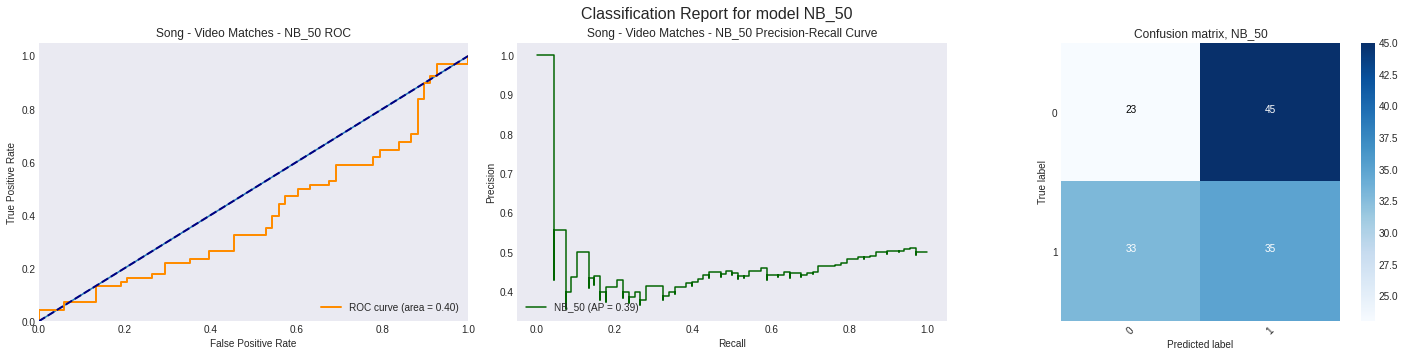

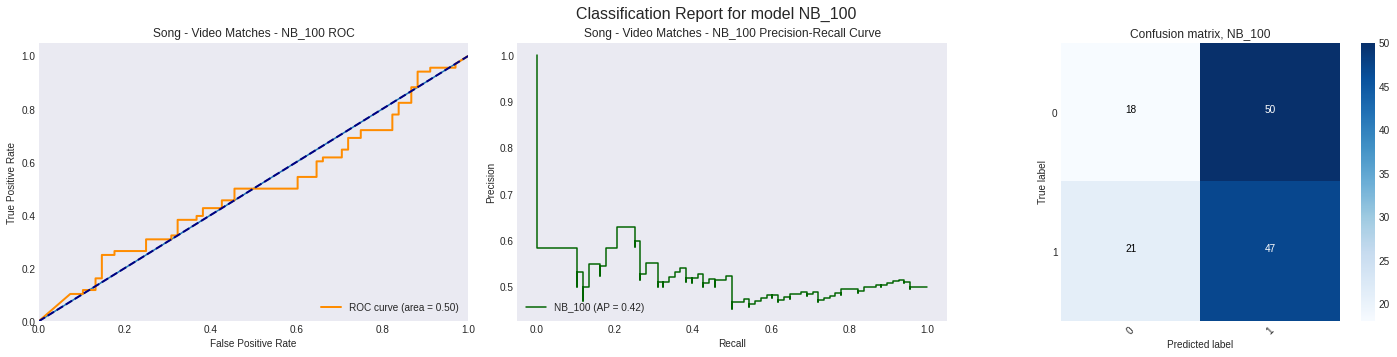

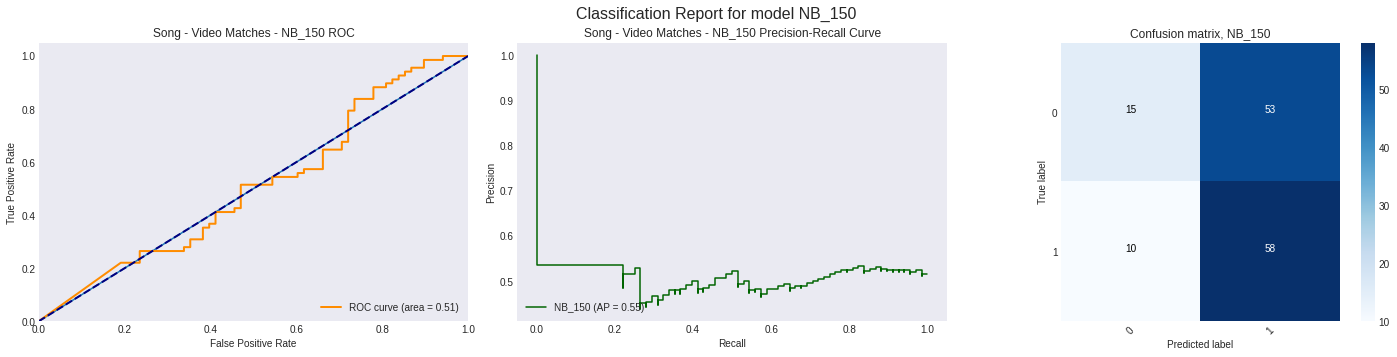

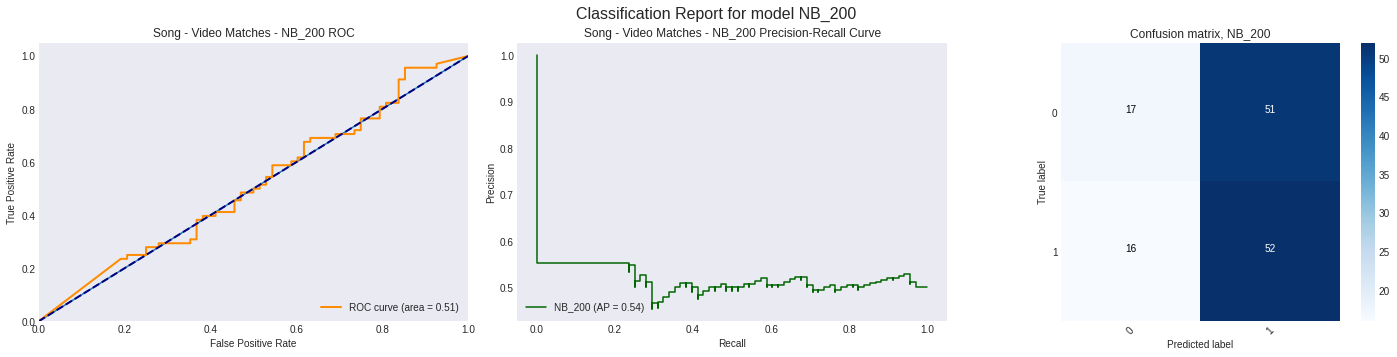

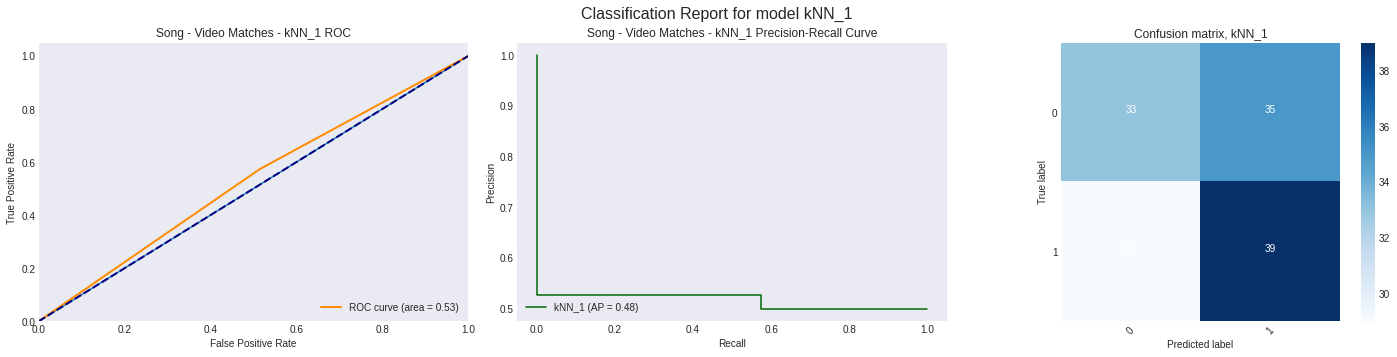

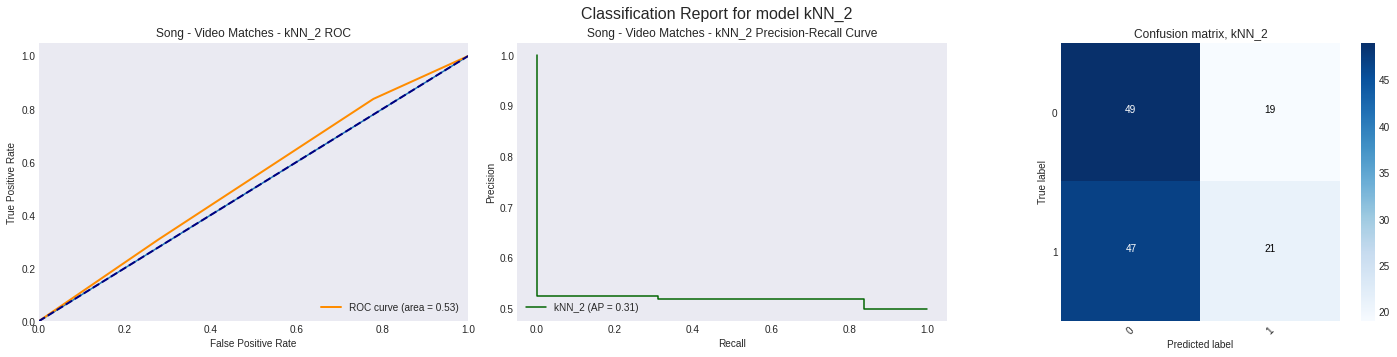

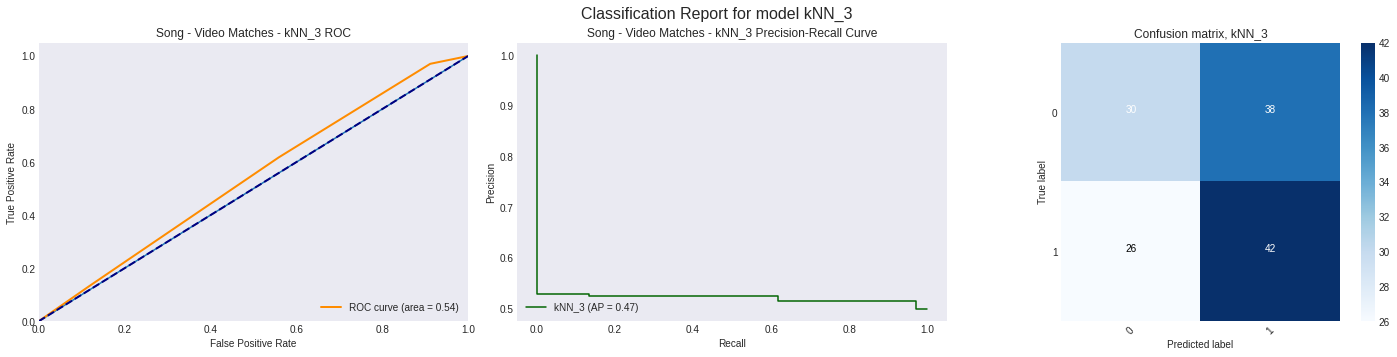

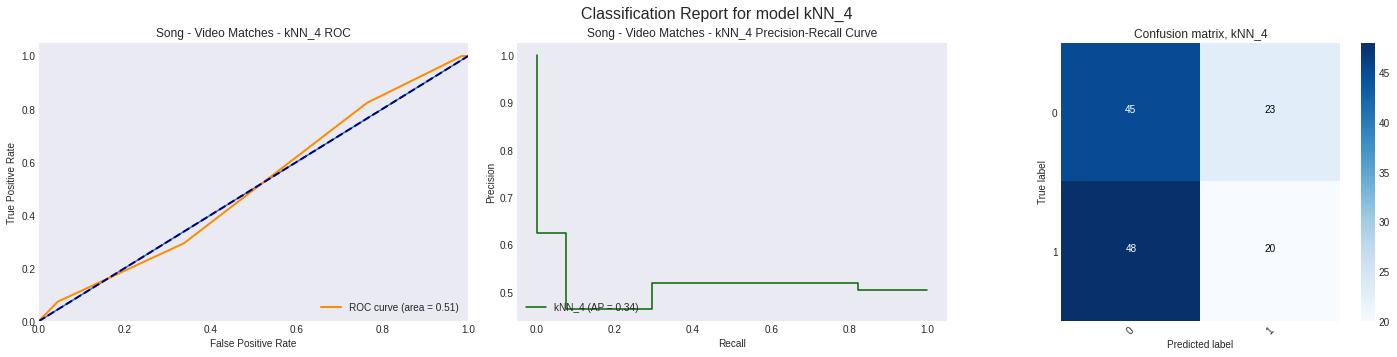

In [ ]:
get_results_and_plots(fold_results)